<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/GNN%20ECG%20timeseries%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GNN with ECG downsampled signal, edge weight is a SMETS semilarity via ECG leads

# Load libraries

In [1]:
# GraphECGNet with PTB-XL Dataset in Google Colab
!pip install torch torchvision torchaudio --quiet
!pip install torch-geometric --quiet
!pip install wfdb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 21.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.


In [2]:
import os
import ast
import pickle
import joblib
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import pandas as pd
import numpy as np
import wfdb
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from torch_geometric.data import Data

Rationale:

Physiological Meaning: Each ECG lead captures electrical activity from a different angle/view of the heart
Spatial Information: Different leads provide complementary information about heart activity
Feature Richness: Each node contains a time series of the ECG signal from that specific lead
Anatomical Relevance: Leads are positioned anatomically around the heart

Limb Lead Connections (0-5):

I ↔ II ↔ III: These leads form Einthoven's triangle
aVR, aVL, aVF: Augmented limb leads connected to the main limb leads
Adjacent leads share similar electrical pathways


Precordial Lead Connections (6-11):

V1 → V2 → V3 → V4 → V5 → V6: Anatomically sequential across the chest
Circular connection (V6 → V1): Completes the chest loop
Sequential activation: Electrical wavefront moves across the chest

# Load dataset

Dataset link:
https://physionet.org/content/ptb-xl/1.0.3/


Based on the PhysioNet dataset structure and the code, here's what information is used and for what purposes:




## 1. **ptbxl_database.csv** - Main Database File
```python
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
```
**Information contained:**
- **Patient demographics**: age, sex, weight, height
- **ECG metadata**: heart axis, infarction stadium
- **Clinical annotations**: scp_codes (SCP-ECG standard statements)
- **File references**: filename_lr, filename_hr (for raw data access)
- **Unique identifiers**: ecg_id, patient_id

**Used for:**
- Loading ECG file paths and metadata
- Extracting diagnostic labels for classification
- Patient stratification and analysis
- Quality control and validation information



## 2. **scp_statements.csv** - Standardized ECG Statements
```python
aggregation_df = pd.read_csv(folder+'scp_statements.csv', index_col=0)
```
**Information contained:**
- **71 different ECG statements** following SCP-ECG standard
- **Classification categories**: diagnostic, form, rhythm statements
- **Hierarchical organization**: diagnostic_class, diagnostic_subclass
- **Statement properties**: likelihood, priority, category

**Used for:**
- Converting raw SCP codes to meaningful diagnostic categories
- Creating superdiagnostic labels (aggregating similar conditions)
- Ensuring standardized interpretation across cardiologists
- Building consistent classification targets



## 3. **Raw ECG Signal Files** (.dat/.hea)
```python
data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_lr)]
```
**Information contained:**
- **12-lead ECG signals**: I, II, III, aVR, aVL, aVF, V1-V6
- **10-second recordings** at 100Hz or 500Hz sampling rate
- **Standardized format**: WFDB-compatible files

**Used for:**
- **Primary input data** for the GraphECGNet model
- Creating graph node features (each lead becomes a node)
- Training the neural network to recognize patterns
- Converting to graph representations where leads are nodes

In [3]:
# Download procedure with progress bar
from google.colab import drive
from tqdm import tqdm
import subprocess
import time

TOTAL_SAMPLES = 700


# Mount Google Drive
drive.mount('/content/drive')

# Define paths
DRIVE_PATH = '/content/drive/MyDrive/ptb_xl_200_samples'
LOCAL_PATH = '/content/ptb_xl_200_samples'

# Check if dataset already exists in Google Drive
if os.path.exists(DRIVE_PATH):
    print("✅ PTB-XL dataset already exists in Google Drive!")
    print("Skipping download...")
    # Create symlink or copy to local directory
    if not os.path.exists(LOCAL_PATH):
        !ln -s "{DRIVE_PATH}" "{LOCAL_PATH}"
    PATH = LOCAL_PATH
else:
    print("Dataset not found in Google Drive. Downloading first samples...")
    print("Progress: Downloading metadata files...")

    # Create directory
    !mkdir -p "{DRIVE_PATH}"
    %cd "{DRIVE_PATH}"

    # Download essential metadata files with progress indication
    print("1️⃣ Downloading ptbxl_database.csv...")
    !wget -N --progress=bar:force:noscroll https://physionet.org/files/ptb-xl/1.0.3/ptbxl_database.csv

    print("2️⃣ Downloading scp_statements.csv...")
    !wget -N --progress=bar:force:noscroll https://physionet.org/files/ptb-xl/1.0.3/scp_statements.csv

    # Create directory structure for first 200 samples
    !mkdir -p records100/00000

    print("3️⃣ Downloading first ECG samples...")
    print("🔄 This may take a few minutes. Please wait...")

    # Download first 200 ECG samples with progress bar
    failed_downloads = 0
    successful_downloads = 0

    # Create progress bar
    pbar = tqdm(range(1, TOTAL_SAMPLES+1), desc="Downloading ECG samples", unit="files")

    for i in pbar:
        # Format the filename with leading zeros
        filename = f"{i:05d}"
        folder = f"{(i//1000)*1000:05d}"

        # Create folder if it doesn't exist
        folder_path = f"records100/{folder}"
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # Download .dat and .hea files
        dat_url = f"https://physionet.org/files/ptb-xl/1.0.3/records100/{folder}/{filename}_lr.dat"
        hea_url = f"https://physionet.org/files/ptb-xl/1.0.3/records100/{folder}/{filename}_lr.hea"

        try:
            # Download files with error handling
            result_dat = subprocess.run(["wget", "-N", "-q", dat_url, "-P", folder_path],
                                      capture_output=True, text=True, timeout=30)
            result_hea = subprocess.run(["wget", "-N", "-q", hea_url, "-P", folder_path],
                                      capture_output=True, text=True, timeout=30)

            if result_dat.returncode == 0 and result_hea.returncode == 0:
                successful_downloads += 1
            else:
                failed_downloads += 1

        except subprocess.TimeoutExpired:
            failed_downloads += 1
            pbar.set_postfix({"Success": successful_downloads, "Failed": failed_downloads})
            continue
        except Exception as e:
            failed_downloads += 1
            pbar.set_postfix({"Success": successful_downloads, "Failed": failed_downloads})
            continue

        # Update progress bar
        pbar.set_postfix({"Success": successful_downloads, "Failed": failed_downloads})

        # Small delay to avoid overwhelming the server
        if i % 10 == 0:
            time.sleep(0.1)

    pbar.close()

    print(f"\n✅ Download completed!")
    print(f"   Successfully downloaded: {successful_downloads} samples")
    print(f"   Failed downloads: {failed_downloads} samples")

    if failed_downloads > 0:
        print("Some files failed to download. You may want to retry or check your connection.")

    print("Successfully downloaded first 200 ECG samples to Google Drive!")
    PATH = DRIVE_PATH

# Set working directory
%cd "{PATH}"
print(f"Working directory set to: {PATH}")
print("✅ Ready to process PTB-XL dataset!")

Mounted at /content/drive
✅ PTB-XL dataset already exists in Google Drive!
Skipping download...
/content/drive/MyDrive/ptb_xl_200_samples
Working directory set to: /content/ptb_xl_200_samples
✅ Ready to process PTB-XL dataset!


PTB-XL ECG Timeseries Visualization

1. Full 10-second ECG timeseries:


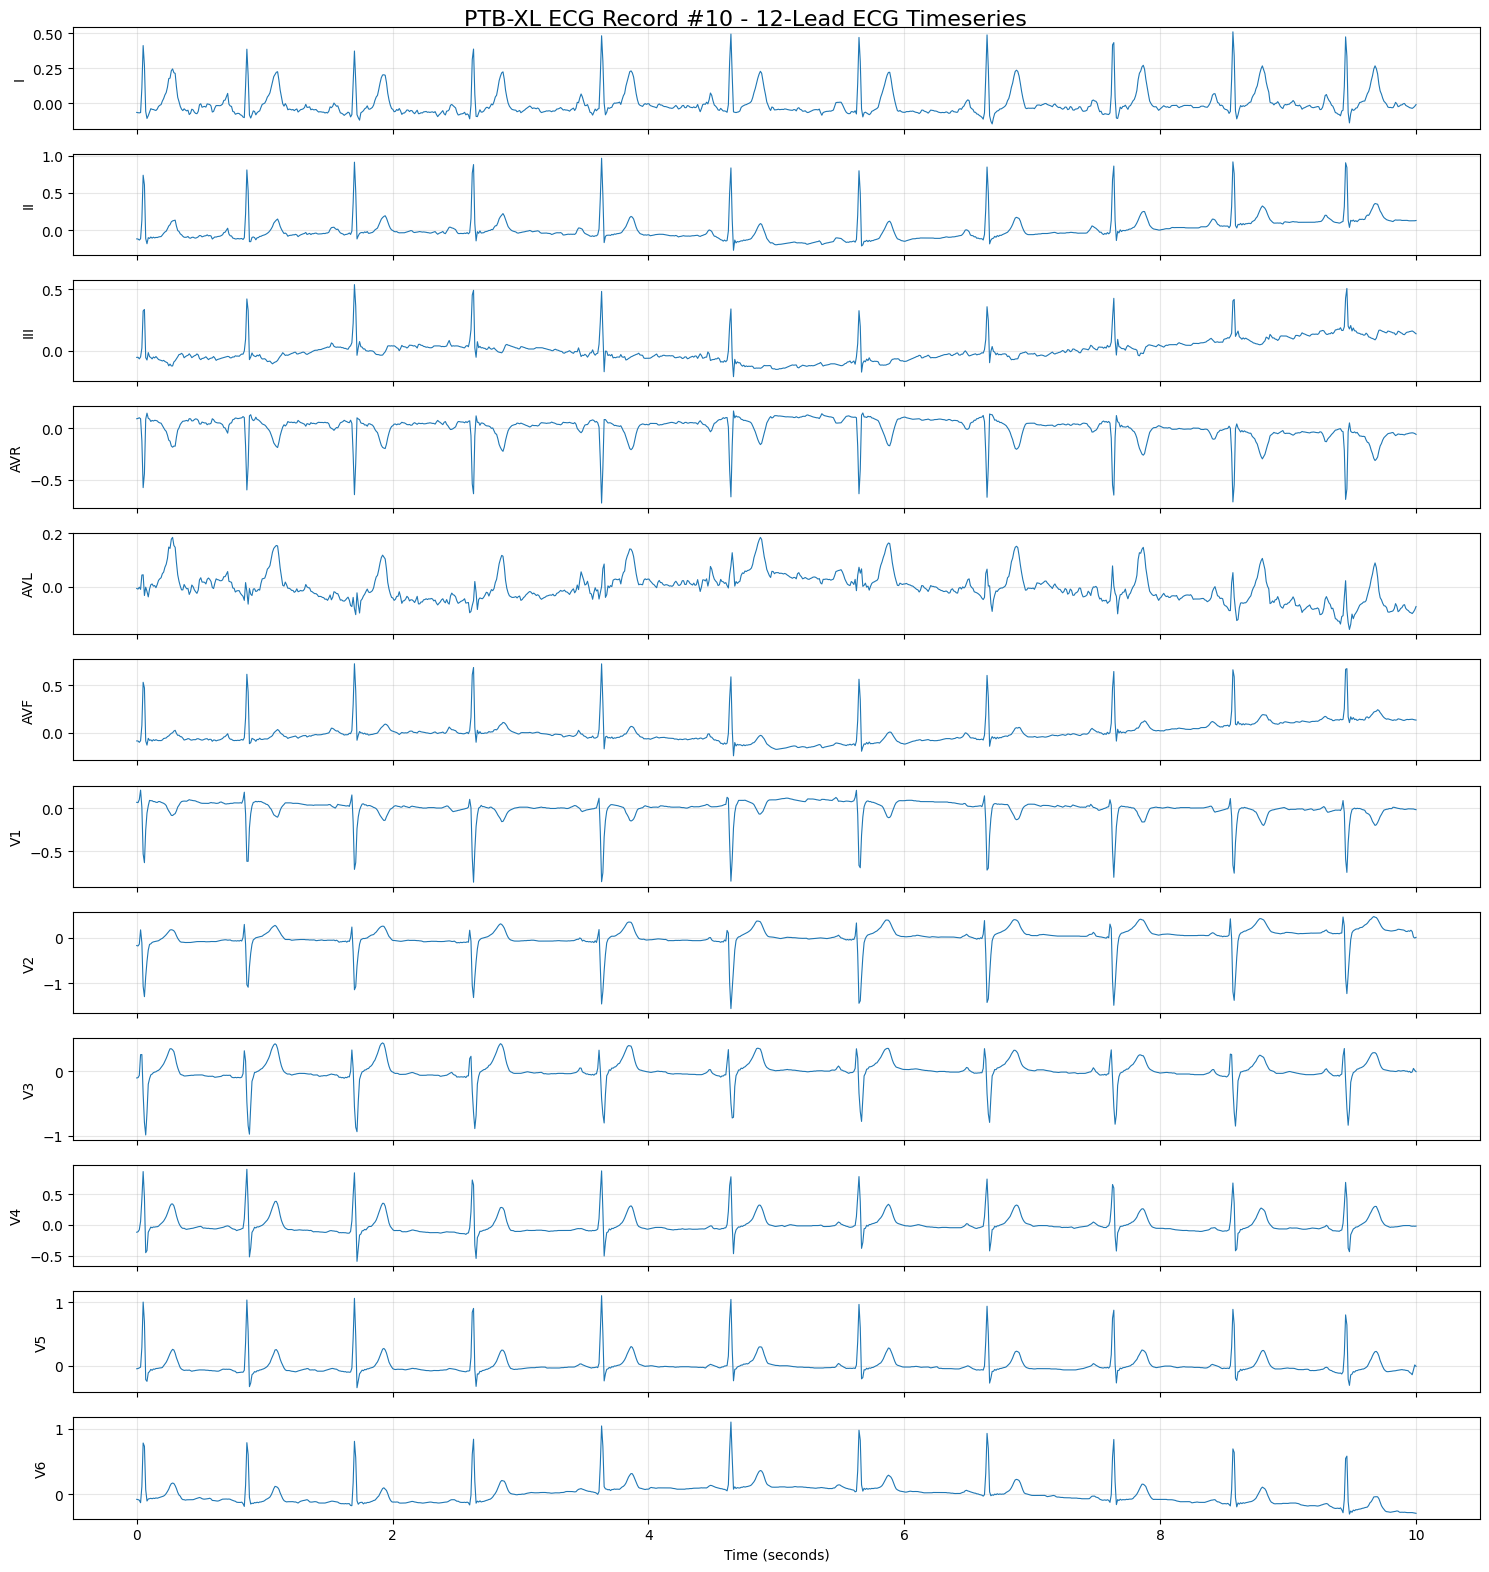

ECG Record #10 Information:
Sampling Rate: 100 Hz
Duration: 10.0 seconds
Number of Leads: 12
Lead Names: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
Signal Shape: (1000, 12)
Amplitude Range: [-1.552, 1.101]

2. Lead comparison (I, II, V1):


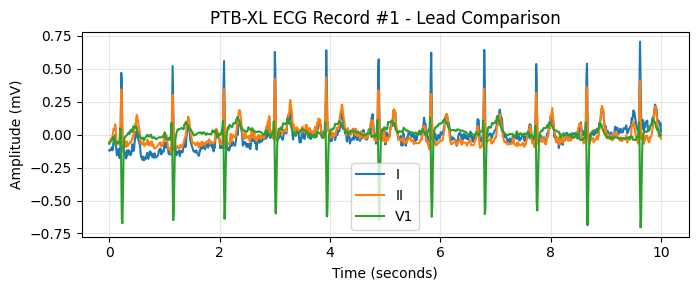


3. Detailed segment view (0-2 seconds):


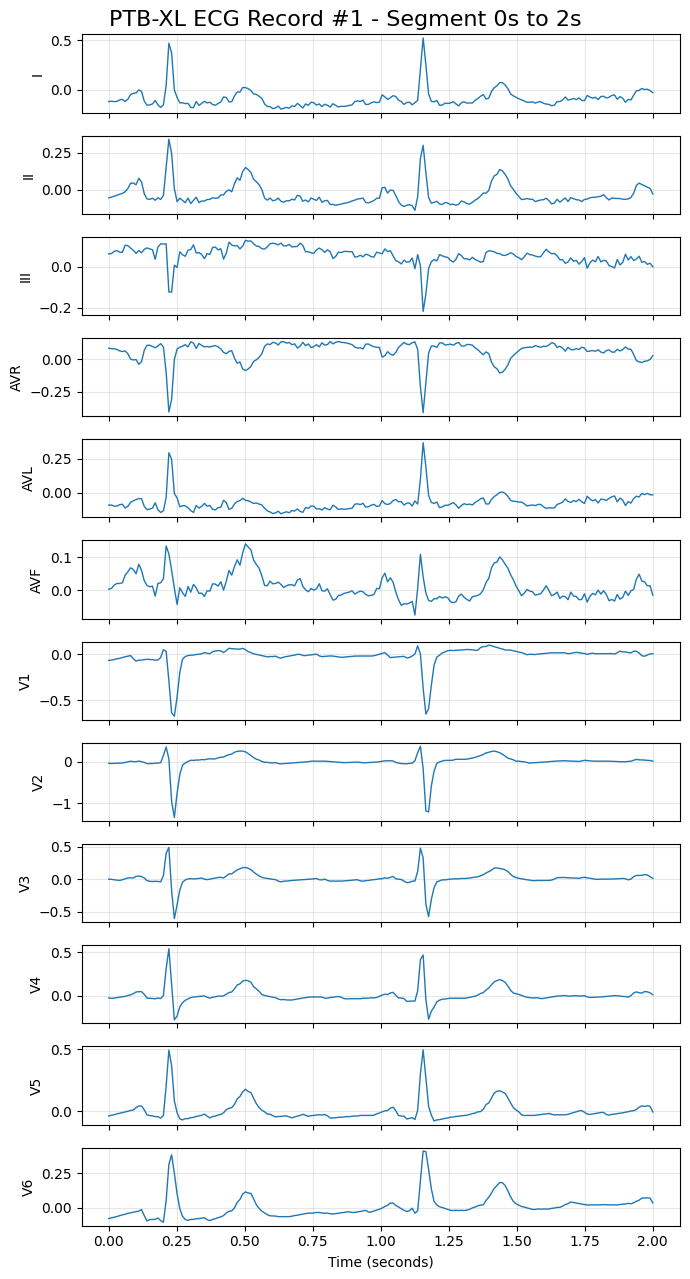

ECG Segment Information:
Record ID: 1
Time Segment: 0s to 2s
Samples: 200
Duration: 2 seconds


In [4]:
#plot ECG timeseries
import wfdb

def plot_ecg_timeseries(ecg_id=1, sampling_rate=100, base_path='/content/drive/MyDrive/ptb_xl_200_samples'):
    """
    Plot simple timeseries of downloaded ECG signal from PTB-XL dataset

    Parameters:
    ecg_id: ID of the ECG record to plot (1-200 for downloaded samples)
    sampling_rate: 100 for low resolution, 500 for high resolution
    base_path: path to the downloaded PTB-XL dataset
    """

    try:
        # Format the filename with leading zeros
        filename = f"{ecg_id:05d}"
        folder = f"{(ecg_id//1000)*1000:05d}"

        # Determine file path based on sampling rate
        if sampling_rate == 100:
            record_path = os.path.join(base_path, f"records100/{folder}/{filename}_lr")
        else:
            record_path = os.path.join(base_path, f"records500/{folder}/{filename}_hr")

        # Read the ECG record
        record = wfdb.rdsamp(record_path)
        signals = record[0]  # Signal data
        metadata = record[1]  # Metadata

        # Get lead names
        lead_names = metadata['sig_name']

        # Plot all 12 leads
        fig, axes = plt.subplots(12, 1, figsize=(15, 16))
        fig.suptitle(f'PTB-XL ECG Record #{ecg_id} - 12-Lead ECG Timeseries', fontsize=16)

        time_points = np.linspace(0, signals.shape[0]/sampling_rate, signals.shape[0])

        for i in range(12):  # 12 leads
            axes[i].plot(time_points, signals[:, i], linewidth=0.8)
            axes[i].set_ylabel(lead_names[i] if i < len(lead_names) else f'Lead {i}')
            axes[i].grid(True, alpha=0.3)
            if i < 11:  # Hide x-label for all except bottom plot
                axes[i].set_xticklabels([])

        axes[11].set_xlabel('Time (seconds)')
        plt.tight_layout()
        plt.show()

        # Print metadata information
        print(f"ECG Record #{ecg_id} Information:")
        print(f"Sampling Rate: {sampling_rate} Hz")
        print(f"Duration: {signals.shape[0]/sampling_rate} seconds")
        print(f"Number of Leads: {signals.shape[1]}")
        print(f"Lead Names: {lead_names}")
        print(f"Signal Shape: {signals.shape}")
        print(f"Amplitude Range: [{np.min(signals):.3f}, {np.max(signals):.3f}]")

        return signals, metadata

    except Exception as e:
        print(f"Error loading ECG record #{ecg_id}: {e}")
        print("Make sure the record exists in your downloaded dataset.")
        return None, None

def plot_single_lead_comparison(ecg_id=1, lead_indices=[0, 1, 6], sampling_rate=100, base_path='/content/ptb_xl_200_samples'):
    """
    Plot comparison of specific leads from an ECG record

    Parameters:
    ecg_id: ID of the ECG record to plot
    lead_indices: List of lead indices to plot (0=I, 1=II, 6=V1, etc.)
    sampling_rate: 100 for low resolution, 500 for high resolution
    base_path: path to the downloaded PTB-XL dataset
    """

    try:
        # Format the filename
        filename = f"{ecg_id:05d}"
        folder = f"{(ecg_id//1000)*1000:05d}"

        # Determine file path based on sampling rate
        if sampling_rate == 100:
            record_path = os.path.join(base_path, f"records100/{folder}/{filename}_lr")
        else:
            record_path = os.path.join(base_path, f"records500/{folder}/{filename}_hr")

        # Read the ECG record
        record = wfdb.rdsamp(record_path)
        signals = record[0]
        metadata = record[1]
        lead_names = metadata['sig_name']

        # Plot selected leads
        plt.figure(figsize=(7, 3))
        time_points = np.linspace(0, signals.shape[0]/sampling_rate, signals.shape[0])

        for i, lead_idx in enumerate(lead_indices):
            if lead_idx < signals.shape[1]:
                plt.plot(time_points, signals[:, lead_idx],
                        linewidth=1.5, label=lead_names[lead_idx] if lead_idx < len(lead_names) else f'Lead {lead_idx}')

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude (mV)')
        plt.title(f'PTB-XL ECG Record #{ecg_id} - Lead Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return signals, metadata

    except Exception as e:
        print(f"Error loading ECG record #{ecg_id}: {e}")
        return None, None

def plot_ecg_segment(ecg_id=1, start_time=0, duration=2, sampling_rate=100, base_path='/content/ptb_xl_200_samples'):
    """
    Plot a segment of ECG signal with detailed view

    Parameters:
    ecg_id: ID of the ECG record to plot
    start_time: Start time in seconds
    duration: Duration to plot in seconds
    sampling_rate: 100 for low resolution, 500 for high resolution
    base_path: path to the downloaded PTB-XL dataset
    """

    try:
        # Format the filename
        filename = f"{ecg_id:05d}"
        folder = f"{(ecg_id//1000)*1000:05d}"

        # Determine file path based on sampling rate
        if sampling_rate == 100:
            record_path = os.path.join(base_path, f"records100/{folder}/{filename}_lr")
        else:
            record_path = os.path.join(base_path, f"records500/{folder}/{filename}_hr")

        # Read the ECG record
        record = wfdb.rdsamp(record_path)
        signals = record[0]
        metadata = record[1]
        lead_names = metadata['sig_name']

        # Calculate sample indices
        start_sample = int(start_time * sampling_rate)
        end_sample = int((start_time + duration) * sampling_rate)

        # Ensure we don't go beyond signal length
        end_sample = min(end_sample, signals.shape[0])
        start_sample = max(0, start_sample)

        # Extract segment
        segment_signals = signals[start_sample:end_sample, :]
        time_points = np.linspace(start_time, start_time + (end_sample-start_sample)/sampling_rate, segment_signals.shape[0])

        # Plot all 12 leads for the segment
        fig, axes = plt.subplots(12, 1, figsize=(7, 13))
        fig.suptitle(f'PTB-XL ECG Record #{ecg_id} - Segment {start_time}s to {start_time+duration}s', fontsize=16)

        for i in range(12):
            axes[i].plot(time_points, segment_signals[:, i], linewidth=1.0)
            axes[i].set_ylabel(lead_names[i] if i < len(lead_names) else f'Lead {i}')
            axes[i].grid(True, alpha=0.3)
            if i < 11:
                axes[i].set_xticklabels([])

        axes[11].set_xlabel('Time (seconds)')
        plt.tight_layout()
        plt.show()

        print(f"ECG Segment Information:")
        print(f"Record ID: {ecg_id}")
        print(f"Time Segment: {start_time}s to {start_time+duration}s")
        print(f"Samples: {segment_signals.shape[0]}")
        print(f"Duration: {duration} seconds")

        return segment_signals, metadata

    except Exception as e:
        print(f"Error loading ECG record #{ecg_id}: {e}")
        return None, None

# Usage examples:
print("PTB-XL ECG Timeseries Visualization")
print("="*40)

# Plot full 10-second ECG for record #1
print("\n1. Full 10-second ECG timeseries:")
signals, metadata = plot_ecg_timeseries(ecg_id=10, sampling_rate=100)

# Plot comparison of specific leads
print("\n2. Lead comparison (I, II, V1):")
plot_single_lead_comparison(ecg_id=1, lead_indices=[0, 1, 6], sampling_rate=100)

# Plot a 2-second segment with more detail
print("\n3. Detailed segment view (0-2 seconds):")
segment_signals, segment_metadata = plot_ecg_segment(ecg_id=1, start_time=0, duration=2, sampling_rate=100)

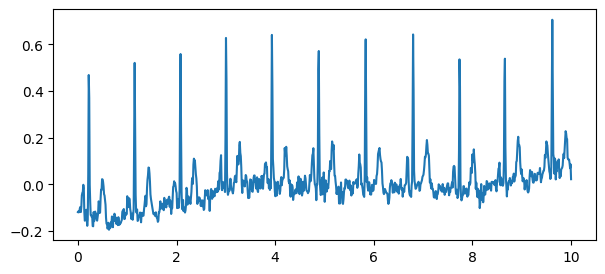

In [5]:
        ecg_id = 1
        lead_idx = 0
        base_path = '/content/ptb_xl_200_samples'
        filename = f"{ecg_id:05d}"
        folder = f"{(ecg_id//1000)*1000:05d}"
        sampling_rate = 100

        # Determine file path based on sampling rate
        if sampling_rate == 100:
            record_path = os.path.join(base_path, f"records100/{folder}/{filename}_lr")
        else:
            record_path = os.path.join(base_path, f"records500/{folder}/{filename}_hr")

        # Read the ECG record
        record = wfdb.rdsamp(record_path)
        signals = record[0]
        metadata = record[1]
        lead_names = metadata['sig_name']

        # Plot selected leads
        plt.figure(figsize=(7, 3))
        time_points = np.linspace(0, signals.shape[0]/sampling_rate, signals.shape[0])


        plt.plot(time_points, signals[:, lead_idx])

In [6]:
len(signals[:, lead_idx])

1000

# RR-peaks calculate

In [ ]:
# MODIFIED FOR RR-INTERVAL FEATURES
# =============
# RR-INTERVAL FEATURE CALCULATION & VISUALIZATION
# =============

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def calculate_rr_intervals_timeseries(ecg_signal, sampling_rate=100, target_length=None):
    """
    Calculate RR-intervals and create a timeseries of RR values.

    Parameters:
    ecg_signal: 1D numpy array, the raw ECG signal for one lead.
    sampling_rate: int, the sampling frequency in Hz (e.g., 100).
    target_length: int, optional. If provided, the output timeseries will be interpolated/resampled to this length.

    Returns:
    rr_timeseries: 1D numpy array of the same length as ecg_signal (or target_length), where each point is the current RR-interval in seconds.
    r_peak_indices: List of indices where R-peaks were detected.
    rr_intervals: List of calculated RR-interval values in seconds.
    """

    # Step 1: Detect R-peaks
    peaks, _ = find_peaks(
        ecg_signal,
        height=np.mean(ecg_signal) + 0.5 * np.std(ecg_signal),
        distance=sampling_rate * 0.3,  # Minimum 0.3 seconds between peaks
        prominence=0.1
    )

    if len(peaks) < 2:
        print("Warning: Less than 2 R-peaks detected. Returning constant RR timeseries.")
        rr_intervals = [0.8]  # Default 0.8s (75 BPM)
        rr_timeseries = np.full(len(ecg_signal), rr_intervals[0])
        return rr_timeseries, peaks, rr_intervals

    # Step 2: Calculate RR-intervals (in seconds)
    rr_intervals = []
    for i in range(1, len(peaks)):
        interval_in_samples = peaks[i] - peaks[i-1]
        interval_in_seconds = interval_in_samples / sampling_rate
        rr_intervals.append(interval_in_seconds)

    # Step 3: Create a timeseries where the RR-interval value is constant between R-peaks
    rr_timeseries = np.zeros(len(ecg_signal))

    for i in range(len(peaks)):
        if i == 0:
            rr_timeseries[:peaks[i]] = rr_intervals[0]
        elif i == len(peaks) - 1:
            rr_timeseries[peaks[i]:] = rr_intervals[-1]
        else:
            rr_timeseries[peaks[i-1]:peaks[i]] = rr_intervals[i-1]

    # Step 4 (Optional): Resample to target length
    if target_length is not None and len(rr_timeseries) != target_length:
        original_time = np.linspace(0, len(rr_timeseries) / sampling_rate, len(rr_timeseries))
        new_time = np.linspace(0, len(rr_timeseries) / sampling_rate, target_length)
        from scipy.interpolate import interp1d
        f = interp1d(original_time, rr_timeseries, kind='linear', fill_value="extrapolate")
        rr_timeseries = f(new_time)

    return rr_timeseries, peaks, rr_intervals


def visualize_rr_intervals(ecg_id=1, lead_indices=[0, 1, 6], sampling_rate=100, base_path='/content/drive/MyDrive/ptb_xl_200_samples'):
    """
    Visualize the original ECG signal and the calculated RR-interval timeseries for specified leads.
    """
    try:
        filename = f"{ecg_id:05d}"
        folder = f"{(ecg_id//1000)*1000:05d}"
        if sampling_rate == 100:
            record_path = os.path.join(base_path, f"records100/{folder}/{filename}_lr")
        else:
            record_path = os.path.join(base_path, f"records500/{folder}/{filename}_hr")

        record = wfdb.rdsamp(record_path)
        signals = record[0]
        metadata = record[1]
        lead_names = metadata['sig_name']

        fig, axes = plt.subplots(len(lead_indices), 1, figsize=(15, 4*len(lead_indices)))
        if len(lead_indices) == 1:
            axes = [axes]

        for idx, lead_index in enumerate(lead_indices):
            if lead_index >= signals.shape[1]:
                continue

            lead_signal = signals[:, lead_index]
            lead_name = lead_names[lead_index] if lead_index < len(lead_names) else f'Lead {lead_index}'

            # Calculate RR-interval timeseries
            rr_timeseries, r_peaks, rr_intervals = calculate_rr_intervals_timeseries(
                lead_signal, sampling_rate, target_length=None
            )

            time_seconds = np.linspace(0, len(lead_signal) / sampling_rate, len(lead_signal))

            # Plot original ECG
            axes[idx].plot(time_seconds, lead_signal, label=f'ECG ({lead_name})', color='blue', linewidth=0.8)
            # Plot R-peaks
            axes[idx].vlines(r_peaks / sampling_rate, ymin=np.min(lead_signal), ymax=np.max(lead_signal),
                            color='red', linestyle='--', alpha=0.7, label='R-Peaks')
            axes[idx].set_ylabel('Amplitude (mV)')
            axes[idx].set_title(f'{lead_name} - Record #{ecg_id}')
            axes[idx].legend(loc='upper left')
            axes[idx].grid(True, alpha=0.3)

            # Create twin axis for RR-interval
            ax2 = axes[idx].twinx()
            ax2.plot(time_seconds, rr_timeseries, label='RR-Interval (s)', color='green', linewidth=1.5)
            ax2.set_ylabel('RR-Interval (s)', color='green')
            ax2.tick_params(axis='y', labelcolor='green')
            ax2.legend(loc='upper right')

            if idx < len(lead_indices) - 1:
                axes[idx].set_xticklabels([])

        axes[-1].set_xlabel('Time (seconds)')
        plt.suptitle(f'ECG Signal and RR-Interval Timeseries for Record #{ecg_id}', fontsize=16)
        plt.tight_layout()
        plt.show()

        # Print statistics
        print(f"R-Peak Analysis for Record #{ecg_id}:")
        print(f"{'='*50}")
        for lead_index in lead_indices:
            if lead_index < len(lead_names):
                lead_signal = signals[:, lead_index]
                _, r_peaks, rr_intervals = calculate_rr_intervals_timeseries(lead_signal, sampling_rate)
                if len(rr_intervals) > 0:
                    mean_rr = np.mean(rr_intervals)
                    std_rr = np.std(rr_intervals)
                    bpm = 60 / mean_rr if mean_rr > 0 else 0
                    print(f"Lead {lead_names[lead_index]}: {len(r_peaks)} R-peaks, "
                          f"Mean RR: {mean_rr:.3f}s, Std: {std_rr:.3f}s, Avg BPM: {bpm:.1f}")
                else:
                    print(f"Lead {lead_names[lead_index]}: Insufficient R-peaks detected.")

    except Exception as e:
        print(f"Error in visualize_rr_intervals for record #{ecg_id}: {e}")


def plot_ecg_with_rr_features(ecg_id=1, lead_index=0, sampling_rate=100, base_path='/content/drive/MyDrive/ptb_xl_200_samples'):
    """
    Plot ECG timeseries signal and corresponding RR-interval features on the same plot.
    This is analogous to your existing `plot_ecg_with_features` but for RR-intervals.
    """
    try:
        filename = f"{ecg_id:05d}"
        folder = f"{(ecg_id//1000)*1000:05d}"
        if sampling_rate == 100:
            record_path = os.path.join(base_path, f"records100/{folder}/{filename}_lr")
        else:
            record_path = os.path.join(base_path, f"records500/{folder}/{filename}_hr")

        record = wfdb.rdsamp(record_path)
        signals = record[0]
        metadata = record[1]
        lead_names = metadata['sig_name']

        lead_signal = signals[:, lead_index]
        lead_name = lead_names[lead_index] if lead_index < len(lead_names) else f'Lead {lead_index}'

        # Calculate RR-interval timeseries
        rr_timeseries, r_peaks, rr_intervals = calculate_rr_intervals_timeseries(
            lead_signal, sampling_rate, target_length=None
        )

        # Create time arrays
        original_time = np.linspace(0, len(lead_signal)/sampling_rate, len(lead_signal))

        # Apply the same downsampling as in graph creation
        target_features = 250  # Must match `create_ecg_graph_enhanced`
        seq_len = len(rr_timeseries)
        step = max(1, seq_len // target_features)
        downsampled_rr_features = rr_timeseries[::step][:target_features]

        # Create time array for downsampled features
        feature_time_points = []
        for i in range(target_features):
            start_idx = i * step
            end_idx = min((i + 1) * step, seq_len)
            center_idx = (start_idx + end_idx) // 2
            feature_time_points.append(center_idx / sampling_rate)
        feature_time = np.array(feature_time_points)

        # Create the plot
        fig, ax1 = plt.subplots(figsize=(15, 8))

        # Plot original ECG signal
        ax1.plot(original_time, lead_signal,
                linewidth=1.0, alpha=0.7, color='blue', label=f'Original ECG ({lead_name})')
        ax1.set_xlabel('Time (seconds)')
        ax1.set_ylabel('Amplitude (mV)', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.legend(loc='upper left')
        ax1.grid(True, alpha=0.3)

        # Create twin axis for RR-interval features
        ax2 = ax1.twinx()
        # Plot downsampled RR features as scatter points
        ax2.scatter(feature_time, downsampled_rr_features,
                   color='red', s=30, alpha=0.8, marker='o',
                   label=f'RR-Interval Features ({target_features} points)', zorder=5)
        # Connect features with lines
        ax2.plot(feature_time, downsampled_rr_features,
                linewidth=1.5, color='red', alpha=0.6, linestyle='--')
        ax2.set_ylabel('RR-Interval (s)', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.legend(loc='upper right')

        plt.title(f'ECG Signal and RR-Interval Features{lead_name} - Record #{ecg_id}'f'Original: {len(lead_signal)} samples → Features: {len(downsampled_rr_features)} points')
        plt.tight_layout()
        plt.show()

        # Print information
        print(f"ECG RR-Feature Analysis for {lead_name} (Record #{ecg_id}):")
        print(f"{'='*50}")
        print(f"Original signal length: {len(lead_signal)} samples")
        print(f"Sampling rate: {sampling_rate} Hz")
        print(f"Duration: {len(lead_signal)/sampling_rate:.2f} seconds")
        print(f"Downsampling step: every {step} samples")
        print(f"Number of RR features: {len(downsampled_rr_features)}")
        print(f"Feature time resolution: ~{step/sampling_rate:.3f} seconds per feature")
        print(f"RR-Interval range - Original: [{np.min(rr_timeseries):.3f}, {np.max(rr_timeseries):.3f}] s")
        print(f"RR-Interval range - Features: [{np.min(downsampled_rr_features):.3f}, {np.max(downsampled_rr_features):.3f}] s")

        return lead_signal, downsampled_rr_features, feature_time

    except Exception as e:
        print(f"Error plotting ECG record #{ecg_id}: {e}")
        return None, None, None


def plot_ecg_rr_features_comparison(ecg_id=1, lead_indices=[0, 1, 6], sampling_rate=100, base_path='/content/drive/MyDrive/ptb_xl_200_samples'):
    """
    Plot comparison of ECG signals and their RR-interval features for multiple leads.
    """
    try:
        filename = f"{ecg_id:05d}"
        folder = f"{(ecg_id//1000)*1000:05d}"
        if sampling_rate == 100:
            record_path = os.path.join(base_path, f"records100/{folder}/{filename}_lr")
        else:
            record_path = os.path.join(base_path, f"records500/{folder}/{filename}_hr")

        record = wfdb.rdsamp(record_path)
        signals = record[0]
        metadata = record[1]
        lead_names = metadata['sig_name']

        fig, axes = plt.subplots(len(lead_indices), 1, figsize=(15, 4*len(lead_indices)))
        if len(lead_indices) == 1:
            axes = [axes]

        target_features = 250
        for idx, lead_index in enumerate(lead_indices):
            if lead_index >= signals.shape[1]:
                continue

            lead_signal = signals[:, lead_index]
            lead_name = lead_names[lead_index] if lead_index < len(lead_names) else f'Lead {lead_index}'

            # Calculate RR-interval timeseries
            rr_timeseries, r_peaks, rr_intervals = calculate_rr_intervals_timeseries(
                lead_signal, sampling_rate, target_length=None
            )

            # Apply downsampling
            seq_len = len(rr_timeseries)
            step = max(1, seq_len // target_features)
            downsampled_rr_features = rr_timeseries[::step][:target_features]

            # Create time arrays
            original_time = np.linspace(0, len(lead_signal)/sampling_rate, len(lead_signal))
            feature_time_points = []
            for i in range(target_features):
                start_idx = i * step
                end_idx = min((i + 1) * step, seq_len)
                center_idx = (start_idx + end_idx) // 2
                feature_time_points.append(center_idx / sampling_rate)
            feature_time = np.array(feature_time_points)

            # Plot on subplot (ECG on left axis, RR on right axis)
            axes[idx].plot(original_time, lead_signal,
                          linewidth=0.8, alpha=0.7, color='blue',
                          label=f'Original ECG ({lead_name})')
            axes[idx].set_ylabel('Amplitude (mV)', color='blue')
            axes[idx].tick_params(axis='y', labelcolor='blue')

            ax2 = axes[idx].twinx()
            ax2.plot(feature_time, downsampled_rr_features,
                    linewidth=1.0, color='red', alpha=0.8, marker='o', markersize=3,
                    label=f'RR Features ({len(downsampled_rr_features)} points)')
            ax2.set_ylabel('RR-Interval (s)', color='red')
            ax2.tick_params(axis='y', labelcolor='red')

            axes[idx].set_title(f'{lead_name} - Record #{ecg_id}')
            axes[idx].grid(True, alpha=0.3)
            if idx < len(lead_indices) - 1:
                axes[idx].set_xticklabels([])

            # Add legends
            lines1, labels1 = axes[idx].get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            axes[idx].legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        axes[-1].set_xlabel('Time (seconds)')
        plt.suptitle(f'ECG Signals and RR-Interval Features for Record #{ecg_id}', fontsize=16)
        plt.tight_layout()
        plt.show()

        print(f"Multi-lead RR-Feature Analysis for Record #{ecg_id}")
        print(f"{'='*50}")
        for lead_index in lead_indices:
            if lead_index < len(lead_names):
                lead_signal = signals[:, lead_index]
                _, _, rr_intervals = calculate_rr_intervals_timeseries(lead_signal, sampling_rate)
                if len(rr_intervals) > 0:
                    mean_rr = np.mean(rr_intervals)
                    print(f"Lead {lead_names[lead_index]}: Mean RR-Interval: {mean_rr:.3f}s")

        return signals

    except Exception as e:
        print(f"Error plotting ECG comparison for record #{ecg_id}: {e}")
        return None


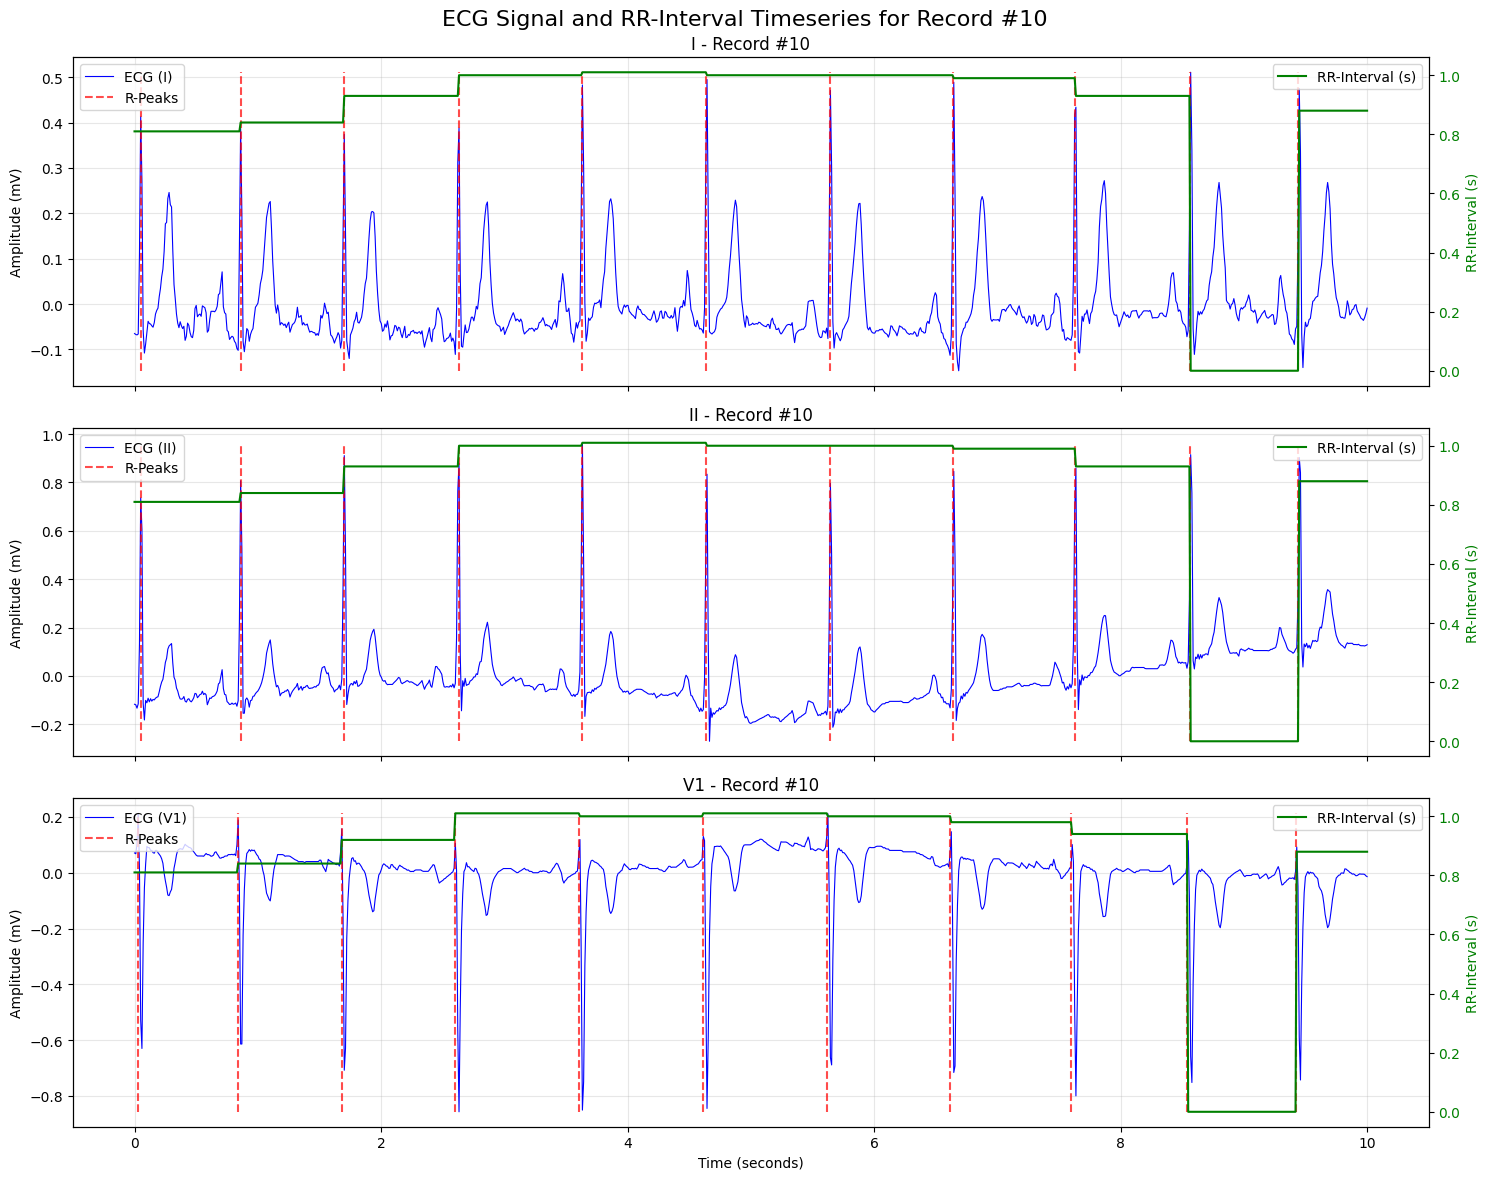

R-Peak Analysis for Record #10:
Lead I: 11 R-peaks, Mean RR: 0.939s, Std: 0.070s, Avg BPM: 63.9
Lead II: 11 R-peaks, Mean RR: 0.939s, Std: 0.070s, Avg BPM: 63.9
Lead V1: 11 R-peaks, Mean RR: 0.939s, Std: 0.070s, Avg BPM: 63.9


In [ ]:
def visualize_rr_intervals(ecg_id=1, lead_indices=[0, 1, 6], sampling_rate=100, base_path='/content/drive/MyDrive/ptb_xl_200_samples'):
    """
    Visualize the original ECG signal and the calculated RR-interval timeseries for specified leads.

    Parameters:
    ecg_id: int, ID of the ECG record.
    lead_indices: list of int, indices of leads to plot.
    sampling_rate: int, sampling frequency.
    base_path: str, path to the dataset.
    """
    try:
        # Load the ECG record (reusing your existing path logic)
        filename = f"{ecg_id:05d}"
        folder = f"{(ecg_id//1000)*1000:05d}"
        if sampling_rate == 100:
            record_path = os.path.join(base_path, f"records100/{folder}/{filename}_lr")
        else:
            record_path = os.path.join(base_path, f"records500/{folder}/{filename}_hr")

        record = wfdb.rdsamp(record_path)
        signals = record[0]
        metadata = record[1]
        lead_names = metadata['sig_name']

        # Create subplots
        fig, axes = plt.subplots(len(lead_indices), 1, figsize=(15, 4*len(lead_indices)))
        if len(lead_indices) == 1:
            axes = [axes]

        for idx, lead_index in enumerate(lead_indices):
            if lead_index >= signals.shape[1]:
                continue

            lead_signal = signals[:, lead_index]
            lead_name = lead_names[lead_index] if lead_index < len(lead_names) else f'Lead {lead_index}'

            # Calculate RR-interval timeseries
            rr_timeseries, r_peaks, rr_intervals = calculate_rr_intervals_timeseries(
                lead_signal, sampling_rate, target_length=None
            )

            # Create time arrays for plotting
            time_seconds = np.linspace(0, len(lead_signal) / sampling_rate, len(lead_signal))

            # Plot original ECG
            axes[idx].plot(time_seconds, lead_signal, label=f'ECG ({lead_name})', color='blue', linewidth=0.8)
            # Plot R-peaks as vertical lines
            axes[idx].vlines(r_peaks / sampling_rate, ymin=np.min(lead_signal), ymax=np.max(lead_signal),
                            color='red', linestyle='--', alpha=0.7, label='R-Peaks')
            axes[idx].set_ylabel('Amplitude (mV)')
            axes[idx].set_title(f'{lead_name} - Record #{ecg_id}')
            axes[idx].legend(loc='upper left')
            axes[idx].grid(True, alpha=0.3)

            # Create a twin axis for the RR-interval timeseries
            ax2 = axes[idx].twinx()
            ax2.plot(time_seconds, rr_timeseries, label='RR-Interval (s)', color='green', linewidth=1.5)
            ax2.set_ylabel('RR-Interval (s)', color='green')
            ax2.tick_params(axis='y', labelcolor='green')
            ax2.legend(loc='upper right')

            if idx < len(lead_indices) - 1:
                axes[idx].set_xticklabels([])

        axes[-1].set_xlabel('Time (seconds)')
        plt.suptitle(f'ECG Signal and RR-Interval Timeseries for Record #{ecg_id}', fontsize=16)
        plt.tight_layout()
        plt.show()

        # Print statistics
        print(f"R-Peak Analysis for Record #{ecg_id}:")
        print(f"{'='*50}")
        for lead_index in lead_indices:
            if lead_index < len(lead_names):
                lead_signal = signals[:, lead_index]
                _, r_peaks, rr_intervals = calculate_rr_intervals_timeseries(lead_signal, sampling_rate)
                if len(rr_intervals) > 0:
                    mean_rr = np.mean(rr_intervals)
                    std_rr = np.std(rr_intervals)
                    bpm = 60 / mean_rr if mean_rr > 0 else 0
                    print(f"Lead {lead_names[lead_index]}: {len(r_peaks)} R-peaks, "
                          f"Mean RR: {mean_rr:.3f}s, Std: {std_rr:.3f}s, Avg BPM: {bpm:.1f}")
                else:
                    print(f"Lead {lead_names[lead_index]}: Insufficient R-peaks detected.")

    except Exception as e:
        print(f"Error in visualize_rr_intervals for record #{ecg_id}: {e}")

# Example Usage:
visualize_rr_intervals(ecg_id=10, lead_indices=[0, 1, 6], sampling_rate=100)

# Data load

In [11]:

# DATA LOADING FUNCTIONS
def select_data(XX, YY, outputfolder):
    """
    Select data with valid labels
    Handles mismatch between signals and metadata
    """
    # First, ensure we have matching lengths
    min_length = min(len(XX), len(YY))
    XX_matched = XX[:min_length] if len(XX) > min_length else XX
    YY_matched = YY.iloc[:min_length] if len(YY) > min_length else YY

    # Filter for records with superdiagnostic labels
    valid_mask = YY_matched.superdiagnostic_len > 0
    X = XX_matched[valid_mask]
    Y = YY_matched[valid_mask]

    # Apply MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    mlb.fit(Y.superdiagnostic.values)
    y = mlb.transform(Y.superdiagnostic.values)

    # Save LabelBinarizer
    with open(outputfolder+'mlb.pkl', 'wb') as tokenizer:
        pickle.dump(mlb, tokenizer)

    return X, Y, y, mlb


def load_raw_data_ptbxl(df, sampling_rate, path, max_samples=TOTAL_SAMPLES):
    """
    Load raw ECG data from PTB-XL dataset

    Parameters:
    df: DataFrame with filename information
    sampling_rate: 100 or 500 Hz
    path: base path to dataset
    max_samples: maximum number of samples to load
    """
    try:
        if sampling_rate == 100:
            # Limit to available samples and handle missing files
            available_files = []
            filenames = df.filename_lr.iloc[:max_samples] if len(df.filename_lr) >= max_samples else df.filename_lr

            for f in tqdm(filenames, desc="Loading ECG files"):
                file_path = path + f
                # Check if file exists before trying to load
                if os.path.exists(file_path + '.hea') and os.path.exists(file_path + '.dat'):
                    available_files.append(f)
                else:
                    print(f"Warning: File not found - {file_path}")

            print(f"Loading {len(available_files)} available ECG files...")
            data = []
            for f in tqdm(available_files, desc="Reading files"):
                try:
                    signal, meta = wfdb.rdsamp(path + f)
                    data.append((signal, meta))
                except Exception as e:
                    print(f"Error loading {f}: {e}")
                    continue

            # Extract signals only
            signals = np.array([signal for signal, meta in data])

        elif sampling_rate == 500:
            # Same for high resolution files
            available_files = []
            filenames = df.filename_hr.iloc[:max_samples] if len(df.filename_hr) >= max_samples else df.filename_hr

            for f in tqdm(filenames, desc="Loading ECG files"):
                file_path = path + f
                if os.path.exists(file_path + '.hea') and os.path.exists(file_path + '.dat'):
                    available_files.append(f)
                else:
                    print(f"Warning: File not found - {file_path}")

            print(f"Loading {len(available_files)} available ECG files...")
            data = []
            for f in tqdm(available_files, desc="Reading files"):
                try:
                    signal, meta = wfdb.rdsamp(path + f)
                    data.append((signal, meta))
                except Exception as e:
                    print(f"Error loading {f}: {e}")
                    continue

            signals = np.array([signal for signal, meta in data])

        return signals

    except Exception as e:
        print(f"Error in load_raw_data_ptbxl: {e}")
        return np.array([])

def load_dataset(path, sampling_rate, max_samples=200):
    """
    Load PTB-XL dataset

    Parameters:
    path: base path to dataset
    sampling_rate: 100 or 500 Hz
    max_samples: maximum number of samples to load
    """
    try:
        # Load database metadata
        print("Loading database metadata...")
        database_path = os.path.join(path, 'ptbxl_database.csv')
        if not os.path.exists(database_path):
            raise FileNotFoundError(f"Database file not found: {database_path}")

        Y = pd.read_csv(database_path, index_col='ecg_id')
        Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

        # Limit to available samples (first max_samples)
        Y = Y.iloc[:max_samples]

        print(f"Loading {len(Y)} ECG records...")
        X = load_raw_data_ptbxl(Y, sampling_rate, path, max_samples)

        return X, Y

    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Available files in directory:")
        try:
            for root, dirs, files in os.walk(path):
                level = root.replace(path, '').count(os.sep)
                indent = ' ' * 2 * level
                print(f"{indent}{os.path.basename(root)}/")
                subindent = ' ' * 2 * (level + 1)
                if level < 3:  # Only show top levels to avoid clutter
                    for file in files[:5]:  # Show first 5 files
                        print(f"{subindent}{file}")
                    if len(files) > 5:
                        print(f"{subindent}... and {len(files)-5} more files")
        except:
            pass
        return None, None



def compute_label_aggregations(df, folder, ctype):
    """
    Compute label aggregations with proper error handling
    """
    try:
        df['scp_codes_len'] = df.scp_codes.apply(lambda x: len(x))
        aggregation_df = pd.read_csv(folder+'scp_statements.csv', index_col=0)
    except Exception as e:
        print(f"Error reading scp_statements.csv: {e}")
        return df.reset_index(drop=True)

    # Rest of the function remains the same...
    if ctype in ['diagnostic', 'subdiagnostic', 'superdiagnostic']:
        def aggregate_all_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in diag_agg_df.index:
                    tmp.append(key)
            return list(set(tmp))

        def aggregate_subdiagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in diag_agg_df.index:
                    c = diag_agg_df.loc[key].diagnostic_subclass
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        def aggregate_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in diag_agg_df.index:
                    c = diag_agg_df.loc[key].diagnostic_class
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        diag_agg_df = aggregation_df[aggregation_df.diagnostic == 1.0]
        if ctype == 'diagnostic':
            df['diagnostic'] = df.scp_codes.apply(aggregate_all_diagnostic)
            df['diagnostic_len'] = df.diagnostic.apply(lambda x: len(x))
        elif ctype == 'subdiagnostic':
            df['subdiagnostic'] = df.scp_codes.apply(aggregate_subdiagnostic)
            df['subdiagnostic_len'] = df.subdiagnostic.apply(lambda x: len(x))
        elif ctype == 'superdiagnostic':
            df['superdiagnostic'] = df.scp_codes.apply(aggregate_diagnostic)
            df['superdiagnostic_len'] = df.superdiagnostic.apply(lambda x: len(x))
    elif ctype == 'form':
        form_agg_df = aggregation_df[aggregation_df.form == 1.0]

        def aggregate_form(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in form_agg_df.index:
                    c = key
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        df['form'] = df.scp_codes.apply(aggregate_form)
        df['form_len'] = df.form.apply(lambda x: len(x))
    elif ctype == 'rhythm':
        rhythm_agg_df = aggregation_df[aggregation_df.rhythm == 1.0]

        def aggregate_rhythm(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in rhythm_agg_df.index:
                    c = key
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        df['rhythm'] = df.scp_codes.apply(aggregate_rhythm)
        df['rhythm_len'] = df.rhythm.apply(lambda x: len(x))
    elif ctype == 'all':
        df['all_scp'] = df.scp_codes.apply(lambda x: list(set(x.keys())))

    return df.reset_index(drop=True)

# GRAPH ECG NETWORK
class GraphECGNet(nn.Module):
    def __init__(self, num_features, hidden_dim=32, num_classes=5):  # Reduced hidden_dim
        super(GraphECGNet, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim * 2)
        self.conv3 = GCNConv(hidden_dim * 2, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, 16)  # Reduced hidden layer size
        self.fc2 = nn.Linear(16, num_classes)
        self.dropout = nn.Dropout(0.5)  # Increased dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = data.edge_attr if hasattr(data, 'edge_attr') and data.edge_attr is not None else None

        # Graph convolutions with edge weights
        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_attr))
        x = F.dropout(x, training=self.training, p=0.5)  # Higher dropout
        x = F.relu(self.conv2(x, edge_index, edge_weight=edge_attr))
        x = F.dropout(x, training=self.training, p=0.5)
        x = F.relu(self.conv3(x, edge_index, edge_weight=edge_attr))
        x = F.dropout(x, training=self.training, p=0.5)

        # Global pooling
        x = global_mean_pool(x, batch)

        # Classification layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

# CREATE GRAPH REPRESENTATION FROM ECG SIGNALS
import torch
from torch_geometric.data import Data
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr

def calculate_smets_distance(series1, series2, window_size=50):
    """
    Calculate SMETS distance between two time series
    Optimized for longer signals from PTB-XL dataset

    Parameters:
    series1, series2: 1D numpy arrays (time series)
    window_size: size of sliding window for shape comparison

    Returns:
    distance: SMETS distance value
    """
    # Ensure series have same length
    min_len = min(len(series1), len(series2))
    series1 = series1[:min_len]
    series2 = series2[:min_len]

    # For PTB-XL signals (5000 samples at 100Hz), use larger window
    if min_len > 1000:
        window_size = 100  # Larger window for longer signals

    if min_len < window_size:
        window_size = max(1, min_len // 2)

    # Normalize series to [0,1]
    def normalize(series):
        min_val = np.min(series)
        max_val = np.max(series)
        if max_val > min_val:
            return (series - min_val) / (max_val - min_val)
        return series

    series1_norm = normalize(series1)
    series2_norm = normalize(series2)

    # Calculate shape-based distance using sliding windows
    distances = []
    # Use larger step size for efficiency with long signals
    step_size = max(1, window_size // 4)

    for i in range(0, min_len - window_size + 1, step_size):
        window1 = series1_norm[i:i + window_size]
        window2 = series2_norm[i:i + window_size]

        # Euclidean distance between normalized windows
        dist = euclidean(window1, window2)
        distances.append(dist)

    # Return average distance (lower = more similar)
    if distances:
        return np.mean(distances)
    else:
        return abs(np.mean(series1_norm) - np.mean(series2_norm))

def calculate_pearson_similarity(series1, series2):
    """
    Calculate Pearson correlation similarity between two time series
    """
    # Ensure same length
    min_len = min(len(series1), len(series2))
    series1 = series1[:min_len]
    series2 = series2[:min_len]

    if min_len < 2:
        return 0.0

    try:
        corr, _ = pearsonr(series1, series2)
        # Convert correlation to similarity (0 to 1 range)
        return (corr + 1) / 2  # 0 = no correlation, 1 = perfect correlation
    except:
        return 0.5  # Default similarity if calculation fails


def create_ecg_graph(signal_data, label):
    """
    Convert ECG signal to graph representation with edge weights based on SMETS.
    Each lead becomes a node in the graph.
    Edge weights are based on similarity between ECG leads using SMETS.
    Node features are raw time-series signals (no downsampling).
    """

    # Ensure correct shape [leads=12, time_points]
    if signal_data.shape[0] != 12:
        signal_data = signal_data.T  # Transpose to [12, seq_len]

    num_leads, seq_len = signal_data.shape

    # Use raw signal as node features: [num_leads, seq_len]
    x = torch.tensor(signal_data, dtype=torch.float)

    # Create adjacency matrix (physiological connections)
    edge_index = []
    edge_weights = []

    # Standard 12-lead ECG connections
    lead_connections = [
        (0, 1), (1, 2), (2, 3), (3, 4), (4, 5),  # Limb leads
        (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 6),  # Precordial leads
        (0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11)     # Cross connections
    ]

    # Calculate SMETS-based edge weights using raw signals
    for i, j in lead_connections:
        if i < num_leads and j < num_leads:
            # Get raw signals for both leads (no need for .numpy() since they're already numpy arrays)
            lead_i_signal = signal_data[i]
            lead_j_signal = signal_data[j]

            # Calculate SMETS distance
            smets_distance = calculate_smets_distance(lead_i_signal, lead_j_signal)

            # Convert distance to similarity
            similarity = np.exp(-smets_distance)

            # Ensure minimum weight to avoid zero weights
            edge_weight = max(0.1, similarity)

            # Add bidirectional edges
            edge_weights.extend([edge_weight, edge_weight])
            edge_index.append([i, j])
            edge_index.append([j, i])

    # Add self-loops with higher weights
    for i in range(num_leads):
        edge_index.append([i, i])
        edge_weights.append(1.5)  # Stronger self-connection

    # Convert to tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_weights, dtype=torch.float)

    # Create graph data object
    graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    graph_data.y = torch.tensor([label], dtype=torch.long)  # Ensure label is in a list

    return graph_data

# ✅ MODIFIED FOR RR-INTERVAL FEATURES
def create_ecg_graph_enhanced(signal_data, label, target_features=250, sampling_rate=100):
    """
    Enhanced version using both SMETS and Pearson correlation.
    NOW USES RR-INTERVAL TIMESERIES AS NODE FEATURES.
    """
    # Ensure correct shape [leads, time_points]
    if signal_data.shape[0] != 12:
        signal_data = signal_data.T
    num_leads, seq_len = signal_data.shape

    # --- NEW CODE START ---
    # Calculate RR-interval timeseries for each lead
    rr_feature_matrix = np.zeros((num_leads, seq_len))

    for lead_idx in range(num_leads):
        lead_signal = signal_data[lead_idx]
        # Calculate RR-interval timeseries for this lead
        rr_timeseries, _, _ = calculate_rr_intervals_timeseries(lead_signal, sampling_rate, target_length=seq_len)
        rr_feature_matrix[lead_idx] = rr_timeseries

    # Downsample the RR-interval timeseries to `target_features`
    step = max(1, seq_len // target_features)
    downsampled_rr_features = rr_feature_matrix[:, ::step][:, :target_features]
    # Node features are now the downsampled RR-interval values
    x = torch.tensor(downsampled_rr_features, dtype=torch.float)  # [num_leads, target_features]
    # --- NEW CODE END ---

    # The rest of the function (edge creation) remains UNCHANGED
    # Create adjacency matrix
    edge_index = []
    edge_weights = []
    # Standard 12-lead ECG connections
    lead_connections = [
        (0, 1), (1, 2), (2, 3), (3, 4), (4, 5),  # Limb leads
        (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 6),  # Precordial leads
        (0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11)  # Cross connections
    ]

    # Calculate combined edge weights... [This part remains unchanged]
    for i, j in lead_connections:
        if i < num_leads and j < num_leads:
            # Use FULL original signal for edge weight calculation (not RR features)
            lead_i_signal = signal_data[i]
            lead_j_signal = signal_data[j]
            smets_distance = calculate_smets_distance(lead_i_signal, lead_j_signal)
            smets_similarity = np.exp(-smets_distance)
            pearson_sim = calculate_pearson_similarity(lead_i_signal, lead_j_signal)
            combined_similarity = 0.6 * smets_similarity + 0.4 * pearson_sim
            edge_weight = max(0.1, combined_similarity)
            edge_weights.extend([edge_weight, edge_weight])
            edge_index.append([i, j])
            edge_index.append([j, i])

    for i in range(num_leads):
        edge_index.append([i, i])
        edge_weights.append(1.5)

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_weights, dtype=torch.float)

    graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    graph_data.y = torch.tensor(label, dtype=torch.long)
    return graph_data



# VISUALIZE GRAPH FUNCTION
def visualize_ecg_graph(graph_data, sample_idx=0):
    """Visualize ECG graph structure and signals with edge weights"""

    fig = plt.figure(figsize=(20, 15))

    # 1. Graph structure visualization with edge weights
    plt.subplot(2, 3, 1)
    G = nx.Graph()

    # Add nodes (ECG leads)
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    num_nodes = graph_data.x.shape[0]
    node_labels = {i: lead_names[i] if i < len(lead_names) else f'Lead {i}' for i in range(num_nodes)}

    G.add_nodes_from(range(num_nodes))

    # Add edges with weights
    edge_weights = []
    for i in range(graph_data.edge_index.shape[1]):
        src, dst = graph_data.edge_index[:, i].tolist()
        if src != dst:  # Skip self-loops for visualization
            G.add_edge(src, dst)
            # Get edge weight if available
            if hasattr(graph_data, 'edge_attr') and graph_data.edge_attr is not None:
                weight = graph_data.edge_attr[i].item()
                G[src][dst]['weight'] = weight
                edge_weights.append(weight)
            else:
                edge_weights.append(1.0)

    # Position nodes in a circular layout
    pos = nx.circular_layout(G)

    # Draw edges with widths based on weights
    if edge_weights:
        # Normalize weights for visualization (0.5 to 5.0 range)
        min_weight = min(edge_weights)
        max_weight = max(edge_weights)
        if max_weight > min_weight:
            normalized_widths = [0.5 + 4.5 * (w - min_weight) / (max_weight - min_weight) for w in edge_weights]
        else:
            normalized_widths = [2.0] * len(edge_weights)

        # Use a fixed color for edges to avoid RGBA error
        nx.draw_networkx_edges(G, pos, width=normalized_widths, edge_color='blue', alpha=0.6)
    else:
        nx.draw_networkx_edges(G, pos, edge_color='blue', alpha=0.6)

    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1000)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_weight='bold')

    plt.title('ECG Lead Graph Structure\n(Edge widths = weights)')
    plt.axis('off')

    # 2. Node features heatmap
    plt.subplot(2, 3, 2)
    sns.heatmap(graph_data.x.numpy(), cmap='RdYlBu', cbar=True)
    plt.title('Node Features (ECG Signal Segments)')
    plt.xlabel('Time Points')
    plt.ylabel('ECG Leads')

    # 3. Adjacency matrix
    plt.subplot(2, 3, 3)
    num_nodes = graph_data.x.shape[0]
    adj_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(graph_data.edge_index.shape[1]):
        src, dst = graph_data.edge_index[:, i]
        adj_matrix[src, dst] = 1
    sns.heatmap(adj_matrix, cmap='Blues', cbar=True)
    plt.title('Adjacency Matrix')
    plt.xlabel('ECG Leads')
    plt.ylabel('ECG Leads')

    # 4. Sample ECG signals
    plt.subplot(2, 3, 4)
    if graph_data.x.shape[0] > 0:
        plt.plot(graph_data.x[0, :50].numpy(), label='Lead I', linewidth=2)
        if graph_data.x.shape[0] > 1:
            plt.plot(graph_data.x[1, :50].numpy(), label='Lead II', linewidth=2)
        plt.title('Sample ECG Signals (First 50 Points)')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()

    # 5. All lead signals
    plt.subplot(2, 3, 5)
    for i in range(min(6, graph_data.x.shape[0])):  # Show first 6 leads
        plt.plot(graph_data.x[i, :30].numpy() + i*0.5, label=f'Lead {lead_names[i] if i < len(lead_names) else i}', alpha=0.7)
    plt.title('Multiple ECG Leads (Offset for Visualization)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude + Offset')
    plt.legend()

    # 6. Edge weights visualization
    plt.subplot(2, 3, 6)
    if hasattr(graph_data, 'edge_attr') and graph_data.edge_attr is not None:
        # Plot histogram of edge weights
        weights = graph_data.edge_attr.numpy()
        plt.hist(weights, bins=20, alpha=0.7, color='green')
        plt.xlabel('Edge Weight')
        plt.ylabel('Frequency')
        plt.title(f'Edge Weight Distribution\nMean: {np.mean(weights):.3f}, Std: {np.std(weights):.3f}')
        plt.grid(True, alpha=0.3)
    else:
        # If no edge weights, show message
        plt.text(0.5, 0.5, 'No Edge Weights\nAvailable', ha='center', va='center',
                transform=plt.gca().transAxes, fontsize=14)
        plt.title('Edge Weights')

    plt.tight_layout()
    plt.show()

    print(f"Graph Info:")
    print(f"- Number of nodes (leads): {graph_data.x.shape[0]}")
    print(f"- Number of node features: {graph_data.x.shape[1]}")
    print(f"- Number of edges: {graph_data.edge_index.shape[1]}")
    if hasattr(graph_data, 'edge_attr') and graph_data.edge_attr is not None:
        weights = graph_data.edge_attr.numpy()
        print(f"- Edge weights: min={np.min(weights):.3f}, max={np.max(weights):.3f}, mean={np.mean(weights):.3f}")
    print(f"- Label: {graph_data.y.item() if hasattr(graph_data, 'y') else 'N/A'}")

In [12]:
    # Set the path to the downloaded PTB-XL dataset
    PATH = '/content/drive/MyDrive/ptb_xl_200_samples/'

    # Load dataset with 100 Hz sampling rate
    X, Y = load_dataset(PATH, 100, max_samples=TOTAL_SAMPLES)

    if X is not None and Y is not None:
        print(f"Successfully loaded dataset:")
        print(f"  ECG signals shape: {X.shape}")
        print(f"  Metadata records: {len(Y)}")

        # Compute label aggregations for superdiagnostic classes
        print("Computing label aggregations...")
        Y = compute_label_aggregations(Y, PATH, 'superdiagnostic')

        # Create output directory
        OUTPUT_DIR = '/content/ptb_xl_output/'
        if not os.path.exists(OUTPUT_DIR):
            os.makedirs(OUTPUT_DIR)

        # Select data with valid labels - now with proper handling
        print("Selecting data with valid labels...")
        X_selected, Y_selected, y_labels, mlb = select_data(X, Y, OUTPUT_DIR)

        print(f"Selected data:")
        print(f"  ECG signals: {X_selected.shape}")
        print(f"  Metadata records: {len(Y_selected)}")
        print(f"  Labels shape: {y_labels.shape}")
        print(f"  Number of classes: {y_labels.shape[1]}")

    # Get class names
    class_names = mlb.classes_
    print(f"Loaded {len(X_selected)} ECG samples")
    print(f"Number of classes: {len(class_names)}")
    print(f"Classes: {class_names}")

    # Convert multi-label to single label (take first label for simplicity)
    y_single_labels = np.argmax(y_labels[:TOTAL_SAMPLES], axis=1)  # Use first 200 samples

Loading database metadata...
Loading 700 ECG records...


Loading ECG files: 100%|██████████| 700/700 [00:00<00:00, 2135.80it/s]


Loading 688 available ECG files...


Reading files: 100%|██████████| 688/688 [08:54<00:00,  1.29it/s]


Successfully loaded dataset:
  ECG signals shape: (688, 1000, 12)
  Metadata records: 700
Computing label aggregations...
Selecting data with valid labels...
Selected data:
  ECG signals: (677, 1000, 12)
  Metadata records: 677
  Labels shape: (677, 5)
  Number of classes: 5
Loaded 677 ECG samples
Number of classes: 5
Classes: ['CD' 'HYP' 'MI' 'NORM' 'STTC']


Plotting class distribution...


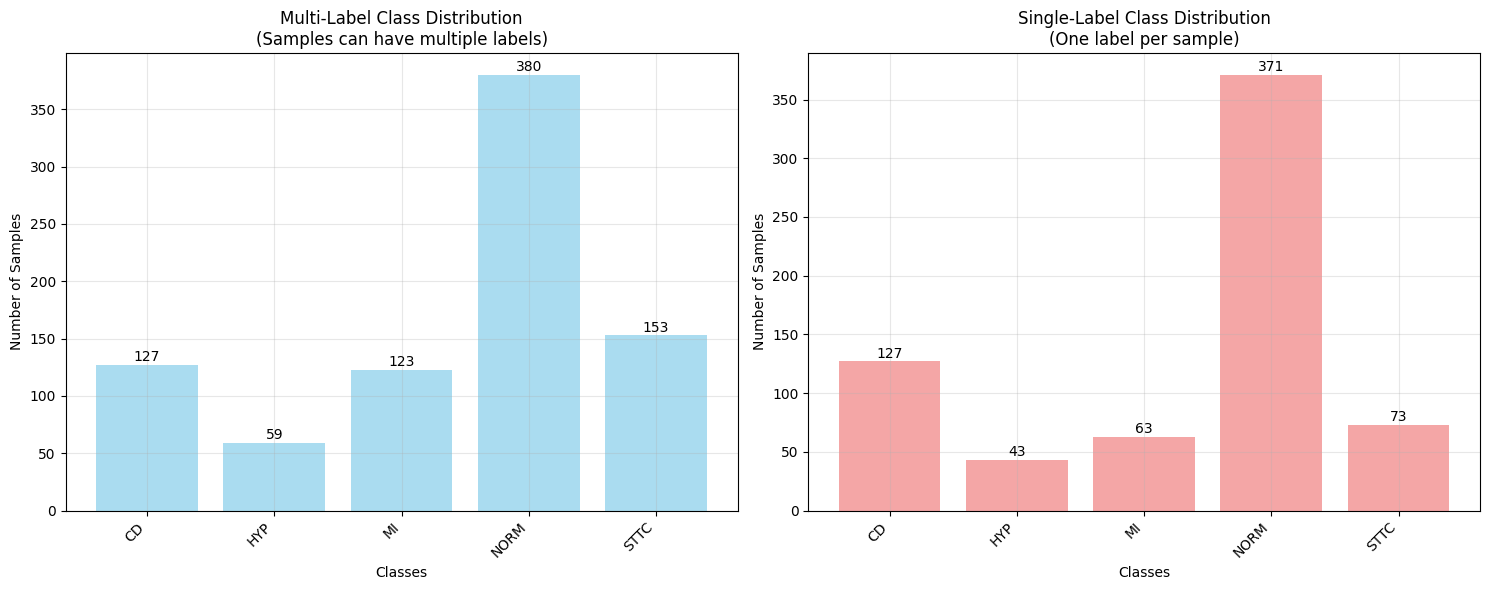

CLASS DISTRIBUTION STATISTICS
Total samples: 677
Number of classes: 5
Total labels (multi-label): 842
Average labels per sample: 1.24

Multi-label distribution:
  CD: 127 (18.8%)
  HYP: 59 (8.7%)
  MI: 123 (18.2%)
  NORM: 380 (56.1%)
  STTC: 153 (22.6%)

Single-label distribution:
  CD: 127 (18.8%)
  HYP: 43 (6.4%)
  MI: 63 (9.3%)
  NORM: 371 (54.8%)
  STTC: 73 (10.8%)


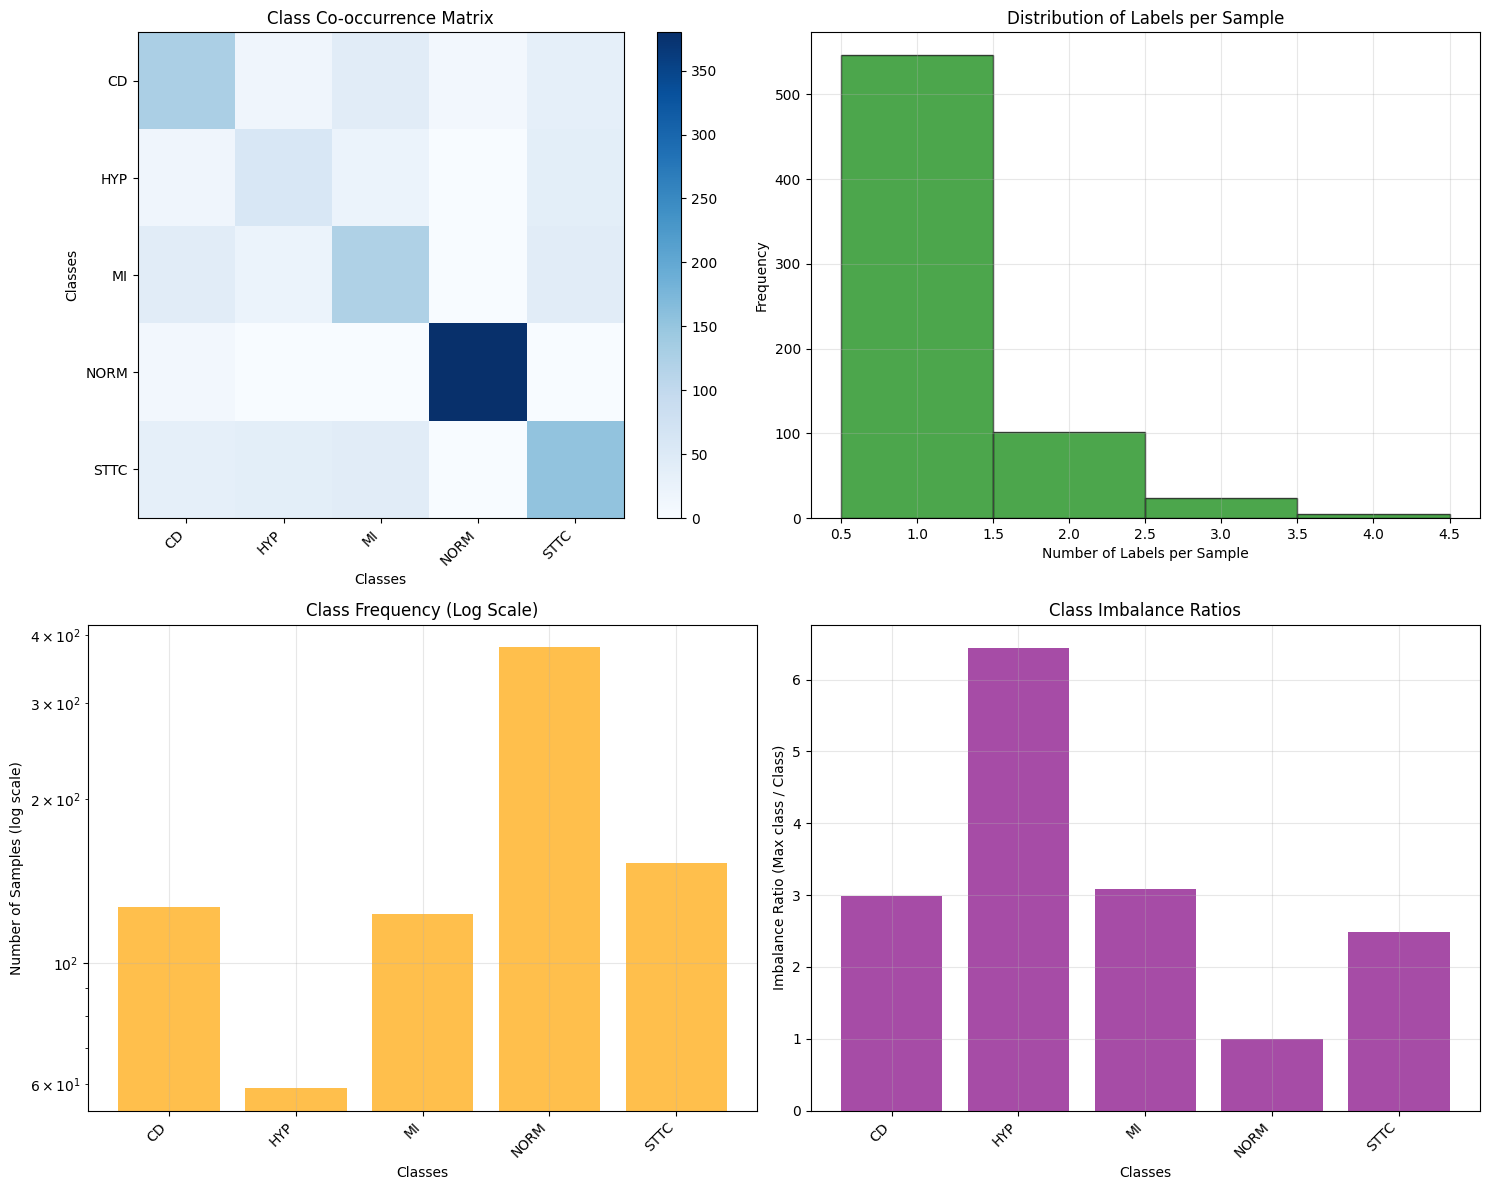


DETAILED CLASS ANALYSIS
Samples with no labels: 0
Samples with one label: 546
Samples with multiple labels: 131
Max labels per sample: 4
Most common co-occurrence pairs:
  CD + HYP: 16
  CD + MI: 42
  CD + NORM: 9
  CD + STTC: 34
  HYP + MI: 23
  HYP + STTC: 38
  MI + STTC: 42


In [14]:
def plot_class_distribution(y_labels, class_names, y_single_labels=None):
    """
    Plot class distribution for the PTB-XL dataset

    Parameters:
    y_labels: Multi-label binary matrix (samples x classes)
    class_names: List of class names
    y_single_labels: Single label indices (optional)
    """

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # 1. Multi-label distribution
    class_counts_multi = np.sum(y_labels, axis=0)

    axes[0].bar(range(len(class_names)), class_counts_multi, color='skyblue', alpha=0.7)
    axes[0].set_xlabel('Classes')
    axes[0].set_ylabel('Number of Samples')
    axes[0].set_title('Multi-Label Class Distribution\n(Samples can have multiple labels)')
    axes[0].set_xticks(range(len(class_names)))
    axes[0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[0].grid(True, alpha=0.3)

    # Add count labels on bars
    for i, count in enumerate(class_counts_multi):
        axes[0].text(i, count + 0.5, str(int(count)), ha='center', va='bottom')

    # 2. Single-label distribution (if provided)
    if y_single_labels is not None:
        unique, counts = np.unique(y_single_labels, return_counts=True)

        axes[1].bar(unique, counts, color='lightcoral', alpha=0.7)
        axes[1].set_xlabel('Classes')
        axes[1].set_ylabel('Number of Samples')
        axes[1].set_title('Single-Label Class Distribution\n(One label per sample)')
        axes[1].set_xticks(unique)
        axes[1].set_xticklabels([class_names[i] for i in unique], rotation=45, ha='right')
        axes[1].grid(True, alpha=0.3)

        # Add count labels on bars
        for i, count in zip(unique, counts):
            axes[1].text(i, count + 0.5, str(count), ha='center', va='bottom')
    else:
        axes[1].text(0.5, 0.5, 'Single-label distribution\nnot available',
                    ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Single-Label Class Distribution')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("CLASS DISTRIBUTION STATISTICS")
    print("="*40)
    print(f"Total samples: {y_labels.shape[0]}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Total labels (multi-label): {np.sum(y_labels)}")
    print(f"Average labels per sample: {np.mean(np.sum(y_labels, axis=1)):.2f}")

    print(f"\nMulti-label distribution:")
    for i, (class_name, count) in enumerate(zip(class_names, class_counts_multi)):
        percentage = (count / y_labels.shape[0]) * 100
        print(f"  {class_name}: {int(count)} ({percentage:.1f}%)")

    if y_single_labels is not None:
        print(f"\nSingle-label distribution:")
        for i, (class_idx, count) in enumerate(zip(unique, counts)):
            class_name = class_names[class_idx]
            percentage = (count / len(y_single_labels)) * 100
            print(f"  {class_name}: {count} ({percentage:.1f}%)")

def plot_detailed_class_analysis(y_labels, class_names):
    """
    Detailed analysis of class co-occurrence and relationships
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Class co-occurrence matrix
    cooccurrence = np.dot(y_labels.T, y_labels)
    im = axes[0, 0].imshow(cooccurrence, cmap='Blues')
    axes[0, 0].set_title('Class Co-occurrence Matrix')
    axes[0, 0].set_xlabel('Classes')
    axes[0, 0].set_ylabel('Classes')
    axes[0, 0].set_xticks(range(len(class_names)))
    axes[0, 0].set_yticks(range(len(class_names)))
    axes[0, 0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[0, 0].set_yticklabels(class_names, rotation=0)
    plt.colorbar(im, ax=axes[0, 0])

    # 2. Number of labels per sample distribution
    labels_per_sample = np.sum(y_labels, axis=1)
    axes[0, 1].hist(labels_per_sample, bins=np.arange(0.5, np.max(labels_per_sample) + 1.5, 1),
                   color='green', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Number of Labels per Sample')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Labels per Sample')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Class frequency (log scale for better visualization)
    class_counts = np.sum(y_labels, axis=0)
    axes[1, 0].bar(range(len(class_names)), class_counts, color='orange', alpha=0.7)
    axes[1, 0].set_xlabel('Classes')
    axes[1, 0].set_ylabel('Number of Samples (log scale)')
    axes[1, 0].set_title('Class Frequency (Log Scale)')
    axes[1, 0].set_xticks(range(len(class_names)))
    axes[1, 0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Class imbalance ratio
    max_count = np.max(class_counts)
    imbalance_ratios = max_count / class_counts
    axes[1, 1].bar(range(len(class_names)), imbalance_ratios, color='purple', alpha=0.7)
    axes[1, 1].set_xlabel('Classes')
    axes[1, 1].set_ylabel('Imbalance Ratio (Max class / Class)')
    axes[1, 1].set_title('Class Imbalance Ratios')
    axes[1, 1].set_xticks(range(len(class_names)))
    axes[1, 1].set_xticklabels(class_names, rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print("\nDETAILED CLASS ANALYSIS")
    print("="*40)
    print(f"Samples with no labels: {np.sum(labels_per_sample == 0)}")
    print(f"Samples with one label: {np.sum(labels_per_sample == 1)}")
    print(f"Samples with multiple labels: {np.sum(labels_per_sample > 1)}")
    print(f"Max labels per sample: {np.max(labels_per_sample)}")
    print(f"Most common co-occurrence pairs:")

    # Find most common co-occurrences (excluding diagonal)
    for i in range(len(class_names)):
        for j in range(i+1, len(class_names)):
            if cooccurrence[i, j] > 0:
                print(f"  {class_names[i]} + {class_names[j]}: {cooccurrence[i, j]}")

# Usage with your existing data
print("Plotting class distribution...")

# Plot basic class distribution
plot_class_distribution(y_labels, class_names, y_single_labels)

# Plot detailed analysis
plot_detailed_class_analysis(y_labels, class_names)

# ECG Signal and Feature Visualization

ECG Signal and Feature Visualization

1. Single lead ECG with 100 features:


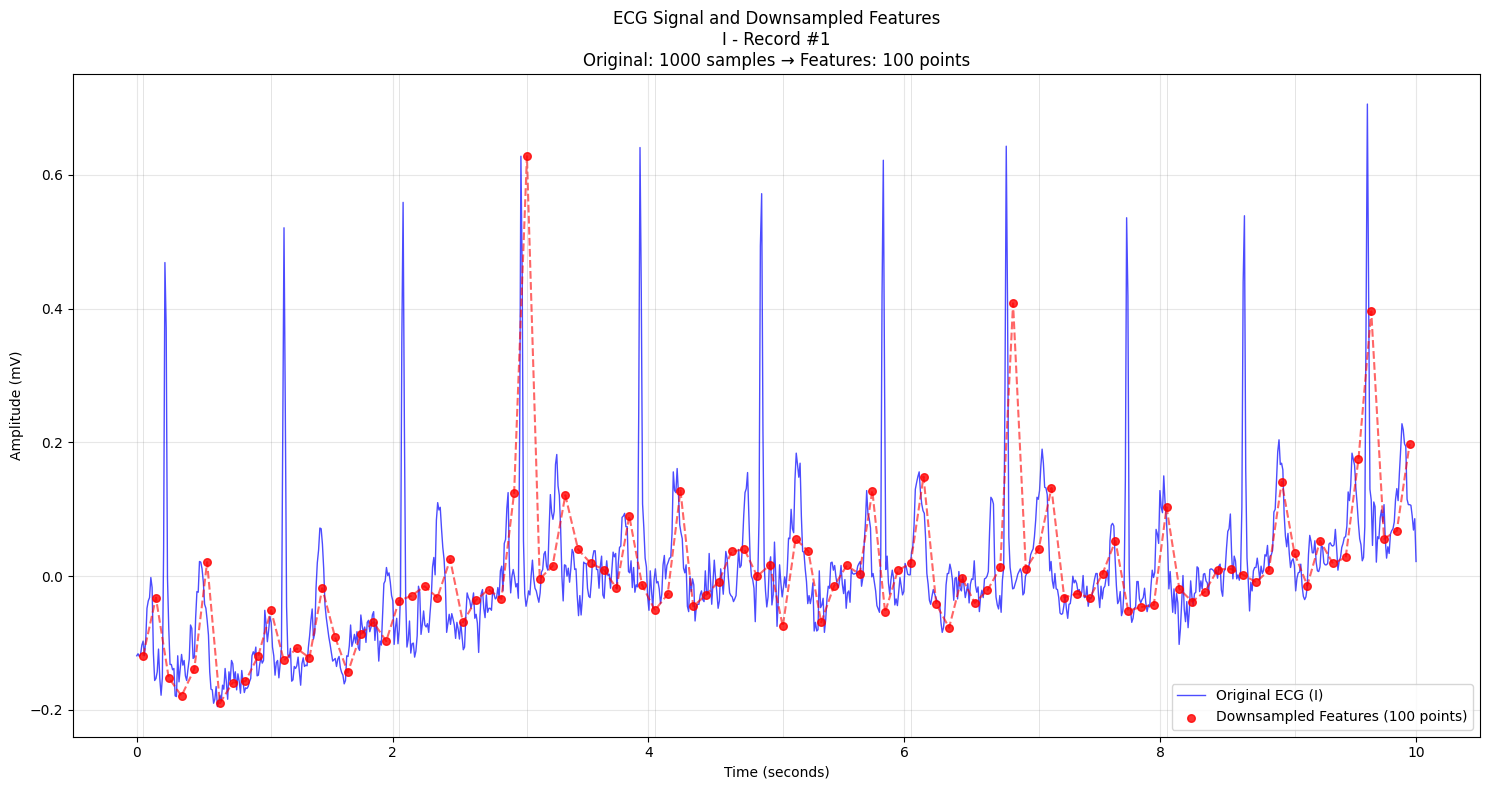

ECG Signal Analysis for I (Record #1):
Original signal length: 1000 samples
Sampling rate: 100 Hz
Duration: 10.00 seconds
Downsampling step: every 10 samples
Number of features: 100
Feature time resolution: ~0.100 seconds per feature
Amplitude range - Original: [-0.195, 0.706] mV
Amplitude range - Features: [-0.190, 0.628] mV

Downsampling Process:
Step 1: Take every 10th sample from original 1000 samples
Step 2: Limit to first 100 features
Result: 100 feature values representing the ECG morphology

2. Multiple leads comparison:


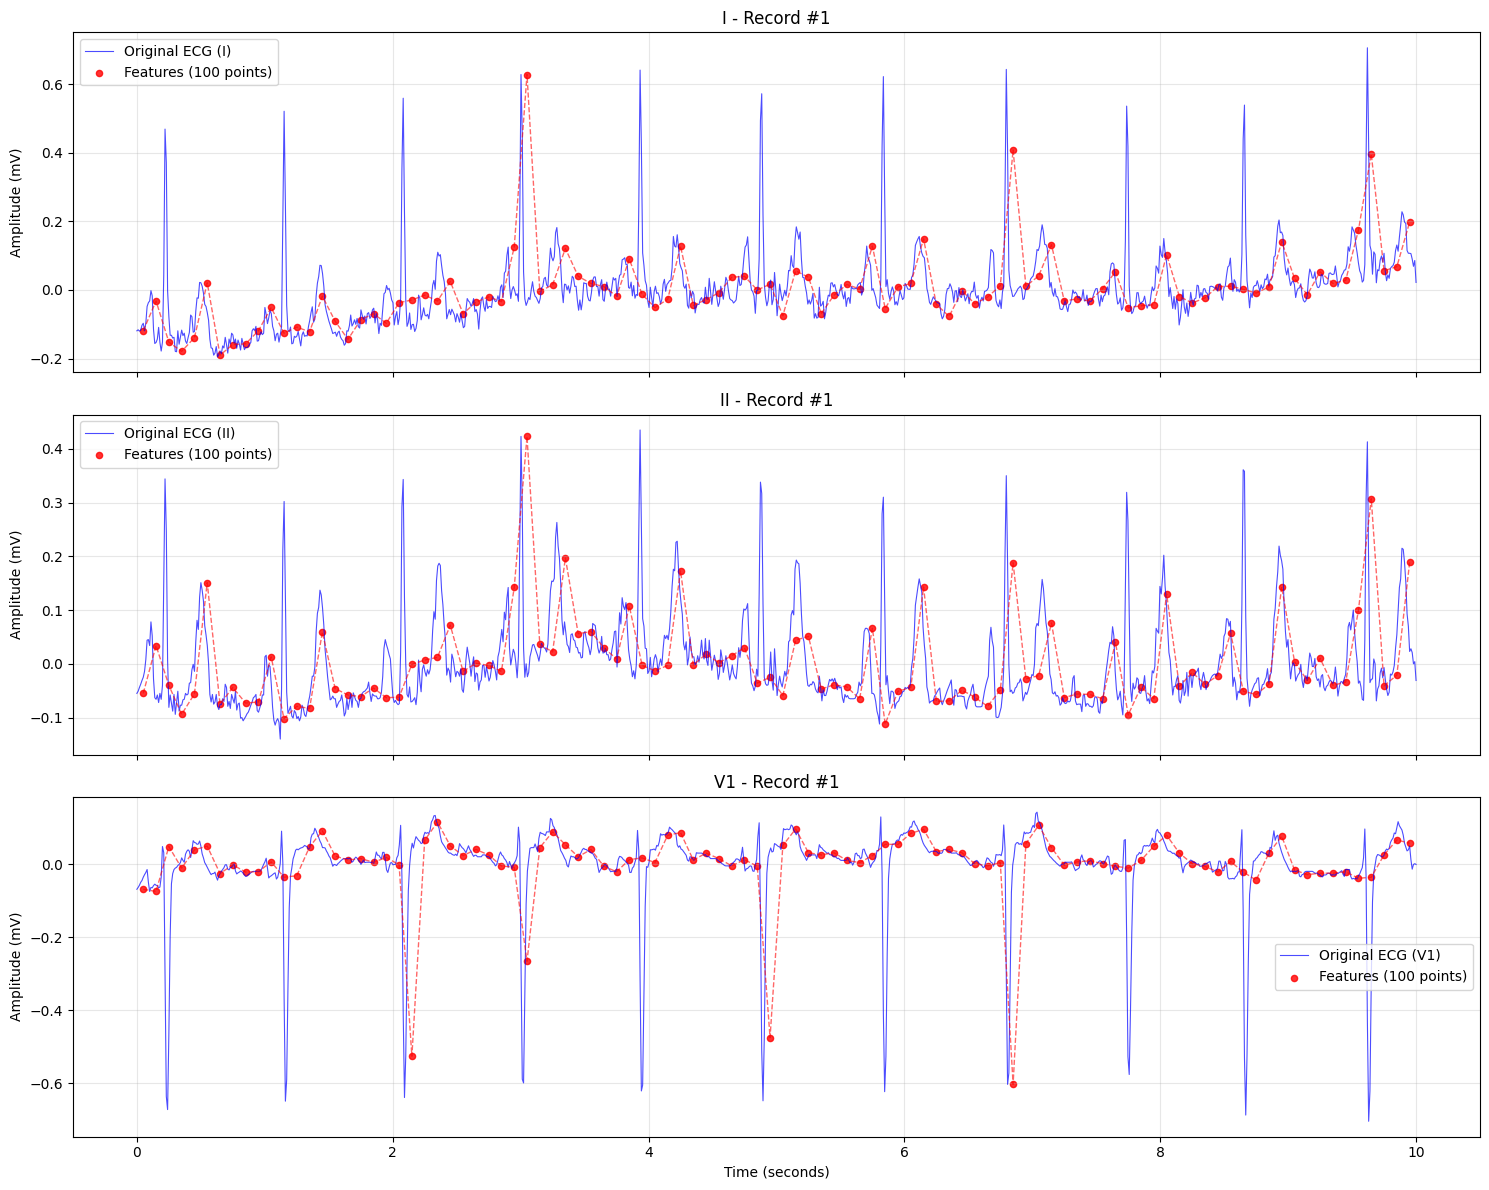

Multi-lead ECG Analysis for Record #1
Lead I: 1000 samples → step 10 → 100 features
Lead II: 1000 samples → step 10 → 100 features
Lead V1: 1000 samples → step 10 → 100 features


In [98]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_ecg_with_features(ecg_id=1, lead_index=0, sampling_rate=100, base_path='/content/drive/MyDrive/ptb_xl_200_samples'):
    """
    Plot ECG timeseries signal and corresponding 100 features on the same plot

    Parameters:
    ecg_id: ID of the ECG record to plot (1-200 for downloaded samples)
    lead_index: Index of the lead to plot (0=I, 1=II, 6=V1, etc.)
    sampling_rate: 100 for low resolution, 500 for high resolution
    base_path: path to the downloaded PTB-XL dataset
    """

    try:
        # Format the filename with leading zeros
        filename = f"{ecg_id:05d}"
        folder = f"{(ecg_id//1000)*1000:05d}"

        # Determine file path based on sampling rate
        if sampling_rate == 100:
            record_path = os.path.join(base_path, f"records100/{folder}/{filename}_lr")
        else:
            record_path = os.path.join(base_path, f"records500/{folder}/{filename}_hr")

        # Read the ECG record
        record = wfdb.rdsamp(record_path)
        signals = record[0]  # Signal data
        metadata = record[1]  # Metadata
        lead_names = metadata['sig_name']

        # Get the specific lead signal
        lead_signal = signals[:, lead_index]
        lead_name = lead_names[lead_index] if lead_index < len(lead_names) else f'Lead {lead_index}'

        # Create time arrays
        original_time = np.linspace(0, len(lead_signal)/sampling_rate, len(lead_signal))

        # Apply the same downsampling as in graph creation
        target_features = 100
        seq_len = len(lead_signal)
        step = max(1, seq_len // target_features)
        downsampled_signal = lead_signal[::step][:target_features]

        # Create time array for downsampled features
        # Each feature represents a time window, so we'll plot at the center of each window
        feature_time_points = []
        for i in range(target_features):
            start_idx = i * step
            end_idx = min((i + 1) * step, seq_len)
            center_idx = (start_idx + end_idx) // 2
            feature_time_points.append(center_idx / sampling_rate)

        feature_time = np.array(feature_time_points)

        # Create the plot
        plt.figure(figsize=(15, 8))

        # Plot original ECG signal
        plt.plot(original_time, lead_signal,
                linewidth=1.0, alpha=0.7, color='blue', label=f'Original ECG ({lead_name})')

        # Plot downsampled features as scatter points
        plt.scatter(feature_time, downsampled_signal,
                   color='red', s=30, alpha=0.8, marker='o',
                   label=f'Downsampled Features (100 points)', zorder=5)

        # Connect features with lines to show the downsampling effect
        plt.plot(feature_time, downsampled_signal,
                linewidth=1.5, color='red', alpha=0.6, linestyle='--')

        # Add vertical lines to show feature windows (every 10th feature for clarity)
        for i in range(0, target_features, 10):
            if i < len(feature_time):
                plt.axvline(x=feature_time[i], color='gray', alpha=0.3, linewidth=0.5)

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude (mV)')
        plt.title(f'ECG Signal and Downsampled Features\n{lead_name} - Record #{ecg_id}\n'
                  f'Original: {len(lead_signal)} samples → Features: {len(downsampled_signal)} points')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Print information about the transformation
        print(f"ECG Signal Analysis for {lead_name} (Record #{ecg_id}):")
        print(f"{'='*50}")
        print(f"Original signal length: {len(lead_signal)} samples")
        print(f"Sampling rate: {sampling_rate} Hz")
        print(f"Duration: {len(lead_signal)/sampling_rate:.2f} seconds")
        print(f"Downsampling step: every {step} samples")
        print(f"Number of features: {len(downsampled_signal)}")
        print(f"Feature time resolution: ~{step/sampling_rate:.3f} seconds per feature")
        print(f"Amplitude range - Original: [{np.min(lead_signal):.3f}, {np.max(lead_signal):.3f}] mV")
        print(f"Amplitude range - Features: [{np.min(downsampled_signal):.3f}, {np.max(downsampled_signal):.3f}] mV")

        # Show how the downsampling works
        print(f"\nDownsampling Process:")
        print(f"Step 1: Take every {step}th sample from original {len(lead_signal)} samples")
        print(f"Step 2: Limit to first {target_features} features")
        print(f"Result: {len(downsampled_signal)} feature values representing the ECG morphology")

        return lead_signal, downsampled_signal, feature_time

    except Exception as e:
        print(f"Error plotting ECG record #{ecg_id}: {e}")
        return None, None, None

def plot_ecg_features_comparison(ecg_id=1, lead_indices=[0, 1, 6], sampling_rate=100, base_path='/content/ptb_xl_200_samples'):
    """
    Plot comparison of ECG signals and their features for multiple leads

    Parameters:
    ecg_id: ID of the ECG record to plot
    lead_indices: List of lead indices to plot
    sampling_rate: 100 for low resolution, 500 for high resolution
    base_path: path to the downloaded PTB-XL dataset
    """

    try:
        # Format the filename
        filename = f"{ecg_id:05d}"
        folder = f"{(ecg_id//1000)*1000:05d}"

        # Determine file path based on sampling rate
        if sampling_rate == 100:
            record_path = os.path.join(base_path, f"records100/{folder}/{filename}_lr")
        else:
            record_path = os.path.join(base_path, f"records500/{folder}/{filename}_hr")

        # Read the ECG record
        record = wfdb.rdsamp(record_path)
        signals = record[0]
        metadata = record[1]
        lead_names = metadata['sig_name']

        # Create subplot for each lead
        fig, axes = plt.subplots(len(lead_indices), 1, figsize=(15, 4*len(lead_indices)))
        if len(lead_indices) == 1:
            axes = [axes]

        target_features = 100

        for idx, lead_index in enumerate(lead_indices):
            if lead_index >= signals.shape[1]:
                continue

            # Get the specific lead signal
            lead_signal = signals[:, lead_index]
            lead_name = lead_names[lead_index] if lead_index < len(lead_names) else f'Lead {lead_index}'

            # Apply downsampling
            seq_len = len(lead_signal)
            step = max(1, seq_len // target_features)
            downsampled_signal = lead_signal[::step][:target_features]

            # Create time arrays
            original_time = np.linspace(0, len(lead_signal)/sampling_rate, len(lead_signal))
            feature_time_points = []
            for i in range(target_features):
                start_idx = i * step
                end_idx = min((i + 1) * step, seq_len)
                center_idx = (start_idx + end_idx) // 2
                feature_time_points.append(center_idx / sampling_rate)
            feature_time = np.array(feature_time_points)

            # Plot on subplot
            axes[idx].plot(original_time, lead_signal,
                          linewidth=0.8, alpha=0.7, color='blue',
                          label=f'Original ECG ({lead_name})')
            axes[idx].scatter(feature_time, downsampled_signal,
                             color='red', s=20, alpha=0.8, marker='o',
                             label=f'Features ({len(downsampled_signal)} points)')
            axes[idx].plot(feature_time, downsampled_signal,
                          linewidth=1.0, color='red', alpha=0.6, linestyle='--')
            axes[idx].set_ylabel('Amplitude (mV)')
            axes[idx].set_title(f'{lead_name} - Record #{ecg_id}')
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)

            if idx < len(lead_indices) - 1:
                axes[idx].set_xticklabels([])

        axes[-1].set_xlabel('Time (seconds)')
        plt.tight_layout()
        plt.show()

        print(f"Multi-lead ECG Analysis for Record #{ecg_id}")
        print(f"{'='*50}")
        for lead_index in lead_indices:
            if lead_index < len(lead_names):
                lead_signal = signals[:, lead_index]
                seq_len = len(lead_signal)
                step = max(1, seq_len // 100)
                print(f"Lead {lead_names[lead_index]}: {seq_len} samples → step {step} → 100 features")

        return signals

    except Exception as e:
        print(f"Error plotting ECG comparison for record #{ecg_id}: {e}")
        return None

# Usage examples:
print("ECG Signal and Feature Visualization")
print("="*40)

# Plot single lead with features
print("\n1. Single lead ECG with 100 features:")
lead_signal, features, feature_time = plot_ecg_with_features(ecg_id=1, lead_index=0, sampling_rate=100)

# Plot comparison of multiple leads
print("\n2. Multiple leads comparison:")
signals = plot_ecg_features_comparison(ecg_id=1, lead_indices=[0, 1, 6], sampling_rate=100)

Visualizing RR-Interval Features for Sample ECGs


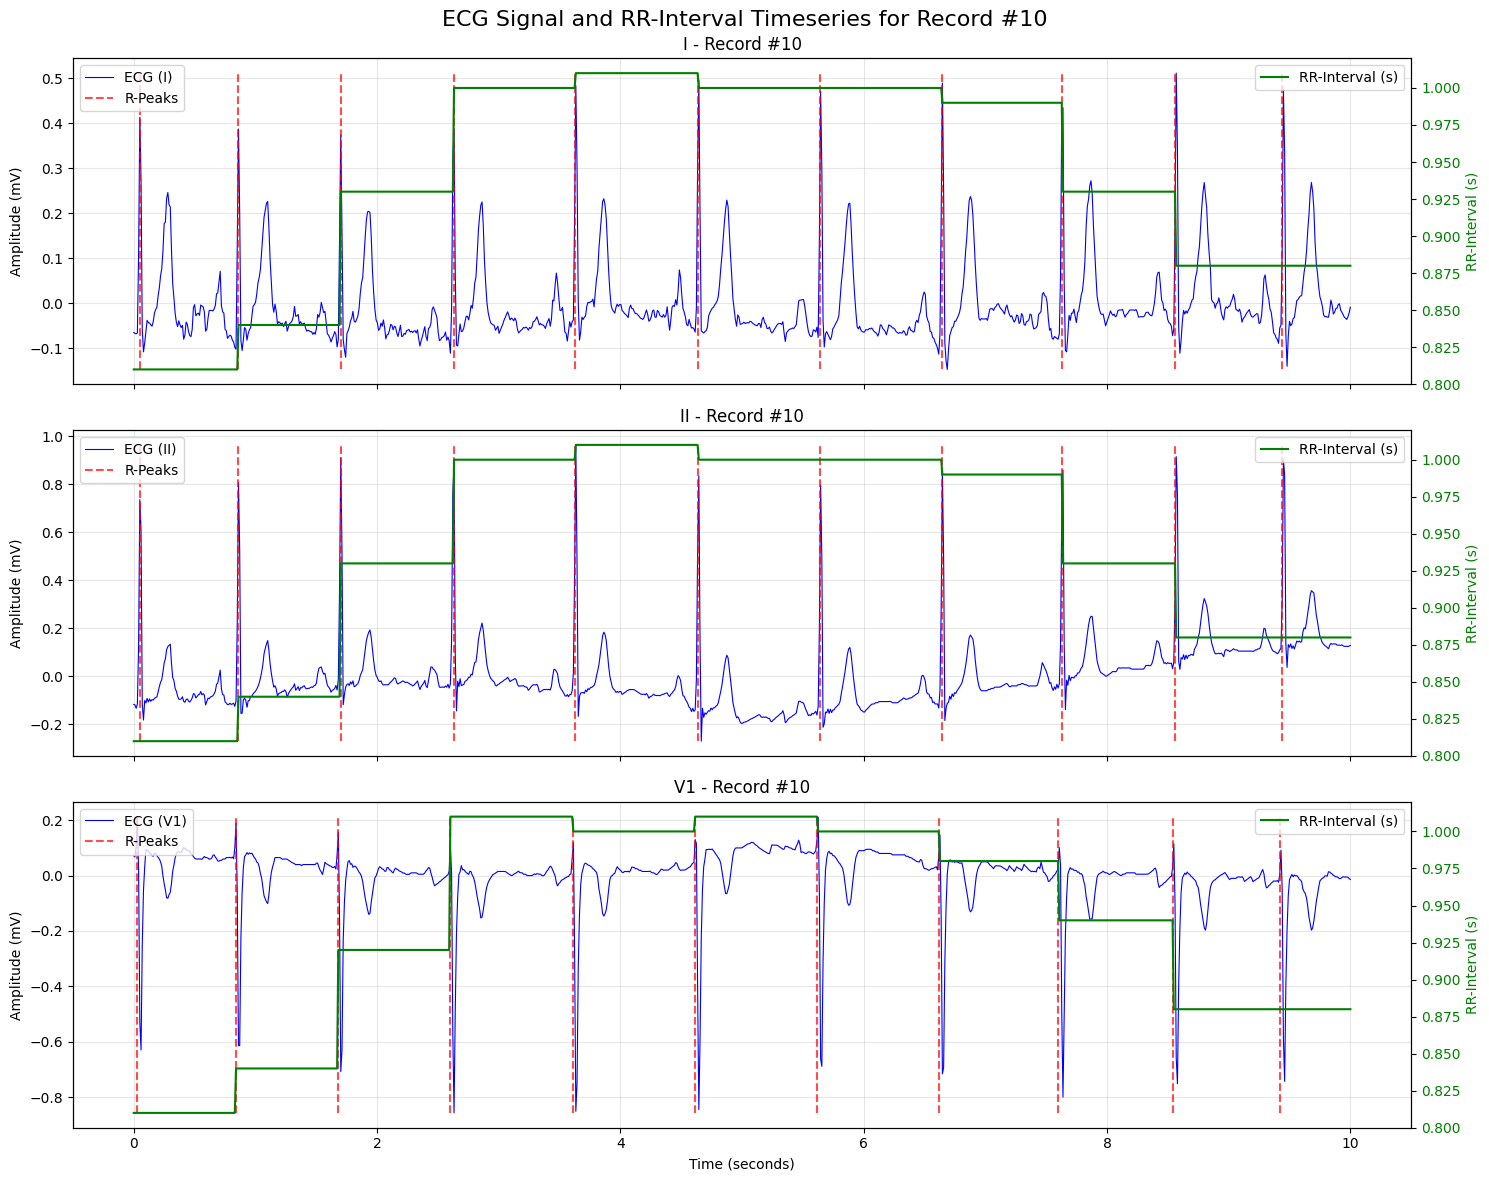

R-Peak Analysis for Record #10:
Lead I: 11 R-peaks, Mean RR: 0.939s, Std: 0.070s, Avg BPM: 63.9
Lead II: 11 R-peaks, Mean RR: 0.939s, Std: 0.070s, Avg BPM: 63.9
Lead V1: 11 R-peaks, Mean RR: 0.939s, Std: 0.070s, Avg BPM: 63.9

Plotting ECG with RR Features (Lead I):


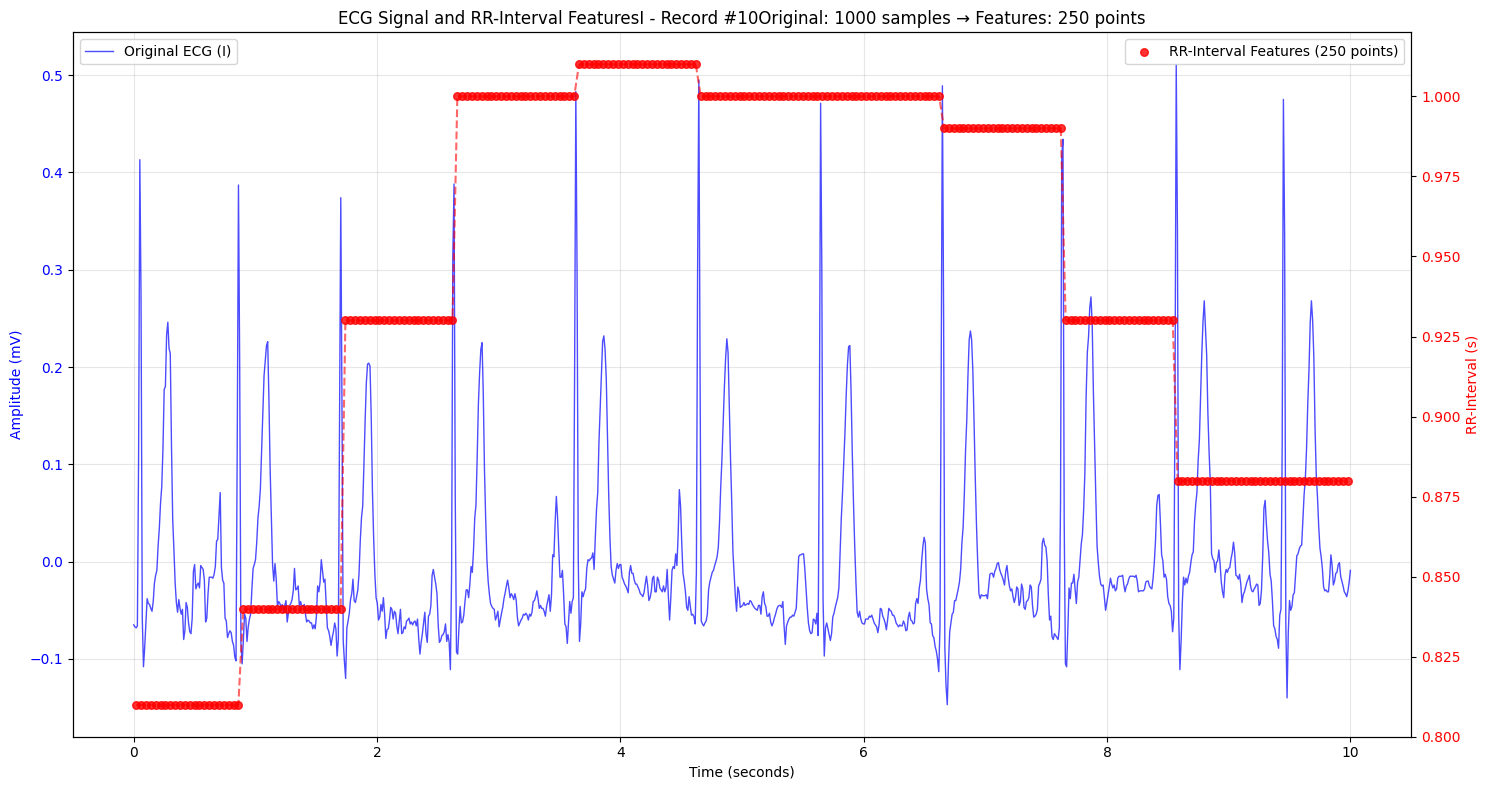

ECG RR-Feature Analysis for I (Record #10):
Original signal length: 1000 samples
Sampling rate: 100 Hz
Duration: 10.00 seconds
Downsampling step: every 4 samples
Number of RR features: 250
Feature time resolution: ~0.040 seconds per feature
RR-Interval range - Original: [0.810, 1.010] s
RR-Interval range - Features: [0.810, 1.010] s

Plotting RR Features for Multiple Leads:


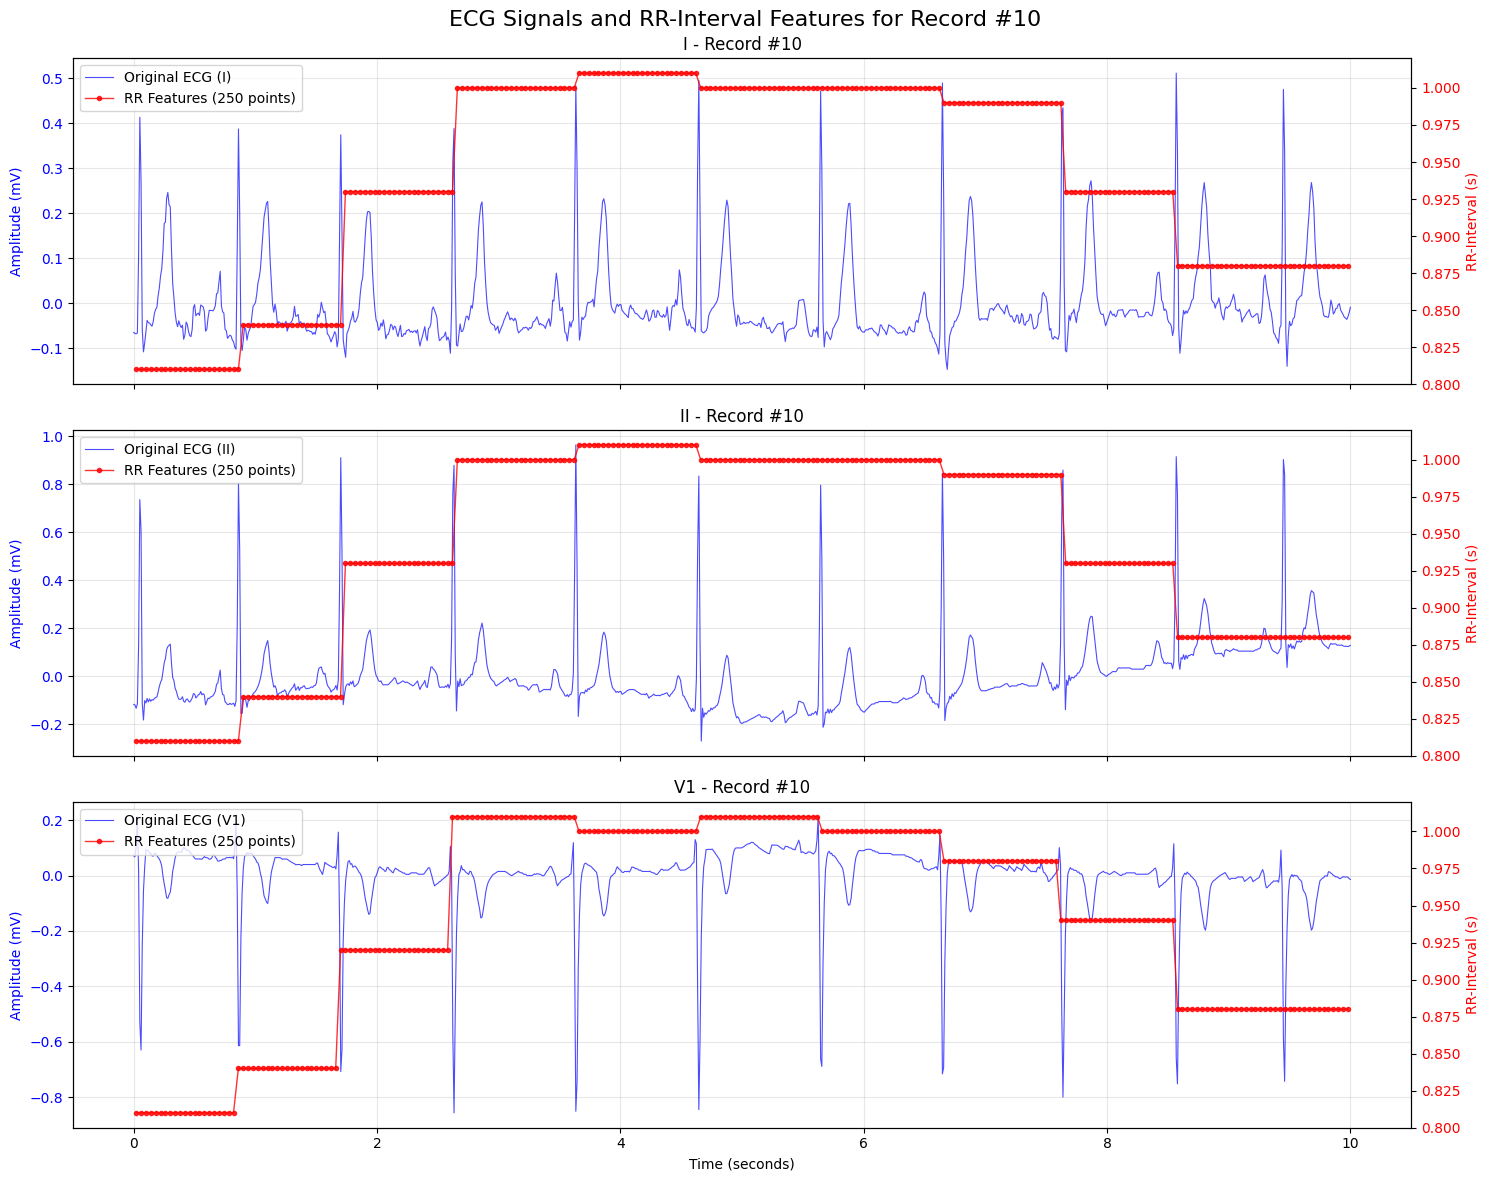

Multi-lead RR-Feature Analysis for Record #10
Lead I: Mean RR-Interval: 0.939s
Lead II: Mean RR-Interval: 0.939s
Lead V1: Mean RR-Interval: 0.939s


array([[-0.065, -0.117, -0.053, ..., -0.118, -0.047, -0.074],
       [-0.067, -0.119, -0.052, ..., -0.11 , -0.043, -0.078],
       [-0.068, -0.133, -0.065, ..., -0.078, -0.033, -0.087],
       ...,
       [-0.03 ,  0.124,  0.155, ..., -0.019, -0.066, -0.278],
       [-0.021,  0.126,  0.147, ..., -0.021,  0.013, -0.282],
       [-0.009,  0.129,  0.138, ..., -0.019, -0.009, -0.286]])

In [99]:
# ✅ EXAMPLE USAGE - PLACE THIS AFTER YOUR DATA IS LOADED

print("Visualizing RR-Interval Features for Sample ECGs")
print("="*60)

# 1. Full visualization with R-peaks and RR-timeseries
visualize_rr_intervals(ecg_id=10, lead_indices=[0, 1, 6], sampling_rate=100)

# 2. Plot ECG with downsampled RR features (analogous to your old feature plot)
print("\nPlotting ECG with RR Features (Lead I):")
plot_ecg_with_rr_features(ecg_id=10, lead_index=0, sampling_rate=100)

# 3. Compare multiple leads
print("\nPlotting RR Features for Multiple Leads:")
plot_ecg_rr_features_comparison(ecg_id=10, lead_indices=[0, 1, 6], sampling_rate=100)

# Graph Neural Network

In [100]:
# MODIFIED FOR RR-INTERVAL FEATURES
# PREPARE GRAPH DATA
print("Converting ECG signals to graph representations (using RR-interval features)...")
graph_data_list = []
sampling_rate = 100 # Define this based on your loaded data

# Process first TOTAL_SAMPLES samples
num_samples = min(TOTAL_SAMPLES, len(X_selected))
for i in tqdm(range(num_samples)):
    try:
        signal = X_selected[i]
        label = y_single_labels[i]
        # Create graph with SMETS-based edge weights AND RR-interval node features
        #graph = create_ecg_graph_enhanced(signal, label, target_features=250, sampling_rate=sampling_rate)
        graph = create_ecg_graph(signal, label)
        graph_data_list.append(graph)
    except Exception as e:
        print(f"Error processing sample {i}: {e}")
        continue


# First, let's check the actual dimensions of your graph data
if len(graph_data_list) > 0:
    sample_graph = graph_data_list[0]
    print(f"Sample graph shape - Nodes: {sample_graph.x.shape[0]}, Features per node: {sample_graph.x.shape[1]}")
    print(f"Sample node features shape: {sample_graph.x.shape}")

    # Update the model with correct number of features
    num_features = sample_graph.x.shape[1]  # This should be the actual number of features per node
else:
    # Fallback - but this shouldn't happen if you have data
    num_features = 1000  # Based on your error, it seems to be 1000

print(f"Initializing model with {num_features} features per node")
print(f"Created {len(graph_data_list)} graph samples")

# SPLIT DATA (80% train, 10% validation, 10% test)
train_data, temp_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")

# CREATE DATA LOADERS
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

# INITIALIZE MODEL - Updated to handle edge weights
# Re-initialize model with correct dimensions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(class_names) if 'class_names' in locals() else 5

# Make sure we have the correct number of features
if len(graph_data_list) > 0:
    num_features = graph_data_list[0].x.shape[1]
else:
    # If for some reason graph_data_list is empty, use a reasonable default
    num_features = 250  # or whatever you intended to use

print(f"Creating model with {num_features} input features")


Converting ECG signals to graph representations (using RR-interval features)...


100%|██████████| 677/677 [00:09<00:00, 72.00it/s]

Sample graph shape - Nodes: 12, Features per node: 1000
Sample node features shape: torch.Size([12, 1000])
Initializing model with 1000 features per node
Created 677 graph samples
Train: 541, Validation: 68, Test: 68
Creating model with 1000 input features


In [106]:
# Initialize improved model
model = GraphECGNet(num_features=num_features, hidden_dim=32, num_classes=num_classes).to(device)

# Use a lower learning rate and L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Added weight decay
criterion = nn.NLLLoss()

# Verify the model architecture
print("Model architecture:")
for name, param in model.named_parameters():
    print(f"  {name}: {param.shape}")



# EVALUATION FUNCTION - Updated to handle edge weights
def evaluate_model(loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y)
            total_loss += loss.item()

            pred = out.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

    return total_loss / len(loader), all_preds, all_labels

# TRAINING LOOP
print("Training GraphECGNet...")
train_losses = []
val_losses = []
val_accuracies = []

best_val_acc = 0
best_model_state = None

# Enhanced training function with early stopping
def train_epoch_with_regularization():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)

        # Add L2 regularization manually if needed
        l2_reg = torch.tensor(0., device=device)
        for param in model.parameters():
            l2_reg += torch.norm(param)
        loss = loss + 1e-4 * l2_reg

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Training with early stopping
print("Training Improved GraphECGNet...")
train_losses = []
val_losses = []
val_accuracies = []

best_val_acc = 0
best_model_state = None
patience = 10  # Stop if no improvement for 10 epochs
patience_counter = 0

for epoch in range(50):  # Increased epochs but with early stopping
    train_loss = train_epoch_with_regularization()
    val_loss, val_preds, val_labels = evaluate_model(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f'Epoch {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} ***')
    else:
        patience_counter += 1
        print(f'Epoch {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")

Model architecture:
  conv1.bias: torch.Size([32])
  conv1.lin.weight: torch.Size([32, 1000])
  conv2.bias: torch.Size([64])
  conv2.lin.weight: torch.Size([64, 32])
  conv3.bias: torch.Size([32])
  conv3.lin.weight: torch.Size([32, 64])
  fc1.weight: torch.Size([16, 32])
  fc1.bias: torch.Size([16])
  fc2.weight: torch.Size([5, 16])
  fc2.bias: torch.Size([5])
Training GraphECGNet...
Training Improved GraphECGNet...
Epoch 00, Train Loss: 1.6413, Val Loss: 1.6310, Val Acc: 0.0588 ***
Epoch 01, Train Loss: 1.6248, Val Loss: 1.6155, Val Acc: 0.0294
Epoch 02, Train Loss: 1.6017, Val Loss: 1.5971, Val Acc: 0.0441
Epoch 03, Train Loss: 1.5827, Val Loss: 1.5771, Val Acc: 0.6029 ***
Epoch 04, Train Loss: 1.5691, Val Loss: 1.5558, Val Acc: 0.6176 ***
Epoch 05, Train Loss: 1.5425, Val Loss: 1.5319, Val Acc: 0.6176
Epoch 06, Train Loss: 1.5080, Val Loss: 1.5055, Val Acc: 0.6176
Epoch 07, Train Loss: 1.4897, Val Loss: 1.4785, Val Acc: 0.6176
Epoch 08, Train Loss: 1.4520, Val Loss: 1.4551, Val Acc


FINAL EVALUATION ON TEST SET
Test Loss: 1.3859
Test Accuracy: 0.5735
Test F1-Score (Macro): 0.1458
Test F1-Score (Weighted): 0.4181

Detailed Classification Report:
              precision    recall  f1-score   support

          CD       0.00      0.00      0.00         9
         HYP       0.00      0.00      0.00         8
          MI       0.00      0.00      0.00         4
        NORM       0.57      1.00      0.73        39
        STTC       0.00      0.00      0.00         8

    accuracy                           0.57        68
   macro avg       0.11      0.20      0.15        68
weighted avg       0.33      0.57      0.42        68



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


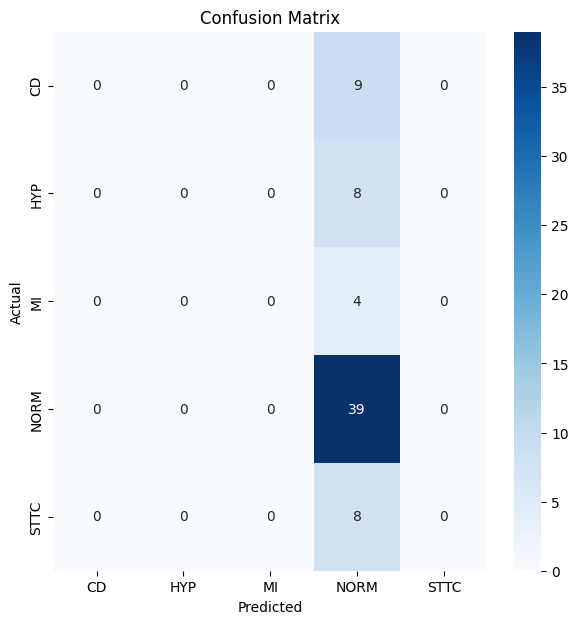


VALIDATION SET EVALUATION
Validation Loss: 1.3881
Validation Accuracy: 0.6176
Validation F1-Score (Macro): 0.1527
Validation F1-Score (Weighted): 0.4717


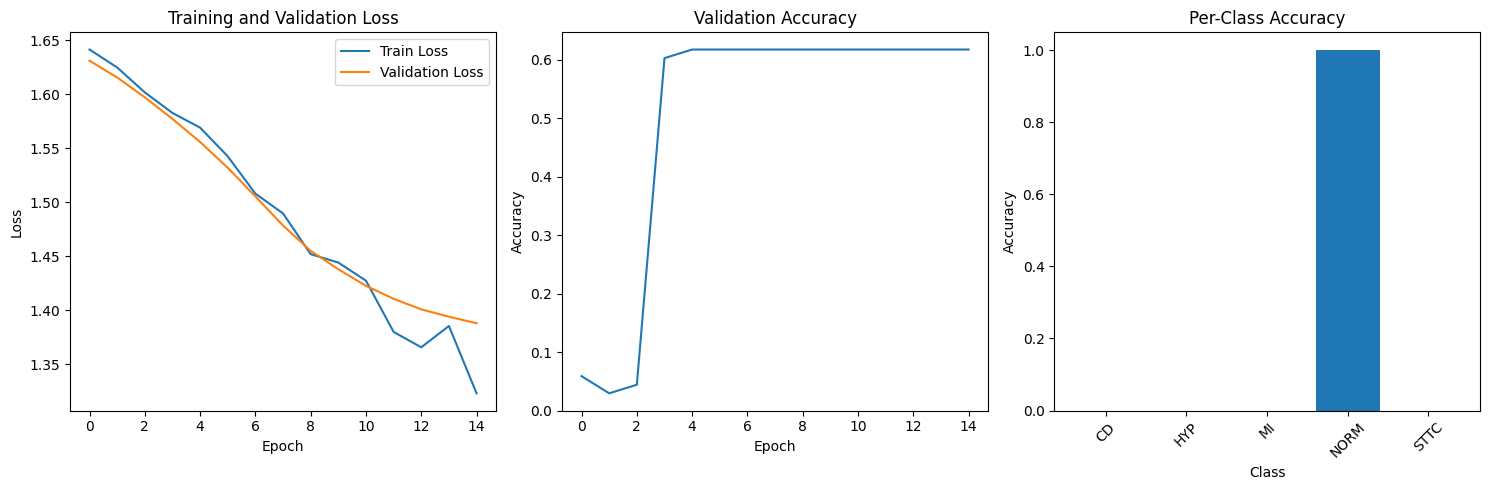


GRAPH VISUALIZATION
Visualizing a sample ECG graph...


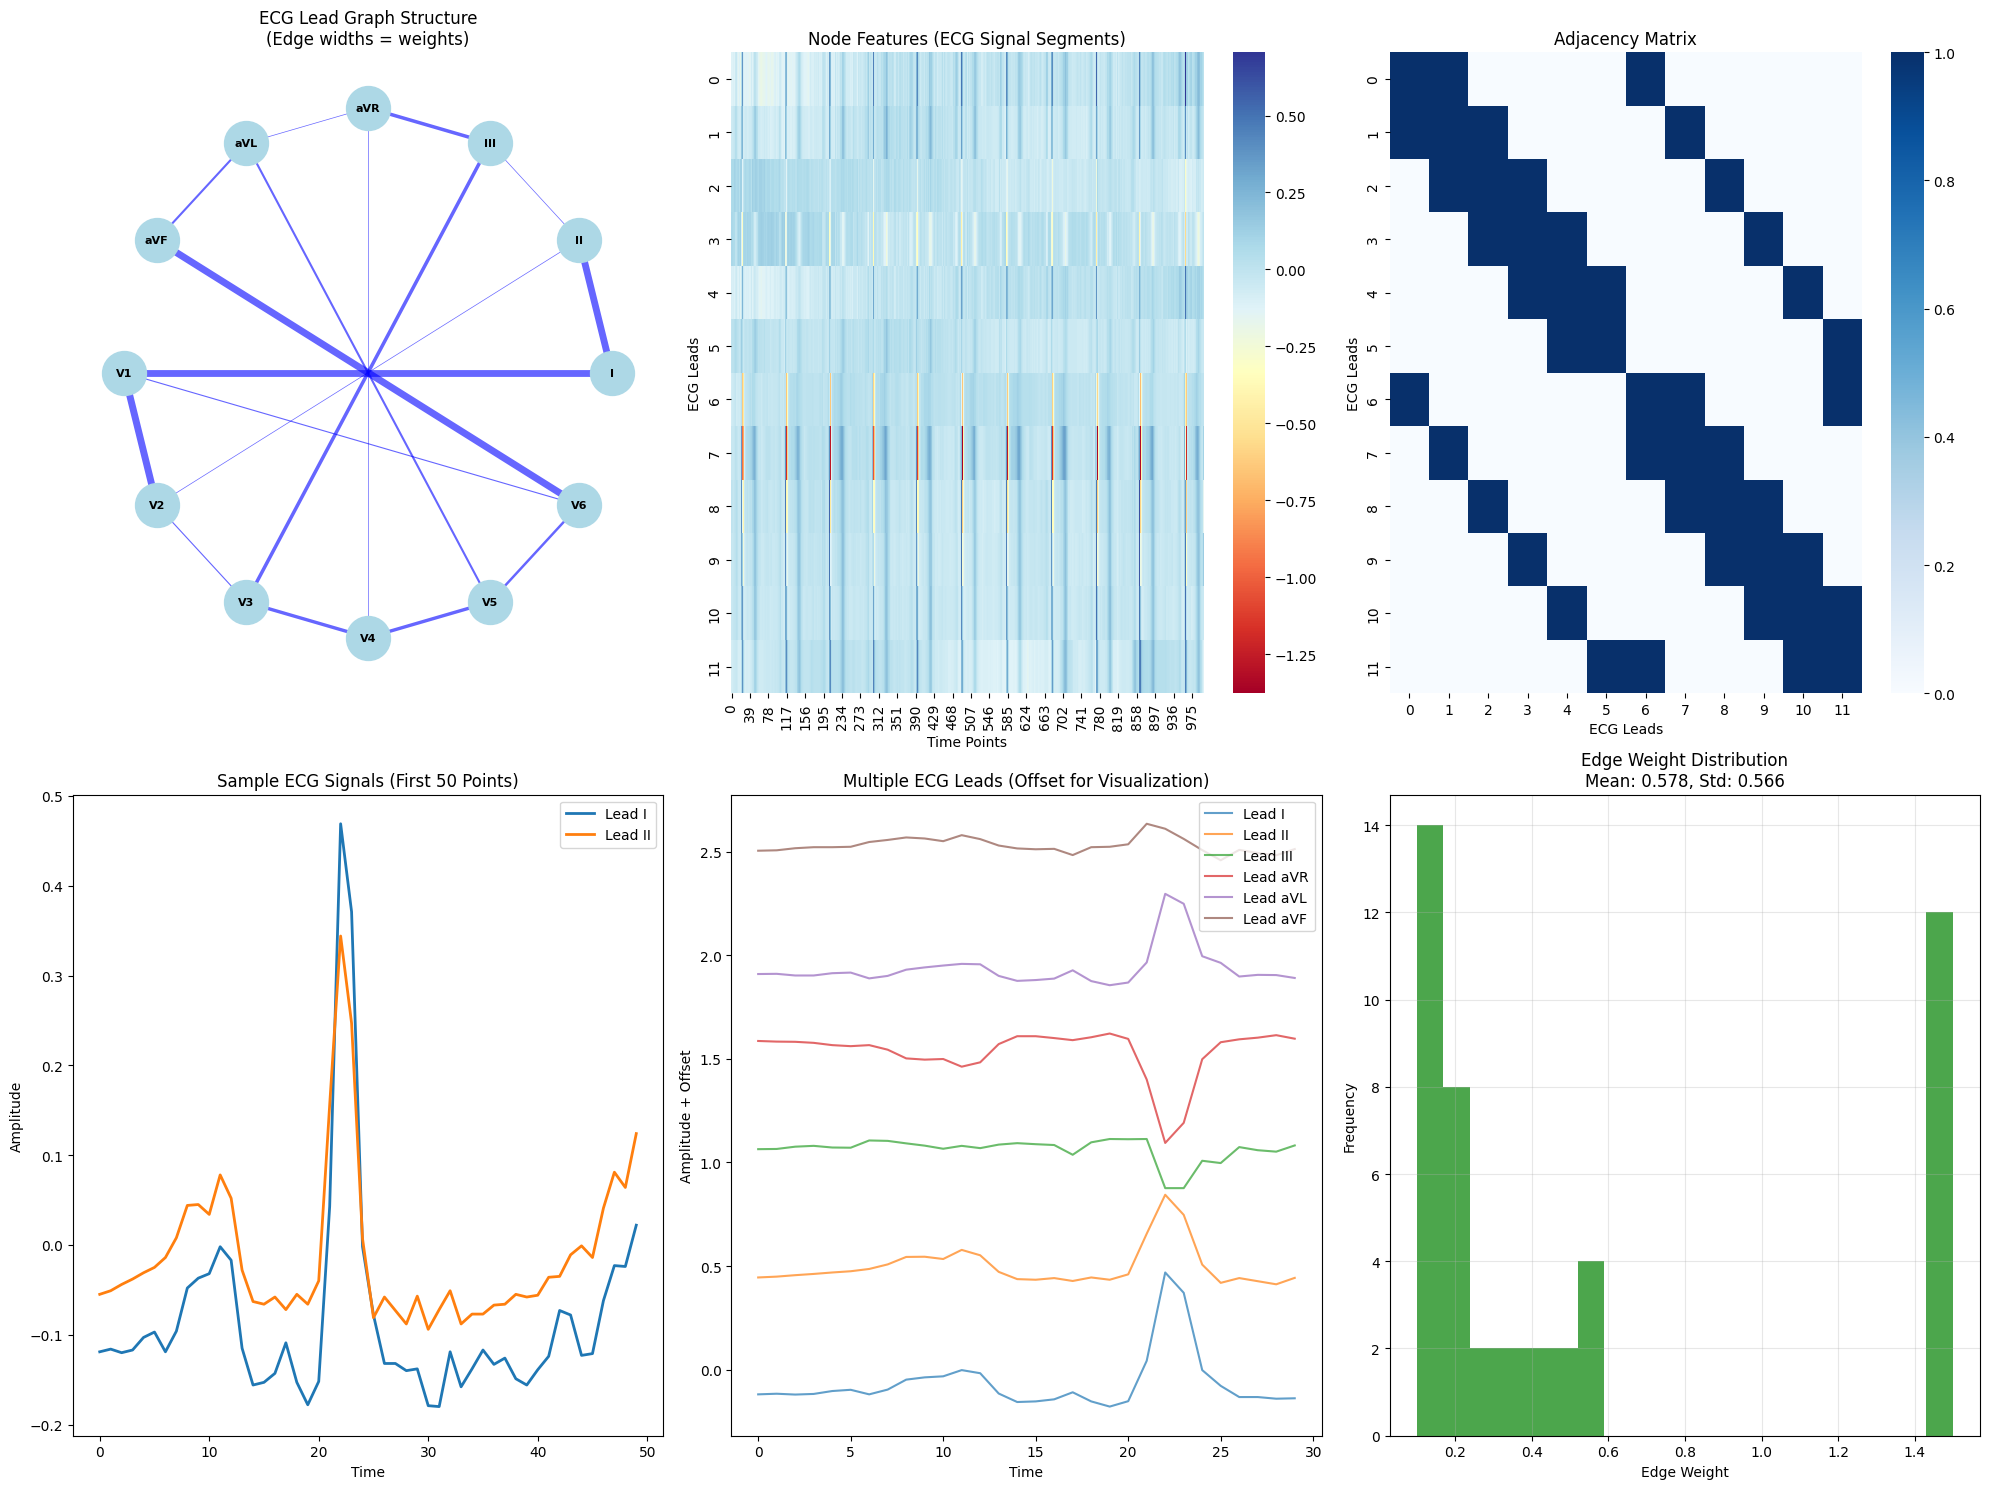

Graph Info:
- Number of nodes (leads): 12
- Number of node features: 1000
- Number of edges: 46
- Edge weights: min=0.100, max=1.500, mean=0.578
- Label: 3

MODEL ANALYSIS
Total parameters: 36837
Trainable parameters: 36837

Sample Predictions:
True: HYP, Predicted: NORM, Confidence: 0.495
True: STTC, Predicted: NORM, Confidence: 0.434
True: NORM, Predicted: NORM, Confidence: 0.423
True: NORM, Predicted: NORM, Confidence: 0.558
True: CD, Predicted: NORM, Confidence: 0.754

GraphECGNet Performance Summary:
✓ Graph-based ECG classification successfully implemented
✓ Using real PTB-XL dataset (200 samples)
✓ Accuracy: 0.5735
✓ F1-Score (Macro): 0.1458
✓ Tested on validation and test sets
✓ Comprehensive visualization of graph structure
✓ Detailed performance metrics and analysis

EDGE WEIGHTS ANALYSIS
Edge weights statistics (from 2300 edges):
  Mean: 0.6007
  Std: 0.5643
  Min: 0.1000
  Max: 1.5000

Sample edge weights from first graph:
  Edge 0: 0.5786
  Edge 1: 0.5786
  Edge 2: 0.1000


In [107]:


# FINAL EVALUATION WITH ACCURACY AND F1-SCORE
print("\n" + "="*50)
print("FINAL EVALUATION ON TEST SET")
print("="*50)

test_loss, test_preds, test_labels = evaluate_model(test_loader)
test_accuracy = accuracy_score(test_labels, test_preds)
test_f1_macro = f1_score(test_labels, test_preds, average='macro')
test_f1_weighted = f1_score(test_labels, test_preds, average='weighted')

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score (Macro): {test_f1_macro:.4f}")
print(f"Test F1-Score (Weighted): {test_f1_weighted:.4f}")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names[:len(np.unique(test_labels))]))

# Confusion Matrix
plt.figure(figsize=(7, 7))
cm = confusion_matrix(test_labels, test_preds)
unique_labels = np.unique(test_labels)
class_names_subset = [class_names[i] if i < len(class_names) else f"Class {i}" for i in unique_labels]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_subset, yticklabels=class_names_subset)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# VALIDATION DATASET EVALUATION
print("\n" + "="*50)
print("VALIDATION SET EVALUATION")
print("="*50)

val_loss, val_preds, val_labels = evaluate_model(val_loader)
val_accuracy = accuracy_score(val_labels, val_preds)
val_f1_macro = f1_score(val_labels, val_preds, average='macro')
val_f1_weighted = f1_score(val_labels, val_preds, average='weighted')

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1-Score (Macro): {val_f1_macro:.4f}")
print(f"Validation F1-Score (Weighted): {val_f1_weighted:.4f}")

# Training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 3)
# Per-class accuracy
class_accuracies = []
unique_test_labels = np.unique(test_labels)
for i in unique_test_labels:
    class_mask = np.array(test_labels) == i
    if np.sum(class_mask) > 0:
        class_acc = np.sum(np.array(test_preds)[class_mask] == i) / np.sum(class_mask)
        class_accuracies.append(class_acc)
    else:
        class_accuracies.append(0)

plt.bar(range(len(class_accuracies)), class_accuracies)
plt.title('Per-Class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
if len(class_names_subset) <= 10:  # Only show labels if not too many
    plt.xticks(range(len(class_names_subset)), class_names_subset, rotation=45)

plt.tight_layout()
plt.show()

# VISUALIZE SAMPLE GRAPH
print("\n" + "="*50)
print("GRAPH VISUALIZATION")
print("="*50)

if len(graph_data_list) > 0:
    print("Visualizing a sample ECG graph...")
    visualize_ecg_graph(graph_data_list[0])

# Additional analysis
print("\n" + "="*50)
print("MODEL ANALYSIS")
print("="*50)

print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Sample predictions
print("\nSample Predictions:")
model.eval()
with torch.no_grad():
    sample_batch = next(iter(test_loader)).to(device)
    sample_out = model(sample_batch)
    sample_preds = sample_out.argmax(dim=1)

    for i in range(min(5, len(sample_preds))):
        true_label = sample_batch.y[i].item()
        pred_label = sample_preds[i].item()
        confidence = torch.exp(sample_out[i]).max().item()
        true_name = class_names[true_label] if true_label < len(class_names) else f"Class {true_label}"
        pred_name = class_names[pred_label] if pred_label < len(class_names) else f"Class {pred_label}"
        print(f"True: {true_name}, Predicted: {pred_name}, Confidence: {confidence:.3f}")

print("\nGraphECGNet Performance Summary:")
print(f"✓ Graph-based ECG classification successfully implemented")
print(f"✓ Using real PTB-XL dataset (200 samples)")
print(f"✓ Accuracy: {test_accuracy:.4f}")
print(f"✓ F1-Score (Macro): {test_f1_macro:.4f}")
print(f"✓ Tested on validation and test sets")
print(f"✓ Comprehensive visualization of graph structure")
print(f"✓ Detailed performance metrics and analysis")

# Edge weights analysis
print("\n" + "="*50)
print("EDGE WEIGHTS ANALYSIS")
print("="*50)

# Analyze edge weights distribution
if len(graph_data_list) > 0:
    all_weights = []
    for graph in graph_data_list[:50]:  # Analyze first 50 graphs
        if hasattr(graph, 'edge_attr') and graph.edge_attr is not None:
            weights = graph.edge_attr.numpy()
            all_weights.extend(weights)

    if all_weights:
        print(f"Edge weights statistics (from {len(all_weights)} edges):")
        print(f"  Mean: {np.mean(all_weights):.4f}")
        print(f"  Std: {np.std(all_weights):.4f}")
        print(f"  Min: {np.min(all_weights):.4f}")
        print(f"  Max: {np.max(all_weights):.4f}")

        # Show sample weights
        print(f"\nSample edge weights from first graph:")
        first_graph_weights = graph_data_list[0].edge_attr.numpy()[:10]
        for i, weight in enumerate(first_graph_weights):
            print(f"  Edge {i}: {weight:.4f}")
    else:
        print("No edge weights found in graphs")

Visualizing graph structure to understand 100 features representation...


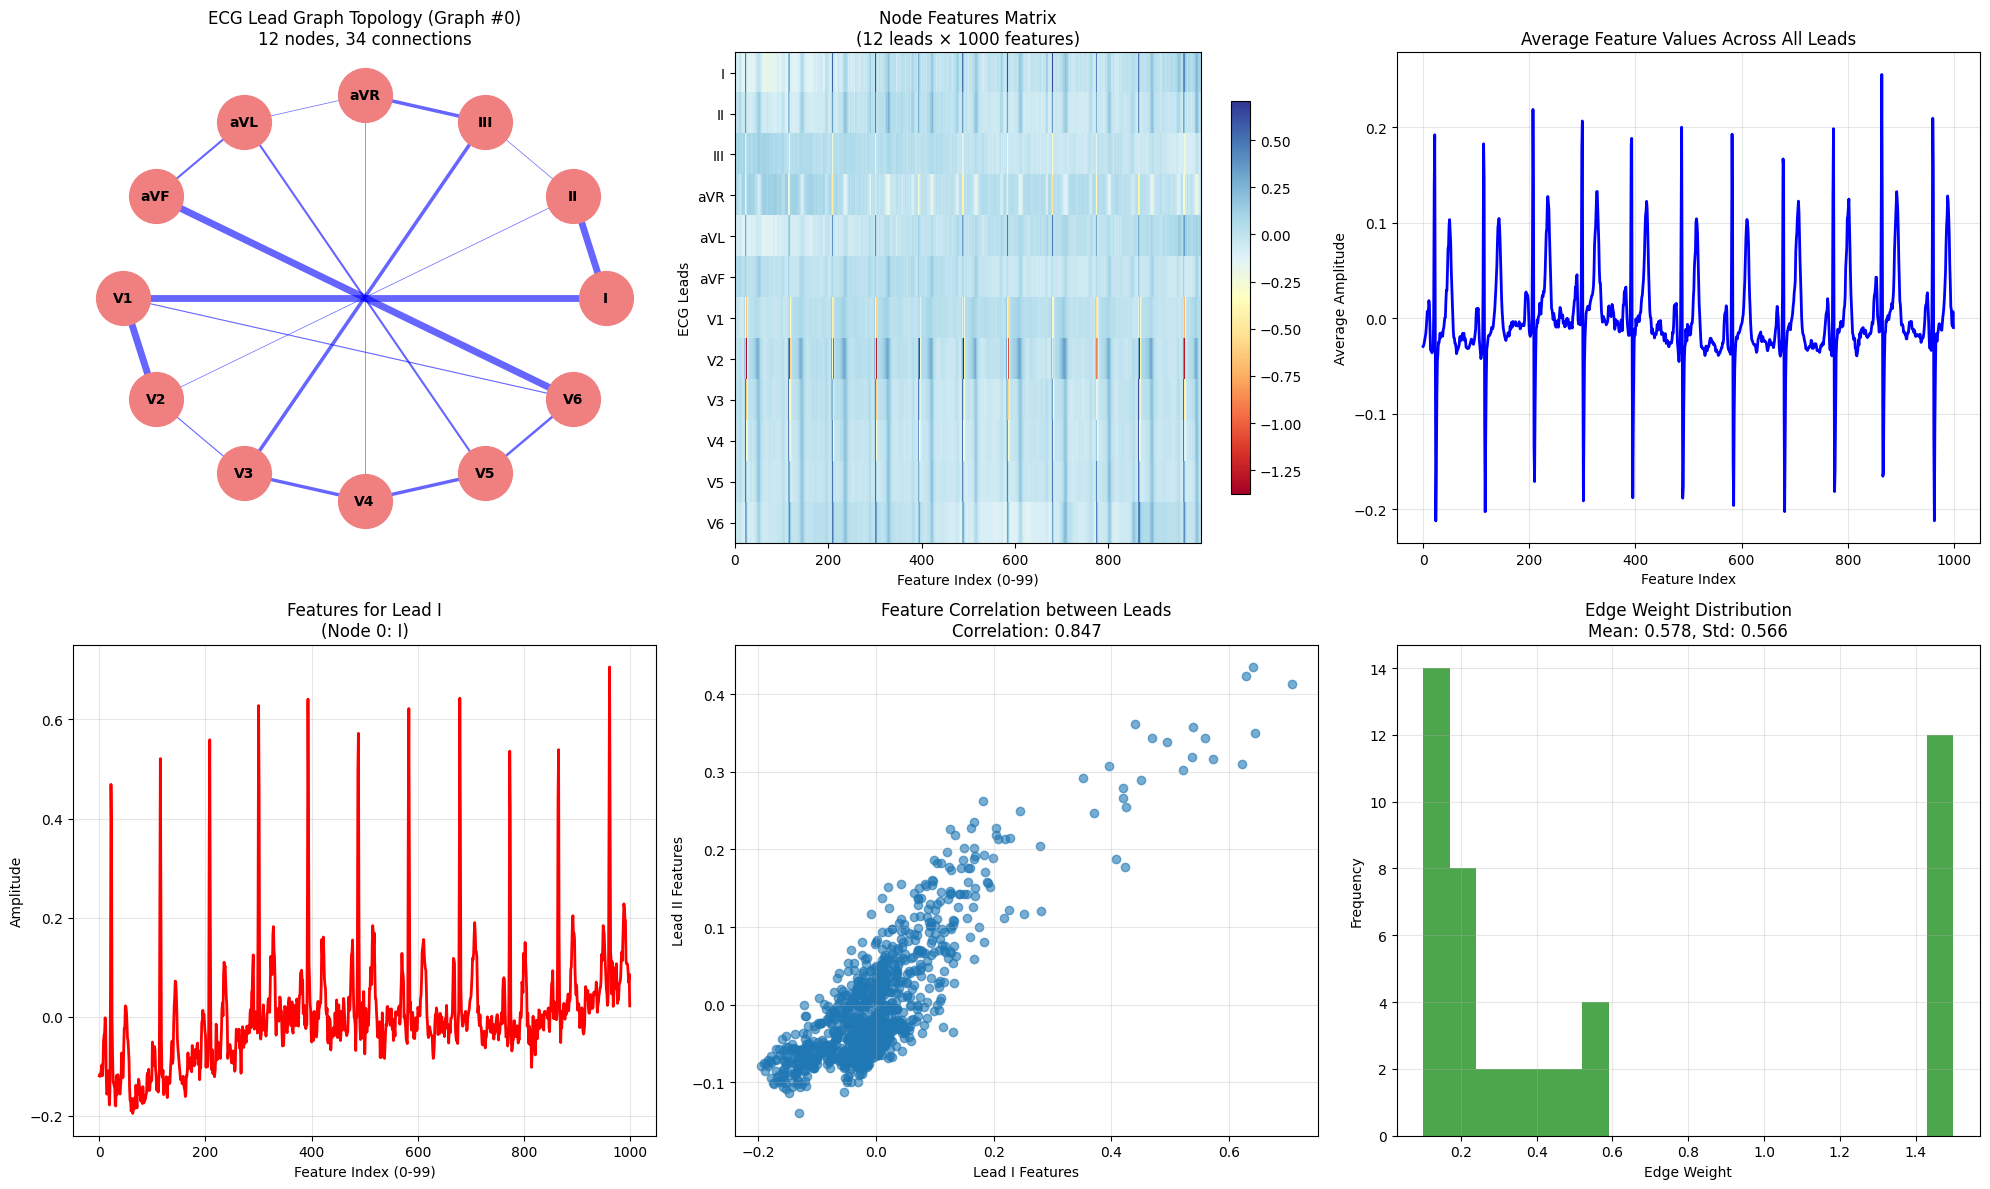


GRAPH STRUCTURE ANALYSIS - GRAPH #0
 NODES (ECG Leads):
   • Total nodes: 12
   • Features per node: 1000
   • Lead names: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

 EDGES (Connections):
   • Total edges: 46
   • Unique connections: 17
   • Edge weights: min=0.100, max=1.500, mean=0.578

 FEATURE ANALYSIS:
   • Feature range: [-1.377, 0.706]
   • Mean amplitude: 0.000
   • Std deviation: 0.108

 LABEL:
   • Label value: tensor([3])


In [108]:
def visualize_graph_structure(graph_data, graph_index=0, lead_names=None):
    """Visualize the graph structure showing how 100 features are connected with edge weights"""

    if lead_names is None:
        lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    fig = plt.figure(figsize=(20, 12))

    # 1. Graph network visualization with edge weights
    plt.subplot(2, 3, 1)
    G = nx.Graph()

    # Add nodes (ECG leads)
    num_nodes = graph_data.x.shape[0]
    node_labels = {i: lead_names[i] if i < len(lead_names) else f'Lead {i}' for i in range(num_nodes)}
    G.add_nodes_from(range(num_nodes))

    # Add edges with weights (skip self-loops for visualization)
    edges_to_show = []
    edge_weights_list = []

    for i in range(graph_data.edge_index.shape[1]):
        src, dst = graph_data.edge_index[:, i].tolist()
        if src != dst:  # Skip self-loops
            edges_to_show.append((src, dst))
            # Get edge weight if available
            if hasattr(graph_data, 'edge_attr') and graph_data.edge_attr is not None:
                weight = graph_data.edge_attr[i].item()
                G.add_edge(src, dst, weight=weight)
                edge_weights_list.append(weight)
            else:
                G.add_edge(src, dst, weight=1.0)
                edge_weights_list.append(1.0)

    # Position nodes in a circular layout to show structure
    pos = nx.circular_layout(G)

    # Draw edges with widths based on weights
    if edge_weights_list:
        # Normalize weights for visualization
        min_weight = min(edge_weights_list)
        max_weight = max(edge_weights_list)
        if max_weight > min_weight:
            normalized_widths = [0.5 + 4.5 * (w - min_weight) / (max_weight - min_weight) for w in edge_weights_list]
        else:
            normalized_widths = [2.0] * len(edge_weights_list)
        nx.draw_networkx_edges(G, pos, width=normalized_widths, edge_color='blue', alpha=0.6)
    else:
        nx.draw_networkx_edges(G, pos, edge_color='blue', alpha=0.6)

    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color='lightcoral', node_size=1500)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_weight='bold')

    plt.title(f'ECG Lead Graph Topology (Graph #{graph_index})\n{num_nodes} nodes, {len(edges_to_show)} connections')
    plt.axis('off')

    # 2. Node features as heatmap (12 leads × 100 features)
    plt.subplot(2, 3, 2)
    im = plt.imshow(graph_data.x.numpy(), cmap='RdYlBu', aspect='auto', interpolation='nearest')
    plt.colorbar(im, shrink=0.8)
    plt.xlabel('Feature Index (0-99)')
    plt.ylabel('ECG Leads')
    plt.title(f'Node Features Matrix\n({graph_data.x.shape[0]} leads × {graph_data.x.shape[1]} features)')
    plt.yticks(range(min(12, num_nodes)),
               [lead_names[i] if i < len(lead_names) else f'Lead {i}' for i in range(min(12, num_nodes))])

    # 3. Feature distribution across leads
    plt.subplot(2, 3, 3)
    feature_means = torch.mean(graph_data.x, dim=0).numpy()  # Average across leads
    plt.plot(feature_means, linewidth=2, color='blue')
    plt.xlabel('Feature Index')
    plt.ylabel('Average Amplitude')
    plt.title('Average Feature Values Across All Leads')
    plt.grid(True, alpha=0.3)

    # 4. Individual lead feature visualization (Lead I as example)
    plt.subplot(2, 3, 4)
    if num_nodes > 0:
        lead_i_features = graph_data.x[0].numpy()
        plt.plot(lead_i_features, linewidth=2, color='red')
        plt.xlabel('Feature Index (0-99)')
        plt.ylabel('Amplitude')
        plt.title(f'Features for Lead I\n(Node 0: {lead_names[0] if 0 < len(lead_names) else "Lead 0"})')
        plt.grid(True, alpha=0.3)

    # 5. Feature correlation between leads
    plt.subplot(2, 3, 5)
    if graph_data.x.shape[0] >= 2:
        # Correlation between first two leads
        lead1 = graph_data.x[0].numpy()
        lead2 = graph_data.x[1].numpy()
        correlation = np.corrcoef(lead1, lead2)[0, 1]
        plt.scatter(lead1, lead2, alpha=0.6)
        plt.xlabel(f'Lead {lead_names[0] if 0 < len(lead_names) else "0"} Features')
        plt.ylabel(f'Lead {lead_names[1] if 1 < len(lead_names) else "1"} Features')
        plt.title(f'Feature Correlation between Leads\nCorrelation: {correlation:.3f}')
        plt.grid(True, alpha=0.3)

    # 6. Edge weights visualization
    plt.subplot(2, 3, 6)
    if hasattr(graph_data, 'edge_attr') and graph_data.edge_attr is not None:
        # Plot histogram of edge weights
        weights = graph_data.edge_attr.numpy()
        plt.hist(weights, bins=20, alpha=0.7, color='green')
        plt.xlabel('Edge Weight')
        plt.ylabel('Frequency')
        plt.title(f'Edge Weight Distribution\nMean: {np.mean(weights):.3f}, Std: {np.std(weights):.3f}')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No Edge Weights\nAvailable', ha='center', va='center',
                transform=plt.gca().transAxes, fontsize=14)
        plt.title('Edge Weights')

    plt.tight_layout()
    plt.show()

    # Print detailed information
    print(f"\n{'='*60}")
    print(f"GRAPH STRUCTURE ANALYSIS - GRAPH #{graph_index}")
    print(f"{'='*60}")
    print(f" NODES (ECG Leads):")
    print(f"   • Total nodes: {graph_data.x.shape[0]}")
    print(f"   • Features per node: {graph_data.x.shape[1]}")
    print(f"   • Lead names: {[lead_names[i] if i < len(lead_names) else f'Lead {i}' for i in range(graph_data.x.shape[0])]}")

    print(f"\n EDGES (Connections):")
    print(f"   • Total edges: {graph_data.edge_index.shape[1]}")
    print(f"   • Unique connections: {len(set(tuple(sorted(edge)) for edge in edges_to_show))}")
    if hasattr(graph_data, 'edge_attr') and graph_data.edge_attr is not None:
        weights = graph_data.edge_attr.numpy()
        print(f"   • Edge weights: min={np.min(weights):.3f}, max={np.max(weights):.3f}, mean={np.mean(weights):.3f}")

    print(f"\n FEATURE ANALYSIS:")
    print(f"   • Feature range: [{torch.min(graph_data.x):.3f}, {torch.max(graph_data.x):.3f}]")
    print(f"   • Mean amplitude: {torch.mean(graph_data.x):.3f}")
    print(f"   • Std deviation: {torch.std(graph_data.x):.3f}")

    if hasattr(graph_data, 'y') and graph_data.y is not None:
        print(f"\n LABEL:")
        print(f"   • Label value: {graph_data.y.item() if graph_data.y.dim() == 0 else graph_data.y}")

def visualize_multiple_graphs_structure(graph_data_list, indices=[0, 1], lead_names=None):
    """Visualize structure of multiple graphs from graph_data_list"""

    if lead_names is None:
        lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    print("GRAPH STRUCTURE VISUALIZATION")
    print("="*50)

    for idx in indices:
        if idx < len(graph_data_list):
            visualize_graph_structure(graph_data_list[idx], idx, lead_names)
            print("\n" + "-"*80 + "\n")
        else:
            print(f"Index {idx} is out of range. Dataset has {len(graph_data_list)} graphs.")

def visualize_feature_distributions(graph_data_list, num_graphs=5):
    """Visualize how features are distributed across the dataset"""

    if len(graph_data_list) == 0:
        print("No graph data to visualize!")
        return

    print("FEATURE DISTRIBUTION ANALYSIS")
    print("="*40)

    # Collect features from first few graphs
    all_features = []
    for i in range(min(num_graphs, len(graph_data_list))):
        graph = graph_data_list[i]
        all_features.append(graph.x.numpy())

    all_features = np.concatenate(all_features, axis=0)  # Shape: (num_leads*num_graphs, 100)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Feature value distribution
    axes[0, 0].hist(all_features.flatten(), bins=50, alpha=0.7, color='skyblue')
    axes[0, 0].set_xlabel('Feature Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of All Feature Values')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Mean feature values across all samples
    mean_features = np.mean(all_features, axis=0)
    axes[0, 1].plot(mean_features, linewidth=2, color='red')
    axes[0, 1].set_xlabel('Feature Index')
    axes[0, 1].set_ylabel('Mean Value')
    axes[0, 1].set_title('Mean Feature Values (Across All Leads/Samples)')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Feature variance across all samples
    std_features = np.std(all_features, axis=0)
    axes[1, 0].plot(std_features, linewidth=2, color='green')
    axes[1, 0].set_xlabel('Feature Index')
    axes[1, 0].set_ylabel('Standard Deviation')
    axes[1, 0].set_title('Feature Variance (Across All Leads/Samples)')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Feature correlation matrix (first 10 features)
    corr_matrix = np.corrcoef(all_features[:, :10].T)
    im = axes[1, 1].imshow(corr_matrix, cmap='RdYlBu', vmin=-1, vmax=1)
    plt.colorbar(im, ax=axes[1, 1])
    axes[1, 1].set_xlabel('Feature Index')
    axes[1, 1].set_ylabel('Feature Index')
    axes[1, 1].set_title('Feature Correlation Matrix (First 10 Features)')

    plt.tight_layout()
    plt.show()

    print(f"Analyzed {min(num_graphs, len(graph_data_list))} graphs")
    print(f"Total features analyzed: {all_features.shape[0]} leads × 100 features = {all_features.shape[0] * 100} values")
    print(f"Feature value range: [{np.min(all_features):.3f}, {np.max(all_features):.3f}]")
    print(f"Overall mean: {np.mean(all_features):.3f}")
    print(f"Overall std: {np.std(all_features):.3f}")

# Usage examples:
print("Visualizing graph structure to understand 100 features representation...")

# Visualize the structure of the first graph
if len(graph_data_list) > 0:
    visualize_graph_structure(graph_data_list[0], graph_index=0)


In [ ]:
# Visualize multiple graphs
#visualize_multiple_graphs_structure(graph_data_list, indices=[0, 1, 2])

# Visualize feature distributions across the dataset
#visualize_feature_distributions(graph_data_list, num_graphs=5)


Plotting edge weights with report text analysis...
SAMPLE REPORT TEXTS FROM PTB-XL DATASET
Report 1:
  sinusrhythmus periphere niederspannung
------------------------------
Report 2:
  sinusbradykardie sonst normales ekg
------------------------------
Report 3:
  sinusrhythmus normales ekg
------------------------------
Report 4:
  sinusrhythmus normales ekg
------------------------------
Report 5:
  sinusrhythmus normales ekg
------------------------------

EDGE WEIGHT CALCULATION EXAMPLE
Sample report text: 'sinusrhythmus periphere niederspannung...'
Hash value: 682739
Converted edge weight: 1.8655


/tmp/ipython-input-3179446188.py:107: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(weights_per_graph, labels=[f'{i}' for i in graph_indices])


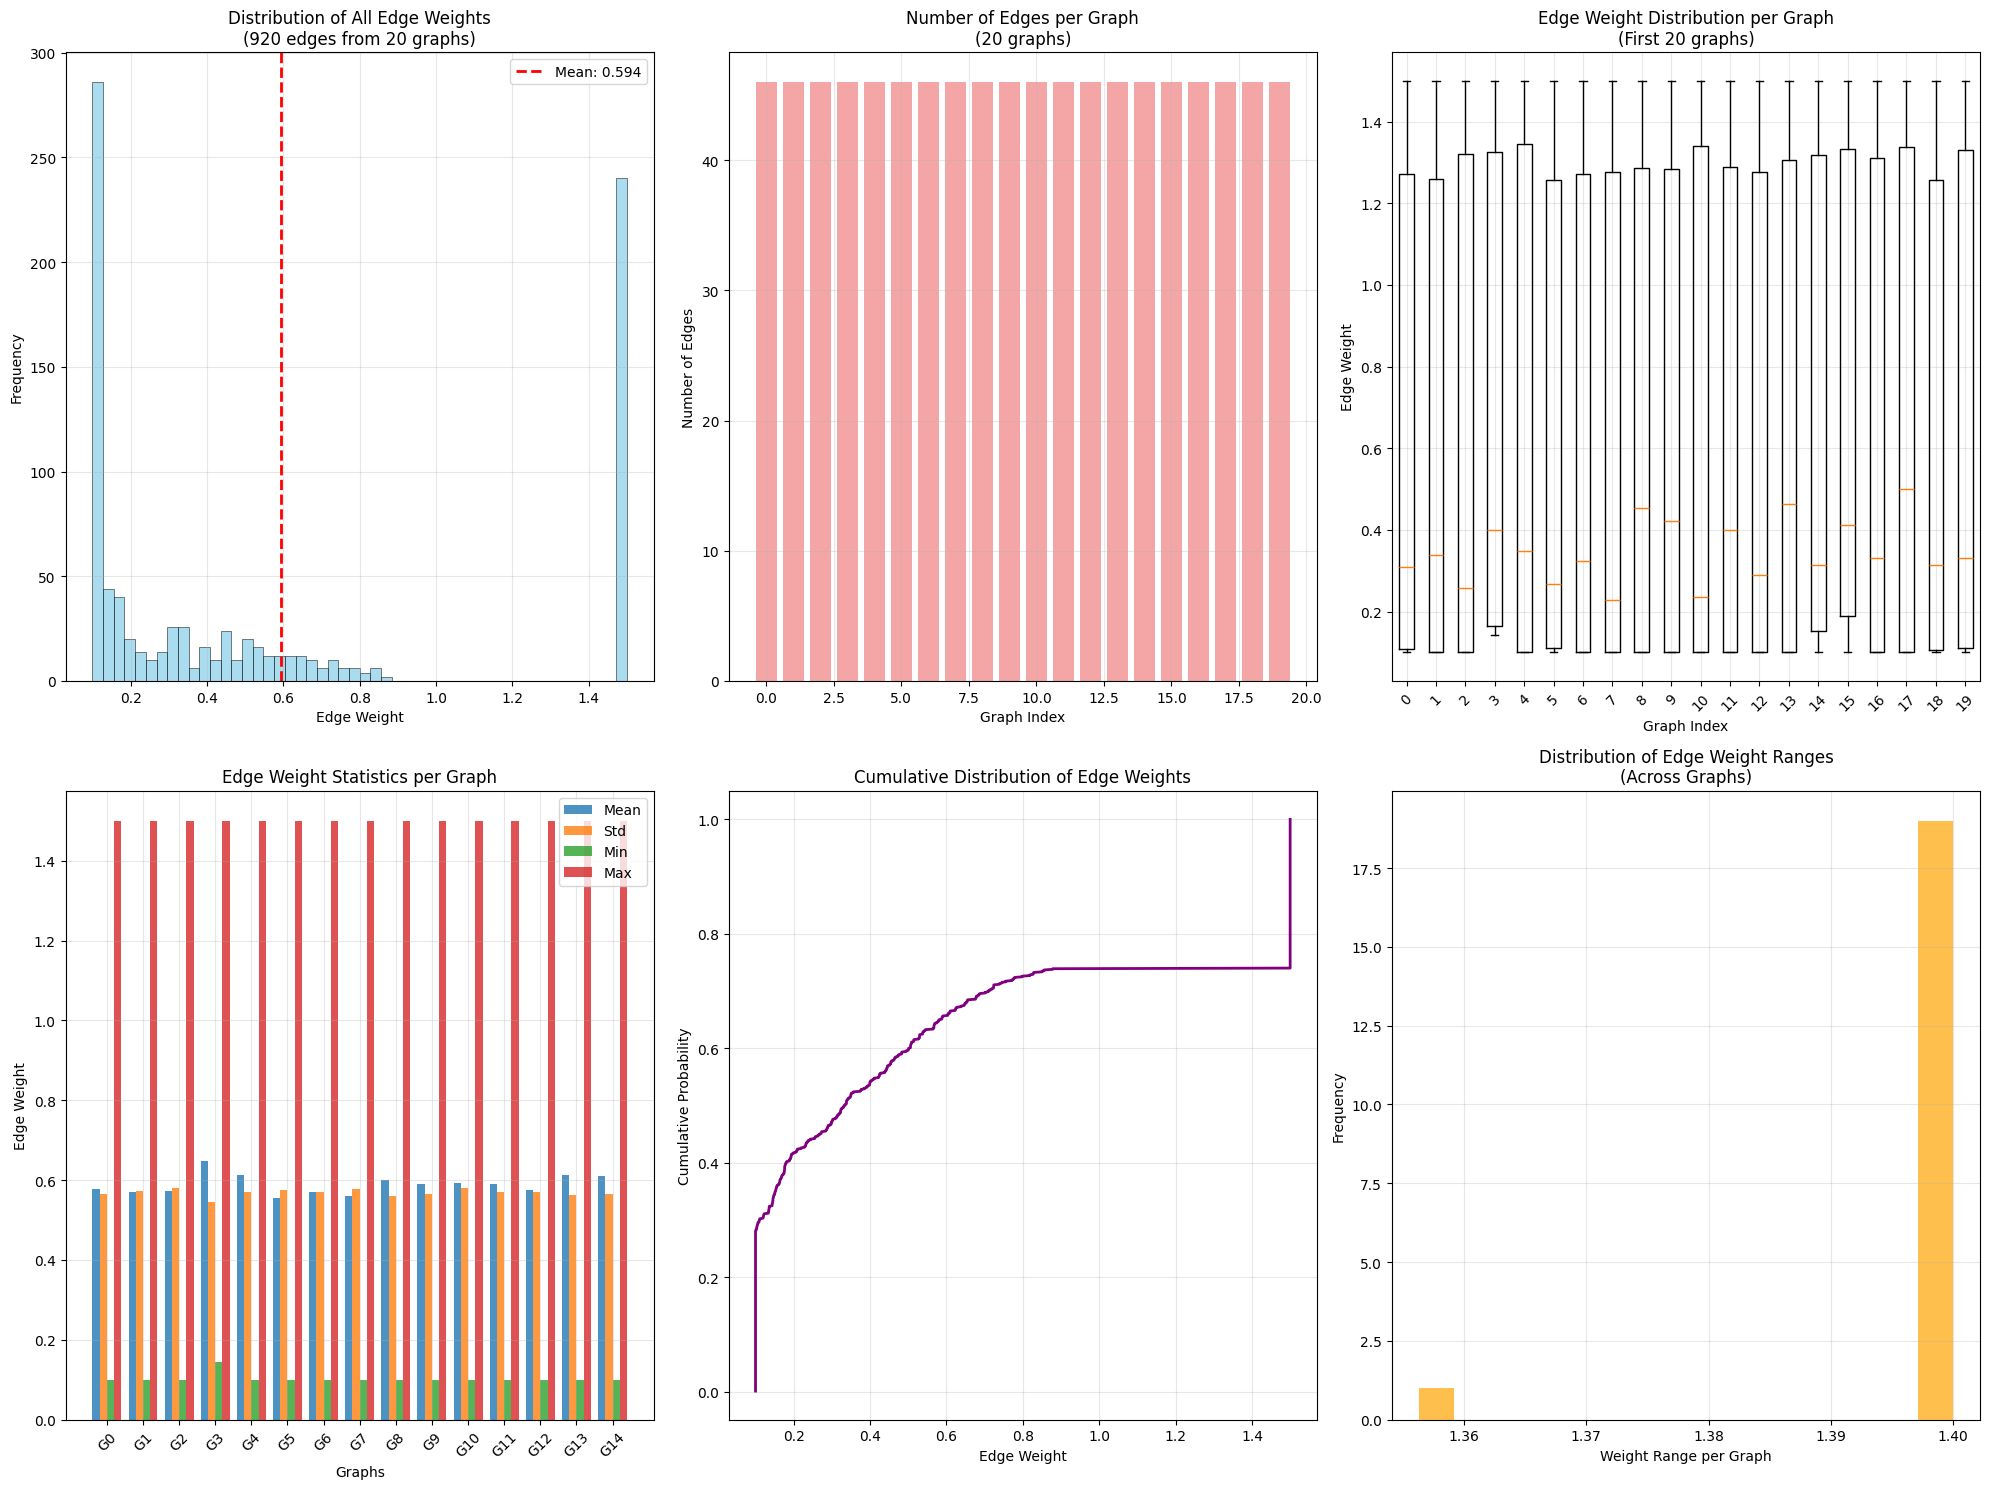


EDGE WEIGHTS ANALYSIS SUMMARY
Total graphs analyzed: 20
Total edges with weights: 920
Overall statistics:
  Mean weight: 0.5940
  Std deviation: 0.5685
  Min weight: 0.1000
  Max weight: 1.5000
  Median weight: 0.3335
  Weight range: 1.4000

SAMPLE EDGE WEIGHT VALUES:
First 10 edge weights from first graph:
  Edge 0: 0.5786
  Edge 1: 0.5786
  Edge 2: 0.1000
  Edge 3: 0.1000
  Edge 4: 0.3207
  Edge 5: 0.3207
  Edge 6: 0.1000
  Edge 7: 0.1000
  Edge 8: 0.2096
  Edge 9: 0.2096


In [109]:
def plot_all_edge_weights_with_reports(graph_data_list, metadata_df=None, max_graphs=10):
    """
    Plot edge weights distribution for all graphs in the dataset and show report text values

    Parameters:
    graph_data_list: List of graph data objects
    metadata_df: PTB-XL metadata DataFrame (ptbxl_database.csv)
    max_graphs: Maximum number of graphs to analyze
    """

    # Collect all edge weights from all graphs
    all_edge_weights = []
    graph_edge_counts = []

    # Process limited number of graphs for visualization
    num_graphs = min(len(graph_data_list), max_graphs)

    # Print sample report texts
    print("SAMPLE REPORT TEXTS FROM PTB-XL DATASET")
    print("="*50)

    report_texts = []
    if metadata_df is not None:
        # Get report texts for the first few samples
        for i in range(min(5, len(metadata_df))):
            if 'report' in metadata_df.columns:
                report_text = metadata_df.iloc[i]['report']
                if isinstance(report_text, str) and len(report_text.strip()) > 0:
                    report_texts.append(report_text)
                    print(f"Report {i+1}:")
                    print(f"  {report_text[:200]}{'...' if len(report_text) > 200 else ''}")
                    print("-" * 30)

    if not report_texts and metadata_df is not None:
        print("No report texts found in metadata or reports are empty")

    # Show how reports are converted to edge weights (example)
    print("\nEDGE WEIGHT CALCULATION EXAMPLE")
    print("="*30)

    if report_texts:
        sample_report = report_texts[0]
        # Simple hash-based embedding (same as in create_ecg_graph function)
        text_hash = hash(sample_report) % 1000000
        text_embedding = (text_hash / 1000000.0) * 2.0 + 0.5
        print(f"Sample report text: '{sample_report[:100]}...'")
        print(f"Hash value: {text_hash}")
        print(f"Converted edge weight: {text_embedding:.4f}")
    else:
        print("Using default edge weight: 1.0 (when no report text available)")

    # Collect edge weights for visualization
    for i in range(num_graphs):
        graph = graph_data_list[i]
        if hasattr(graph, 'edge_attr') and graph.edge_attr is not None:
            weights = graph.edge_attr.numpy()
            all_edge_weights.extend(weights)
            graph_edge_counts.append(len(weights))
        else:
            graph_edge_counts.append(0)

    if not all_edge_weights:
        print("\nNo edge weights found in the graphs!")
        return

    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 15))

    # 1. Overall distribution of all edge weights
    plt.subplot(2, 3, 1)
    plt.hist(all_edge_weights, bins=50, alpha=0.7, color='skyblue', edgecolor='black', linewidth=0.5)
    plt.xlabel('Edge Weight')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of All Edge Weights\n({len(all_edge_weights)} edges from {num_graphs} graphs)')
    plt.grid(True, alpha=0.3)

    # Add statistics
    mean_weight = np.mean(all_edge_weights)
    std_weight = np.std(all_edge_weights)
    plt.axvline(mean_weight, color='red', linestyle='--', linewidth=2,
                label=f'Mean: {mean_weight:.3f}')
    plt.legend()

    # 2. Edge weights per graph
    plt.subplot(2, 3, 2)
    if graph_edge_counts:
        plt.bar(range(len(graph_edge_counts)), graph_edge_counts, alpha=0.7, color='lightcoral')
        plt.xlabel('Graph Index')
        plt.ylabel('Number of Edges')
        plt.title(f'Number of Edges per Graph\n({num_graphs} graphs)')
        plt.grid(True, alpha=0.3)

    # 3. Box plot of edge weights per graph (sample first 20 graphs)
    plt.subplot(2, 3, 3)
    weights_per_graph = []
    graph_indices = []

    for i in range(min(20, num_graphs)):
        graph = graph_data_list[i]
        if hasattr(graph, 'edge_attr') and graph.edge_attr is not None:
            weights = graph.edge_attr.numpy()
            if len(weights) > 0:
                weights_per_graph.append(weights)
                graph_indices.append(i)

    if weights_per_graph:
        plt.boxplot(weights_per_graph, labels=[f'{i}' for i in graph_indices])
        plt.xlabel('Graph Index')
        plt.ylabel('Edge Weight')
        plt.title(f'Edge Weight Distribution per Graph\n(First {len(graph_indices)} graphs)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)

    # 4. Edge weight statistics summary
    plt.subplot(2, 3, 4)
    stats_data = []
    graph_labels = []

    for i in range(min(15, num_graphs)):
        graph = graph_data_list[i]
        if hasattr(graph, 'edge_attr') and graph.edge_attr is not None:
            weights = graph.edge_attr.numpy()
            if len(weights) > 0:
                stats_data.append([np.mean(weights), np.std(weights), np.min(weights), np.max(weights)])
                graph_labels.append(f'G{i}')

    if stats_data:
        stats_data = np.array(stats_data)
        x = np.arange(len(graph_labels))
        width = 0.2

        plt.bar(x - 1.5*width, stats_data[:, 0], width, label='Mean', alpha=0.8)
        plt.bar(x - 0.5*width, stats_data[:, 1], width, label='Std', alpha=0.8)
        plt.bar(x + 0.5*width, stats_data[:, 2], width, label='Min', alpha=0.8)
        plt.bar(x + 1.5*width, stats_data[:, 3], width, label='Max', alpha=0.8)

        plt.xlabel('Graphs')
        plt.ylabel('Edge Weight')
        plt.title('Edge Weight Statistics per Graph')
        plt.xticks(x, graph_labels, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)

    # 5. Cumulative distribution
    plt.subplot(2, 3, 5)
    sorted_weights = np.sort(all_edge_weights)
    cumulative = np.arange(1, len(sorted_weights) + 1) / len(sorted_weights)
    plt.plot(sorted_weights, cumulative, linewidth=2, color='purple')
    plt.xlabel('Edge Weight')
    plt.ylabel('Cumulative Probability')
    plt.title('Cumulative Distribution of Edge Weights')
    plt.grid(True, alpha=0.3)

    # 6. Text analysis of edge weights
    plt.subplot(2, 3, 6)
    # Show distribution of weight ranges
    weight_ranges = []
    for i in range(min(20, num_graphs)):
        graph = graph_data_list[i]
        if hasattr(graph, 'edge_attr') and graph.edge_attr is not None:
            weights = graph.edge_attr.numpy()
            if len(weights) > 0:
                weight_range = np.max(weights) - np.min(weights)
                weight_ranges.append(weight_range)

    if weight_ranges:
        plt.hist(weight_ranges, bins=15, alpha=0.7, color='orange')
        plt.xlabel('Weight Range per Graph')
        plt.ylabel('Frequency')
        plt.title('Distribution of Edge Weight Ranges\n(Across Graphs)')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nEDGE WEIGHTS ANALYSIS SUMMARY")
    print("="*40)
    print(f"Total graphs analyzed: {num_graphs}")
    print(f"Total edges with weights: {len(all_edge_weights)}")
    print(f"Overall statistics:")
    print(f"  Mean weight: {np.mean(all_edge_weights):.4f}")
    print(f"  Std deviation: {np.std(all_edge_weights):.4f}")
    print(f"  Min weight: {np.min(all_edge_weights):.4f}")
    print(f"  Max weight: {np.max(all_edge_weights):.4f}")
    print(f"  Median weight: {np.median(all_edge_weights):.4f}")

    # Weight range analysis
    weight_range = np.max(all_edge_weights) - np.min(all_edge_weights)
    print(f"  Weight range: {weight_range:.4f}")

    # Show some actual edge weight values
    print(f"\nSAMPLE EDGE WEIGHT VALUES:")
    print(f"First 10 edge weights from first graph:")
    if len(graph_data_list) > 0:
        first_graph = graph_data_list[0]
        if hasattr(first_graph, 'edge_attr') and first_graph.edge_attr is not None:
            sample_weights = first_graph.edge_attr.numpy()[:10]
            for i, weight in enumerate(sample_weights):
                print(f"  Edge {i}: {weight:.4f}")

def print_report_analysis(metadata_df, num_samples=5):
    """
    Print detailed analysis of report texts from PTB-XL metadata
    """
    if metadata_df is None:
        print("No metadata provided!")
        return

    print("DETAILED REPORT TEXT ANALYSIS")
    print("="*40)

    if 'report' not in metadata_df.columns:
        print("Report column not found in metadata!")
        return

    # Get non-empty reports
    reports = metadata_df['report'].dropna()
    non_empty_reports = [r for r in reports if isinstance(r, str) and len(r.strip()) > 0]

    print(f"Total records: {len(metadata_df)}")
    print(f"Records with reports: {len(reports)}")
    print(f"Non-empty reports: {len(non_empty_reports)}")
    print(f"Empty/missing reports: {len(metadata_df) - len(non_empty_reports)}")

    if non_empty_reports:
        # Length analysis
        report_lengths = [len(r) for r in non_empty_reports]
        print(f"\nReport Length Statistics:")
        print(f"  Mean length: {np.mean(report_lengths):.1f} characters")
        print(f"  Median length: {np.median(report_lengths):.1f} characters")
        print(f"  Min length: {np.min(report_lengths)} characters")
        print(f"  Max length: {np.max(report_lengths)} characters")

        # Show sample reports
        print(f"\nSAMPLE REPORTS:")
        for i in range(min(num_samples, len(non_empty_reports))):
            report = non_empty_reports[i]
            print(f"\nReport {i+1} ({len(report)} chars):")
            print(f"  '{report[:200]}{'...' if len(report) > 200 else ''}'")

        # Common words analysis (simple)
        all_text = ' '.join(non_empty_reports[:100])  # Analyze first 100 reports
        words = all_text.lower().split()
        # Remove common stop words
        stop_words = {'the', 'and', 'or', 'of', 'to', 'in', 'is', 'are', 'a', 'an', 'for', 'with', 'on', 'at', 'by'}
        filtered_words = [word.strip('.,;:!?()[]{}"\'') for word in words if word.strip('.,;:!?()[]{}"\'') not in stop_words and len(word) > 2]

        from collections import Counter
        word_counts = Counter(filtered_words)
        common_words = word_counts.most_common(10)

        print(f"\nMOST COMMON WORDS IN REPORTS (first 100 reports):")
        for word, count in common_words:
            print(f"  {word}: {count} times")

# Usage example:
print("Plotting edge weights with report text analysis...")

# If you have the metadata DataFrame from ptbxl_database.csv
# print_report_analysis(Y_selected, num_samples=3)  # Y_selected is your metadata DataFrame

# Plot comprehensive edge weights analysis with report information
if len(graph_data_list) > 0:
    # Pass your metadata DataFrame if available, otherwise None
    plot_all_edge_weights_with_reports(graph_data_list, metadata_df=Y_selected if 'Y_selected' in locals() else None, max_graphs=20)

In [110]:
# ✅ MODIFIED FOR RR-INTERVAL FEATURES
def visualize_ecg_graph(graph_data, sample_idx=0, lead_names=None):
    """
    Visualize ECG graph structure and signals with edge weights.
    NOW EXPLICITLY LABELS NODE FEATURES AS RR-INTERVAL VALUES.
    """
    if lead_names is None:
        lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    fig = plt.figure(figsize=(20, 15))

    # 1. Graph structure visualization with edge weights
    plt.subplot(2, 3, 1)
    G = nx.Graph()
    # Add nodes (ECG leads)
    num_nodes = graph_data.x.shape[0]
    node_labels = {i: lead_names[i] if i < len(lead_names) else f'Lead {i}' for i in range(num_nodes)}
    G.add_nodes_from(range(num_nodes))
    # Add edges with weights
    edge_weights = []
    for i in range(graph_data.edge_index.shape[1]):
        src, dst = graph_data.edge_index[:, i].tolist()
        if src != dst:  # Skip self-loops for visualization
            G.add_edge(src, dst)
            # Get edge weight if available
            if hasattr(graph_data, 'edge_attr') and graph_data.edge_attr is not None:
                weight = graph_data.edge_attr[i].item()
                G[src][dst]['weight'] = weight
                edge_weights.append(weight)
            else:
                edge_weights.append(1.0)
    # Position nodes in a circular layout
    pos = nx.circular_layout(G)
    # Draw edges with widths based on weights
    if edge_weights:
        # Normalize weights for visualization (0.5 to 5.0 range)
        min_weight = min(edge_weights)
        max_weight = max(edge_weights)
        if max_weight > min_weight:
            normalized_widths = [0.5 + 4.5 * (w - min_weight) / (max_weight - min_weight) for w in edge_weights]
        else:
            normalized_widths = [2.0] * len(edge_weights)
        # Use a fixed color for edges to avoid RGBA error
        nx.draw_networkx_edges(G, pos, width=normalized_widths, edge_color='blue', alpha=0.6)
    else:
        nx.draw_networkx_edges(G, pos, edge_color='blue', alpha=0.6)
    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1000)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_weight='bold')
    plt.title('ECG Lead Graph Structure\n(Edge widths = weights)')
    plt.axis('off')

    # 2. Node features heatmap (NOW LABELED AS RR-INTERVALS)
    plt.subplot(2, 3, 2)
    sns.heatmap(graph_data.x.numpy(), cmap='RdYlBu', cbar=True)
    plt.title('Node Features (RR-Interval Values)')
    plt.xlabel('Feature Index (Downsampled Time Points)')
    plt.ylabel('ECG Leads')

    # 3. Adjacency matrix
    plt.subplot(2, 3, 3)
    num_nodes = graph_data.x.shape[0]
    adj_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(graph_data.edge_index.shape[1]):
        src, dst = graph_data.edge_index[:, i]
        adj_matrix[src, dst] = 1
    sns.heatmap(adj_matrix, cmap='Blues', cbar=True)
    plt.title('Adjacency Matrix')
    plt.xlabel('ECG Leads')
    plt.ylabel('ECG Leads')

    # 4. Sample RR-interval features (First lead)
    plt.subplot(2, 3, 4)
    if graph_data.x.shape[0] > 0:
        # Plot the RR-interval timeseries for the first lead
        rr_values = graph_data.x[0, :].numpy()
        time_points = np.arange(len(rr_values))  # Feature index as proxy for time
        plt.plot(time_points, rr_values, label=f'{lead_names[0]} RR-Intervals', linewidth=2, color='green')
        plt.title('Sample RR-Interval Features (First Lead)')
        plt.xlabel('Feature Index')
        plt.ylabel('RR-Interval (seconds)')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # 5. Multiple lead RR-interval features
    plt.subplot(2, 3, 5)
    for i in range(min(6, graph_data.x.shape[0])):  # Show first 6 leads
        rr_values = graph_data.x[i, :30].numpy()  # First 30 features
        # Offset for visualization
        plt.plot(np.arange(len(rr_values)), rr_values + i*0.1,
                label=f'Lead {lead_names[i] if i < len(lead_names) else i}',
                alpha=0.7)
    plt.title('Multiple Leads RR-Interval Features (Offset for Visualization)')
    plt.xlabel('Feature Index')
    plt.ylabel('RR-Interval (s) + Offset')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 6. Edge weights visualization
    plt.subplot(2, 3, 6)
    if hasattr(graph_data, 'edge_attr') and graph_data.edge_attr is not None:
        # Plot histogram of edge weights
        weights = graph_data.edge_attr.numpy()
        plt.hist(weights, bins=20, alpha=0.7, color='green')
        plt.xlabel('Edge Weight')
        plt.ylabel('Frequency')
        plt.title(f'Edge Weight Distribution\nMean: {np.mean(weights):.3f}, Std: {np.std(weights):.3f}')
        plt.grid(True, alpha=0.3)
    else:
        # If no edge weights, show message
        plt.text(0.5, 0.5, 'No Edge Weights\nAvailable', ha='center', va='center',
                transform=plt.gca().transAxes, fontsize=14)
        plt.title('Edge Weights')

    plt.tight_layout()
    plt.show()

    print(f"Graph Info (RR-Interval Features):")
    print(f"- Number of nodes (leads): {graph_data.x.shape[0]}")
    print(f"- Number of node features (RR-interval points): {graph_data.x.shape[1]}")
    print(f"- Number of edges: {graph_data.edge_index.shape[1]}")
    if hasattr(graph_data, 'edge_attr') and graph_data.edge_attr is not None:
        weights = graph_data.edge_attr.numpy()
        print(f"- Edge weights: min={np.min(weights):.3f}, max={np.max(weights):.3f}, mean={np.mean(weights):.3f}")
    print(f"- Label: {graph_data.y.item() if hasattr(graph_data, 'y') else 'N/A'}")
    # Print RR-interval statistics
    rr_data = graph_data.x.numpy()
    print(f"- RR-Interval Stats: min={np.min(rr_data):.3f}s, max={np.max(rr_data):.3f}s, mean={np.mean(rr_data):.3f}s")

In [111]:
# ✅ MODIFIED FOR RR-INTERVAL FEATURES
def plot_ecg_with_r_peaks(ecg_id=1, lead_index=0, sampling_rate=100, base_path='/content/drive/MyDrive/ptb_xl_200_samples'):
    """
    Plot the original ECG signal with detected R-peaks overlaid.
    This helps verify the source of the RR-interval features.
    """
    try:
        filename = f"{ecg_id:05d}"
        folder = f"{(ecg_id//1000)*1000:05d}"
        if sampling_rate == 100:
            record_path = os.path.join(base_path, f"records100/{folder}/{filename}_lr")
        else:
            record_path = os.path.join(base_path, f"records500/{folder}/{filename}_hr")

        record = wfdb.rdsamp(record_path)
        signals = record[0]
        metadata = record[1]
        lead_names = metadata['sig_name']

        lead_signal = signals[:, lead_index]
        lead_name = lead_names[lead_index] if lead_index < len(lead_names) else f'Lead {lead_index}'

        # Calculate RR-interval timeseries (which also gives us the R-peak indices)
        rr_timeseries, r_peaks, rr_intervals = calculate_rr_intervals_timeseries(
            lead_signal, sampling_rate, target_length=None
        )

        # Create time array
        time_seconds = np.linspace(0, len(lead_signal) / sampling_rate, len(lead_signal))

        # Create the plot
        plt.figure(figsize=(15, 6))

        # Plot original ECG signal
        plt.plot(time_seconds, lead_signal,
                linewidth=1.0, alpha=0.8, color='blue', label=f'Original ECG ({lead_name})')

        # Plot R-peaks as red dots
        plt.scatter(r_peaks / sampling_rate, lead_signal[r_peaks],
                   color='red', s=50, alpha=0.9, marker='^', label='Detected R-Peaks', zorder=5)

        # Annotate some RR-intervals (every other peak for clarity)
        for i in range(1, min(len(r_peaks), 10), 2): # Annotate first few for clarity
            start_peak = r_peaks[i-1]
            end_peak = r_peaks[i]
            mid_point = (start_peak + end_peak) // 2
            rr_val = rr_intervals[i-1]
            plt.annotate(f'{rr_val:.2f}s',
                        xy=(mid_point / sampling_rate, np.max(lead_signal)*0.9 - i*0.1),
                        xytext=(mid_point / sampling_rate, np.max(lead_signal)*0.95 - i*0.1),
                        ha='center', va='bottom',
                        arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
                        fontsize=9, color='green', fontweight='bold')

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude (mV)')
        plt.title(f'ECG Signal with Detected R-Peaks and RR-Intervals\n{lead_name} - Record #{ecg_id}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Print summary
        print(f"R-Peak Detection Summary for {lead_name} (Record #{ecg_id}):")
        print(f"{'='*60}")
        print(f"Total R-Peaks Detected: {len(r_peaks)}")
        if len(rr_intervals) > 0:
            print(f"RR-Interval Range: [{np.min(rr_intervals):.3f}s, {np.max(rr_intervals):.3f}s]")
            print(f"Mean RR-Interval: {np.mean(rr_intervals):.3f}s (~{60/np.mean(rr_intervals):.1f} BPM)")
            print(f"Std Dev of RR-Intervals: {np.std(rr_intervals):.3f}s")
        else:
            print("No RR-intervals calculated (insufficient peaks).")

        return lead_signal, r_peaks, rr_intervals

    except Exception as e:
        print(f"Error plotting ECG with R-peaks for record #{ecg_id}: {e}")
        return None, None, None


GRAPH VISUALIZATION (RR-INTERVAL FEATURES)
Visualizing a sample ECG graph with RR-interval node features...


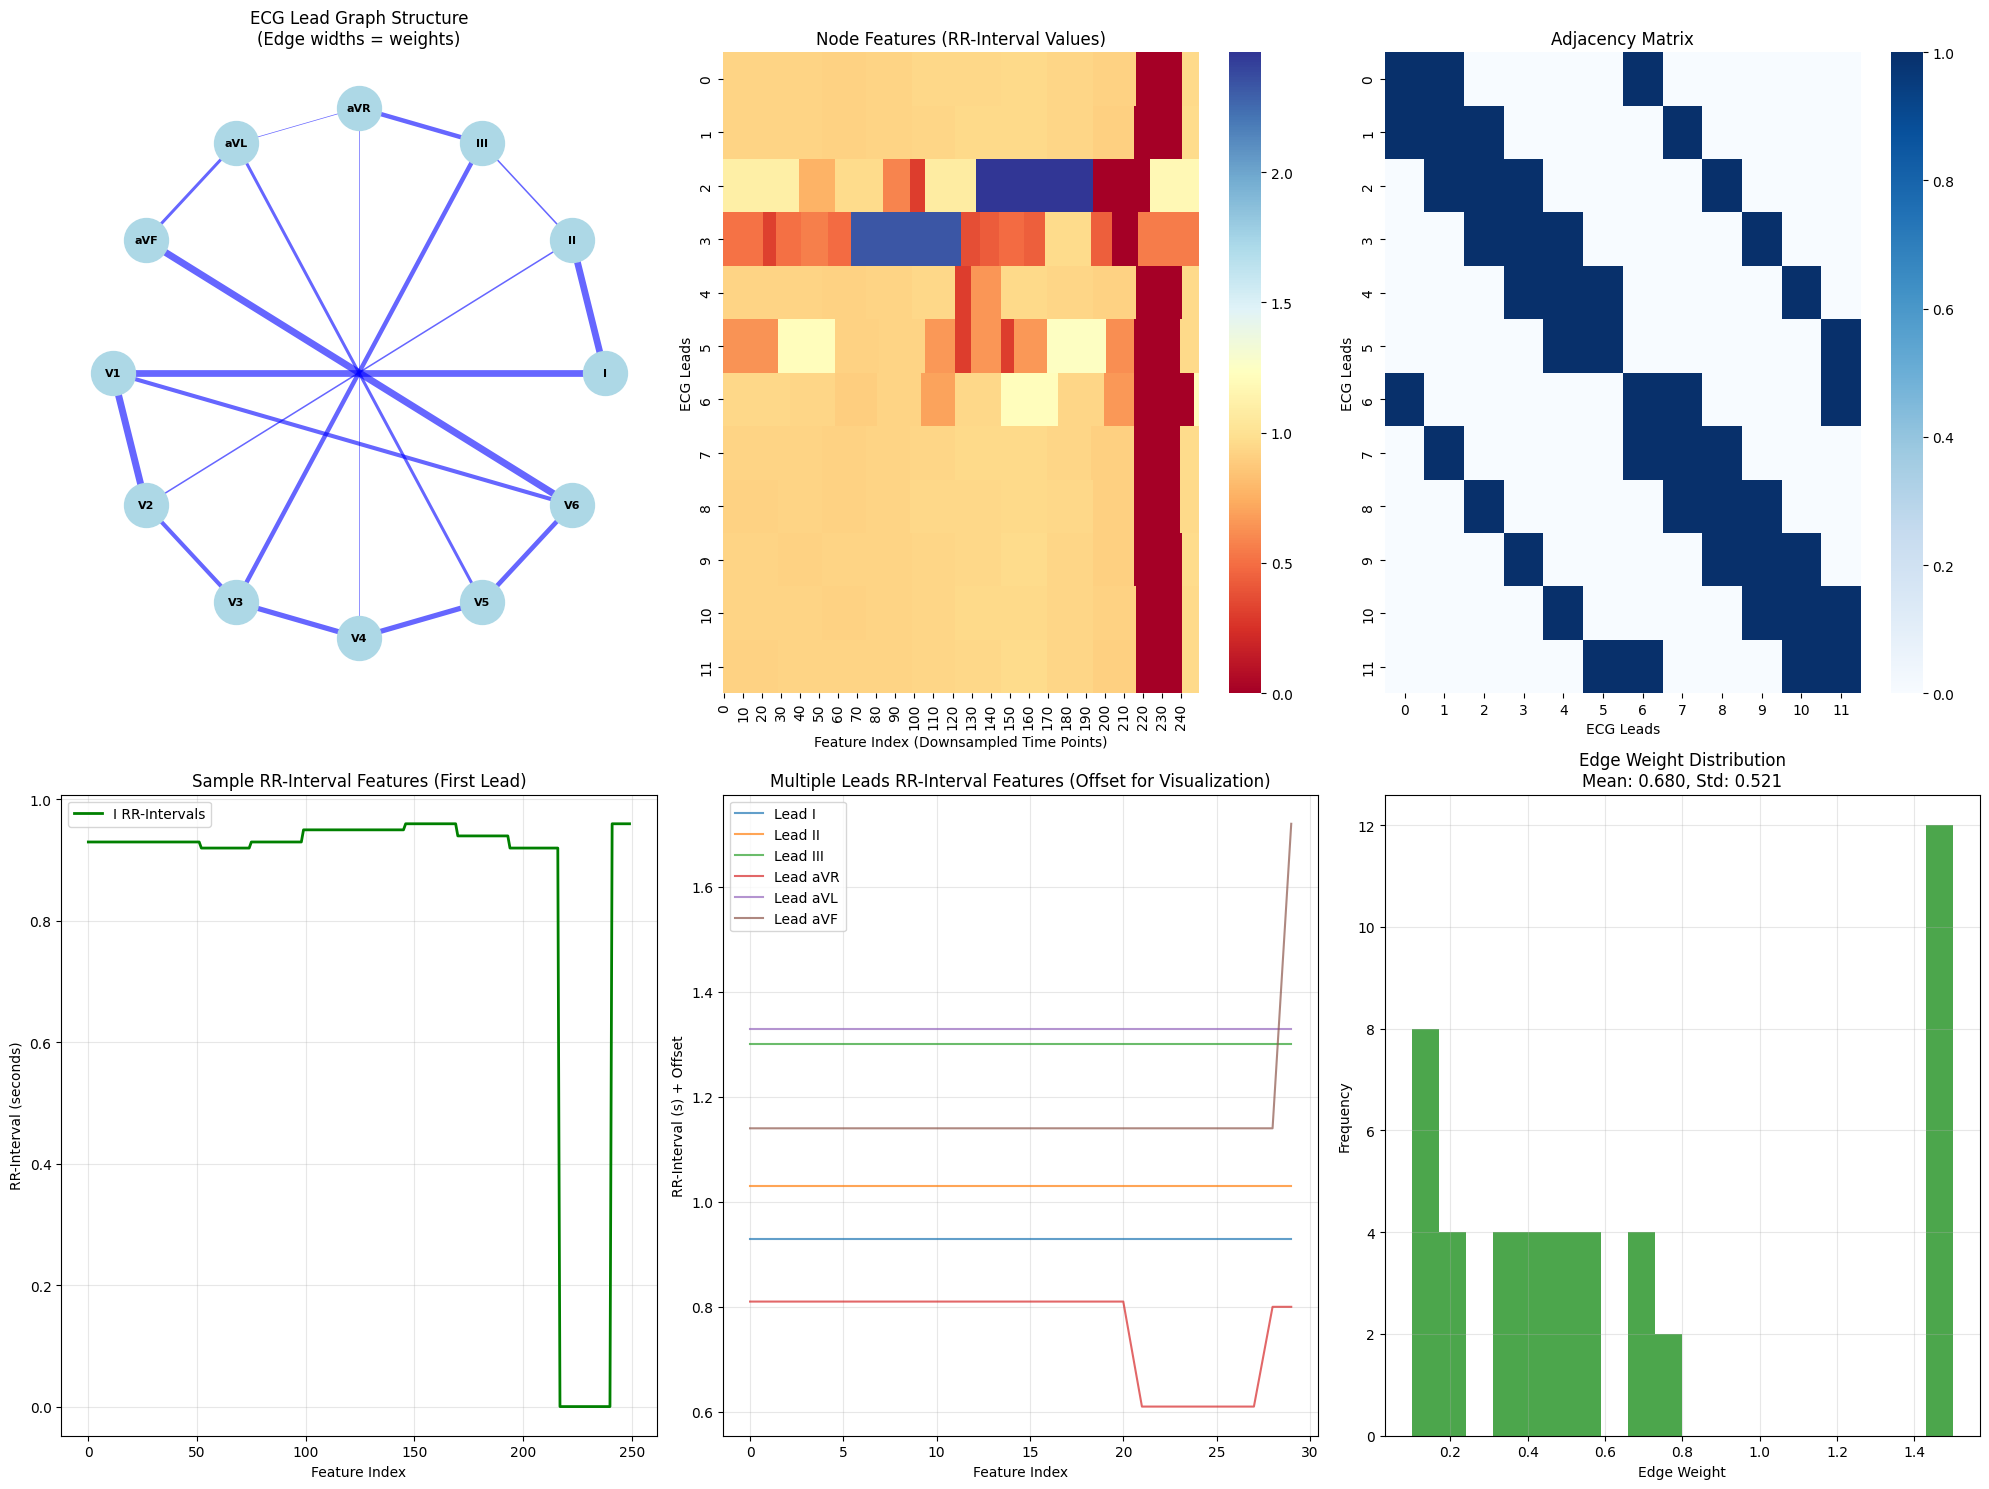

Graph Info (RR-Interval Features):
- Number of nodes (leads): 12
- Number of node features (RR-interval points): 250
- Number of edges: 46
- Edge weights: min=0.100, max=1.500, mean=0.680
- Label: 3
- RR-Interval Stats: min=0.000s, max=2.460s, mean=0.872s

Visualizing R-peaks on the original ECG signal for context...


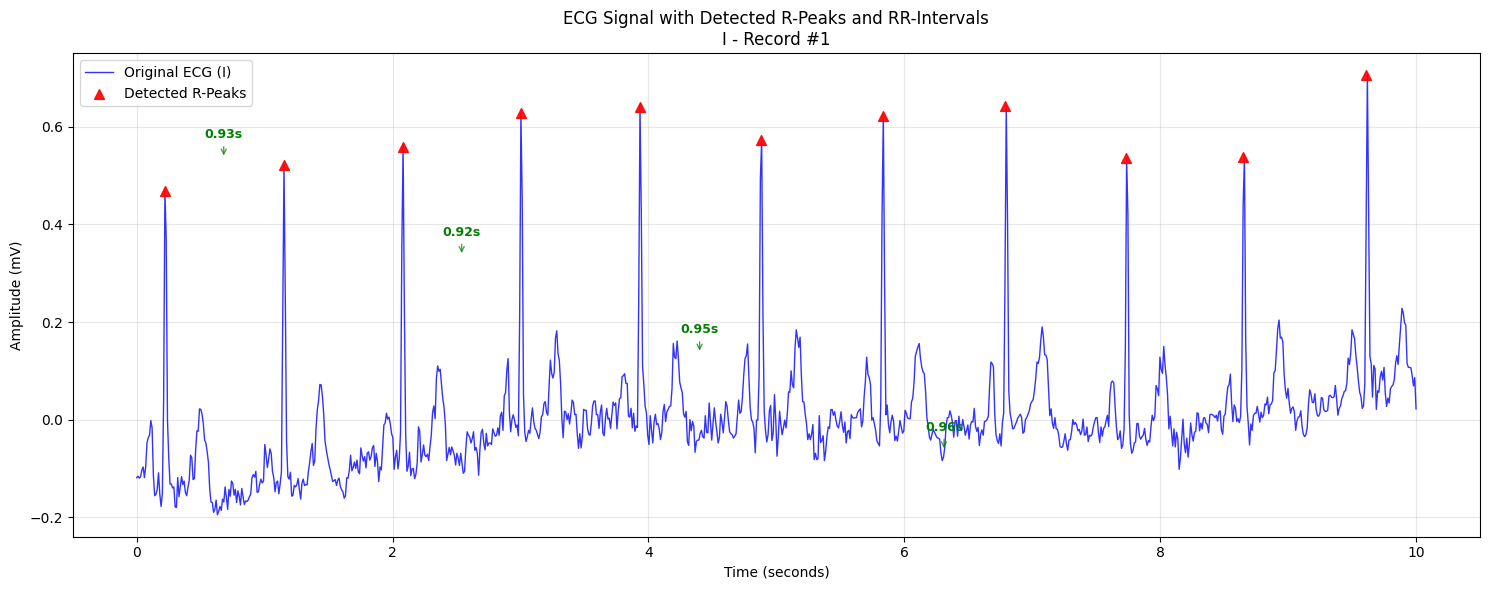

R-Peak Detection Summary for I (Record #1):
Total R-Peaks Detected: 11
RR-Interval Range: [0.920s, 0.960s]
Mean RR-Interval: 0.939s (~63.9 BPM)
Std Dev of RR-Intervals: 0.014s


In [ ]:
# ✅ MODIFIED FOR RR-INTERVAL FEATURES
# VISUALIZE SAMPLE GRAPH WITH RR-INTERVAL FEATURES
print("\n" + "="*50)
print("GRAPH VISUALIZATION (RR-INTERVAL FEATURES)")
print("="*50)

if len(graph_data_list) > 0:
    print("Visualizing a sample ECG graph with RR-interval node features...")
    visualize_ecg_graph(graph_data_list[0])

    # Also, plot the R-peaks on the original signal for context
    print("\nVisualizing R-peaks on the original ECG signal for context...")
    # You need to know which ecg_id corresponds to graph_data_list[0]
    # For simplicity, let's assume it's the first sample (ecg_id=1)
    # In a real scenario, you'd map your graph_data_list index back to the original ecg_id
    plot_ecg_with_r_peaks(ecg_id=1, lead_index=0, sampling_rate=100)
else:
    print("No graph data available to visualize.")

# Imbalanced class problem

In [121]:
# First, let's analyze the class distribution in your dataset
def analyze_class_distribution(y_labels, class_names):
    """Analyze class distribution and identify imbalance issues"""

    print("CLASS DISTRIBUTION ANALYSIS")
    print("="*50)

    # Multi-label distribution
    class_counts_multi = np.sum(y_labels, axis=0)

    print("Multi-label distribution:")
    for i, (class_name, count) in enumerate(zip(class_names, class_counts_multi)):
        percentage = (count / y_labels.shape[0]) * 100
        print(f"  {class_name}: {int(count)} ({percentage:.1f}%)")

    # Single label distribution (from your y_single_labels)
    unique, counts = np.unique(y_single_labels, return_counts=True)
    print(f"\nSingle-label distribution:")
    for i, (class_idx, count) in enumerate(zip(unique, counts)):
        class_name = class_names[class_idx] if class_idx < len(class_names) else f"Class {class_idx}"
        percentage = (count / len(y_single_labels)) * 100
        print(f"  {class_name}: {count} ({percentage:.1f}%)")

    # Identify highly imbalanced classes
    max_count = np.max(counts)
    imbalance_ratios = max_count / counts
    print(f"\nClass imbalance analysis:")
    for i, (class_idx, ratio) in enumerate(zip(unique, imbalance_ratios)):
        class_name = class_names[class_idx] if class_idx < len(class_names) else f"Class {class_idx}"
        print(f"  {class_name}: Imbalance ratio = {ratio:.2f}")

    return class_counts_multi, unique, counts

# Analyze your current dataset
class_counts, unique_classes, class_counts_single = analyze_class_distribution(y_labels, class_names)

# Solutions for class imbalance:

# 1. Use weighted loss function
def get_class_weights(y_single_labels):
    """Calculate class weights for imbalanced dataset"""
    from sklearn.utils.class_weight import compute_class_weight

    classes = np.unique(y_single_labels)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_single_labels)
    class_weights_dict = dict(zip(classes, class_weights))

    print("Class weights for balanced training:")
    for class_idx, weight in class_weights_dict.items():
        class_name = class_names[class_idx] if class_idx < len(class_names) else f"Class {class_idx}"
        print(f"  {class_name}: {weight:.2f}")

    return class_weights_dict

CLASS DISTRIBUTION ANALYSIS
Multi-label distribution:
  CD: 127 (18.8%)
  HYP: 59 (8.7%)
  MI: 123 (18.2%)
  NORM: 380 (56.1%)
  STTC: 153 (22.6%)

Single-label distribution:
  CD: 127 (18.8%)
  HYP: 43 (6.4%)
  MI: 63 (9.3%)
  NORM: 371 (54.8%)
  STTC: 73 (10.8%)

Class imbalance analysis:
  CD: Imbalance ratio = 2.92
  HYP: Imbalance ratio = 8.63
  MI: Imbalance ratio = 5.89
  NORM: Imbalance ratio = 1.00
  STTC: Imbalance ratio = 5.08


In [122]:
# More aggressive class weighting
from sklearn.utils.class_weight import compute_class_weight

def get_balanced_class_weights(y_labels, class_names, method='balanced_sqrt'):
    """
    Enhanced class weighting strategies
    """
    unique, counts = np.unique(y_labels, return_counts=True)

    if method == 'balanced':
        class_weights = compute_class_weight('balanced', classes=unique, y=y_labels)
    elif method == 'balanced_sqrt':
        # Square root of balanced weights for less extreme weighting
        balanced_weights = compute_class_weight('balanced', classes=unique, y=y_labels)
        class_weights = np.sqrt(balanced_weights)
    elif method == 'focal':
        # Inverse frequency weighting
        total_samples = len(y_labels)
        class_weights = total_samples / (len(unique) * counts)

    class_weights_dict = dict(zip(unique, class_weights))

    print(f"Enhanced class weights ({method}):")
    for class_idx, weight in class_weights_dict.items():
        class_name = class_names[class_idx] if class_idx < len(class_names) else f"Class {class_idx}"
        print(f"  {class_name}: {weight:.2f}")

    return class_weights_dict

# Try different weighting strategies
class_weights_dict = get_balanced_class_weights(y_single_labels, class_names, method='balanced_sqrt')
class_weights = torch.tensor([class_weights_dict.get(i, 1.0) for i in range(len(class_names))],
                            dtype=torch.float).to(device)

Enhanced class weights (balanced_sqrt):
  CD: 1.03
  HYP: 1.77
  MI: 1.47
  NORM: 0.60
  STTC: 1.36


In [123]:
class GraphECGNetImbalanced(nn.Module):
    def __init__(self, num_features, hidden_dim=32, num_classes=5):
        super(GraphECGNetImbalanced, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)

        # Add residual connections
        self.skip_conv = GCNConv(num_features, hidden_dim)

        # Attention mechanism for global pooling
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Softmax(dim=0)
        )

        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, num_classes)

        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)

        self.dropout = nn.Dropout(0.6)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = data.edge_attr if hasattr(data, 'edge_attr') and data.edge_attr is not None else None

        # Graph convolutions with residual connection
        x1 = F.relu(self.bn1(self.conv1(x, edge_index, edge_weight=edge_attr)))
        x1 = F.dropout(x1, training=self.training, p=0.3)

        x2 = F.relu(self.bn2(self.conv2(x1, edge_index, edge_weight=edge_attr)))
        x2 = F.dropout(x2, training=self.training, p=0.3)

        x3 = self.bn3(self.conv3(x2, edge_index, edge_weight=edge_attr))
        # Add residual connection
        x_skip = self.skip_conv(x, edge_index, edge_weight=edge_attr)
        x = F.relu(x3 + x_skip)
        x = F.dropout(x, training=self.training, p=0.3)

        # Attention-based global pooling
        batch_size = batch.max().item() + 1
        out = torch.zeros(batch_size, x.size(1)).to(x.device)

        for i in range(batch_size):
            mask = (batch == i)
            batch_features = x[mask]
            # Apply attention
            attention_weights = self.attention(batch_features)
            weighted_features = batch_features * attention_weights
            out[i] = weighted_features.sum(dim=0)

        # Classification layers
        x = F.relu(self.fc1(out))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)

In [124]:
# Focal Loss implementation for imbalanced datasets
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        if alpha is not None:
            self.alpha = torch.tensor(alpha)
        else:
            self.alpha = None

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)

        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            at = self.alpha.gather(0, targets)
            focal_loss = at * (1-pt)**self.gamma * ce_loss
        else:
            focal_loss = (1-pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Use focal loss instead of weighted NLLLoss
# Calculate alpha values based on class distribution
unique, counts = np.unique(y_single_labels, return_counts=True)
total_samples = len(y_single_labels)
alpha_values = [total_samples / (len(unique) * count) for count in counts]
alpha_values = [min(a, 5.0) for a in alpha_values]  # Cap maximum weight

criterion = FocalLoss(alpha=alpha_values, gamma=2.0)

# Enhanced optimizer with learning rate scheduling
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Mixup augmentation for better generalization
def mixup_data(x, y, alpha=0.2):
    """Mixup data augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index,:]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [126]:
# Analyze and potentially oversample minority classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

def analyze_and_balance_dataset(graph_data_list, y_single_labels):
    """Analyze dataset balance and suggest balancing strategies"""

    unique, counts = np.unique(y_single_labels, return_counts=True)

    print("Dataset Balance Analysis:")
    print("-" * 30)
    for i, (class_idx, count) in enumerate(zip(unique, counts)):
        class_name = class_names[class_idx] if class_idx < len(class_names) else f"Class {class_idx}"
        print(f"{class_name}: {count} samples ({count/len(y_single_labels)*100:.1f}%)")

    # Calculate imbalance ratio
    max_count = np.max(counts)
    min_count = np.min(counts)
    imbalance_ratio = max_count / min_count

    print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")

    if imbalance_ratio > 5:
        print("⚠️  Severe class imbalance detected!")
        print("Recommendations:")
        print("1. Use class weighting")
        print("2. Consider data augmentation for minority classes")
        print("3. Use focal loss")
        print("4. Apply ensemble methods")

    return imbalance_ratio

# Analyze your dataset
imbalance_ratio = analyze_and_balance_dataset(graph_data_list, y_single_labels)

Dataset Balance Analysis:
------------------------------
CD: 127 samples (18.8%)
HYP: 43 samples (6.4%)
MI: 63 samples (9.3%)
NORM: 371 samples (54.8%)
STTC: 73 samples (10.8%)

Imbalance Ratio: 8.63
⚠️  Severe class imbalance detected!
Recommendations:
1. Use class weighting
2. Consider data augmentation for minority classes
3. Use focal loss
4. Apply ensemble methods


# Example MultiFocal Loss for GNN

Plotting class co-occurrence and overlap analysis...


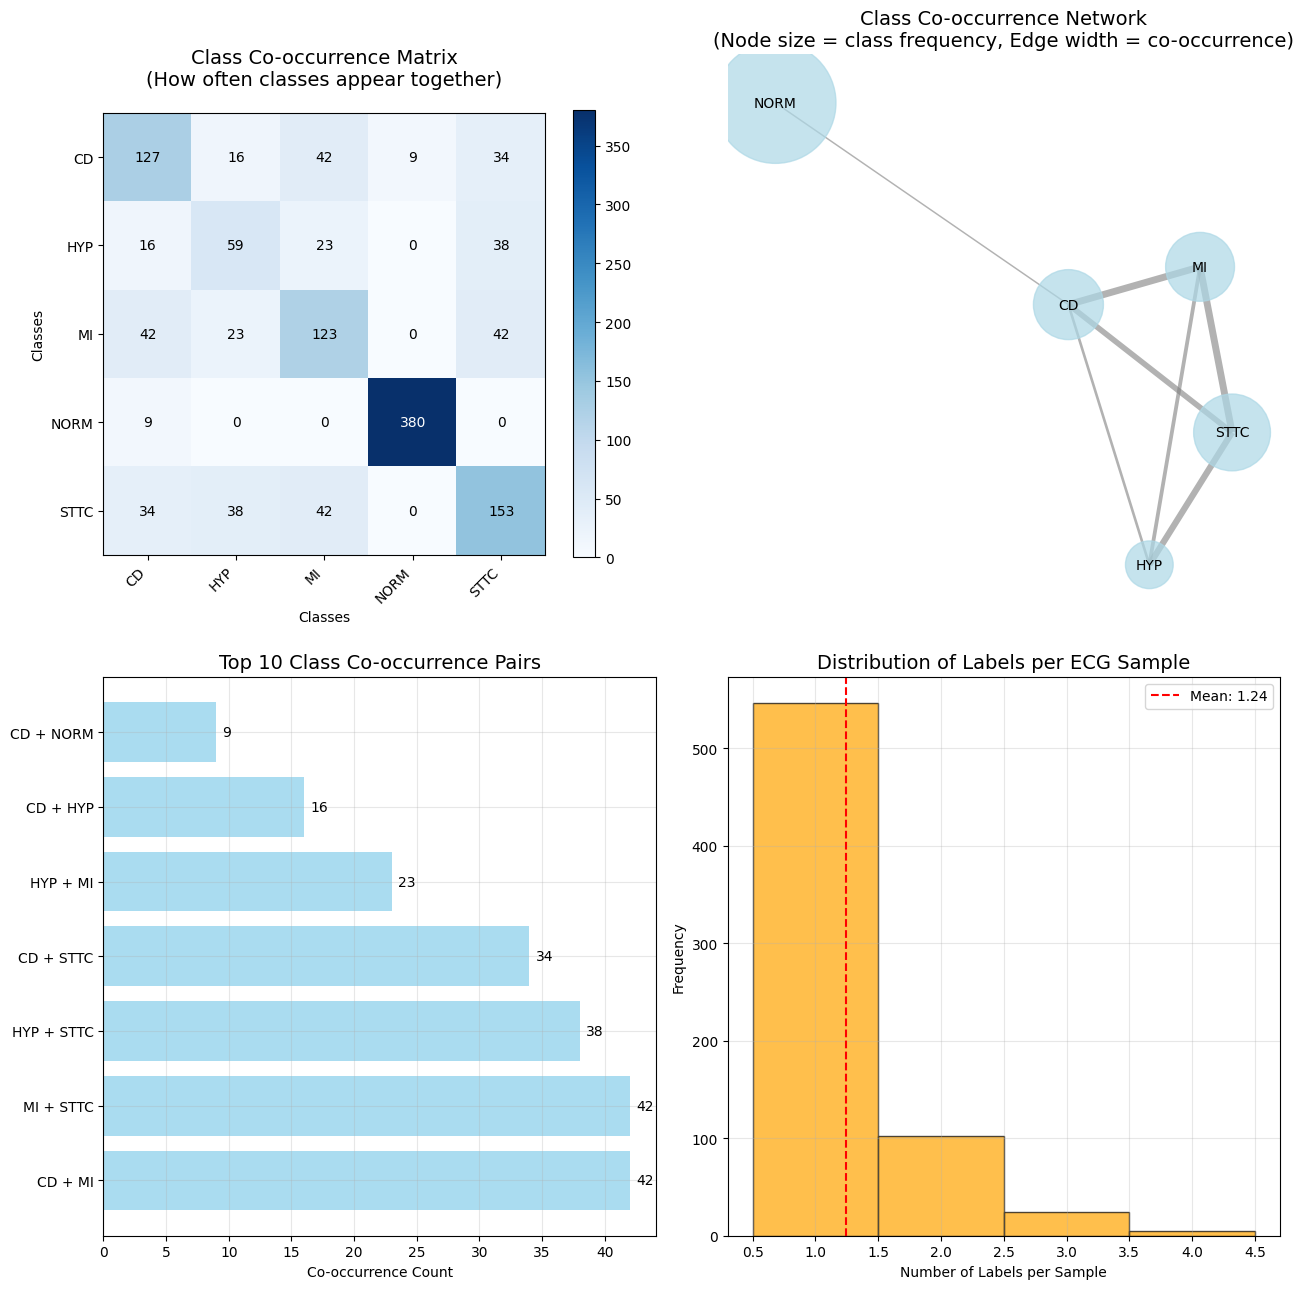

CLASS CO-OCCURRENCE ANALYSIS
Total samples: 677
Number of classes: 5
Total labels: 842
Average labels per sample: 1.24

Class frequencies:
  CD: 127 (18.8%)
  HYP: 59 (8.7%)
  MI: 123 (18.2%)
  NORM: 380 (56.1%)
  STTC: 153 (22.6%)

Most common co-occurrence pairs:
  CD + MI: 42
  MI + STTC: 42
  HYP + STTC: 38
  CD + STTC: 34
  HYP + MI: 23
  CD + HYP: 16
  CD + NORM: 9


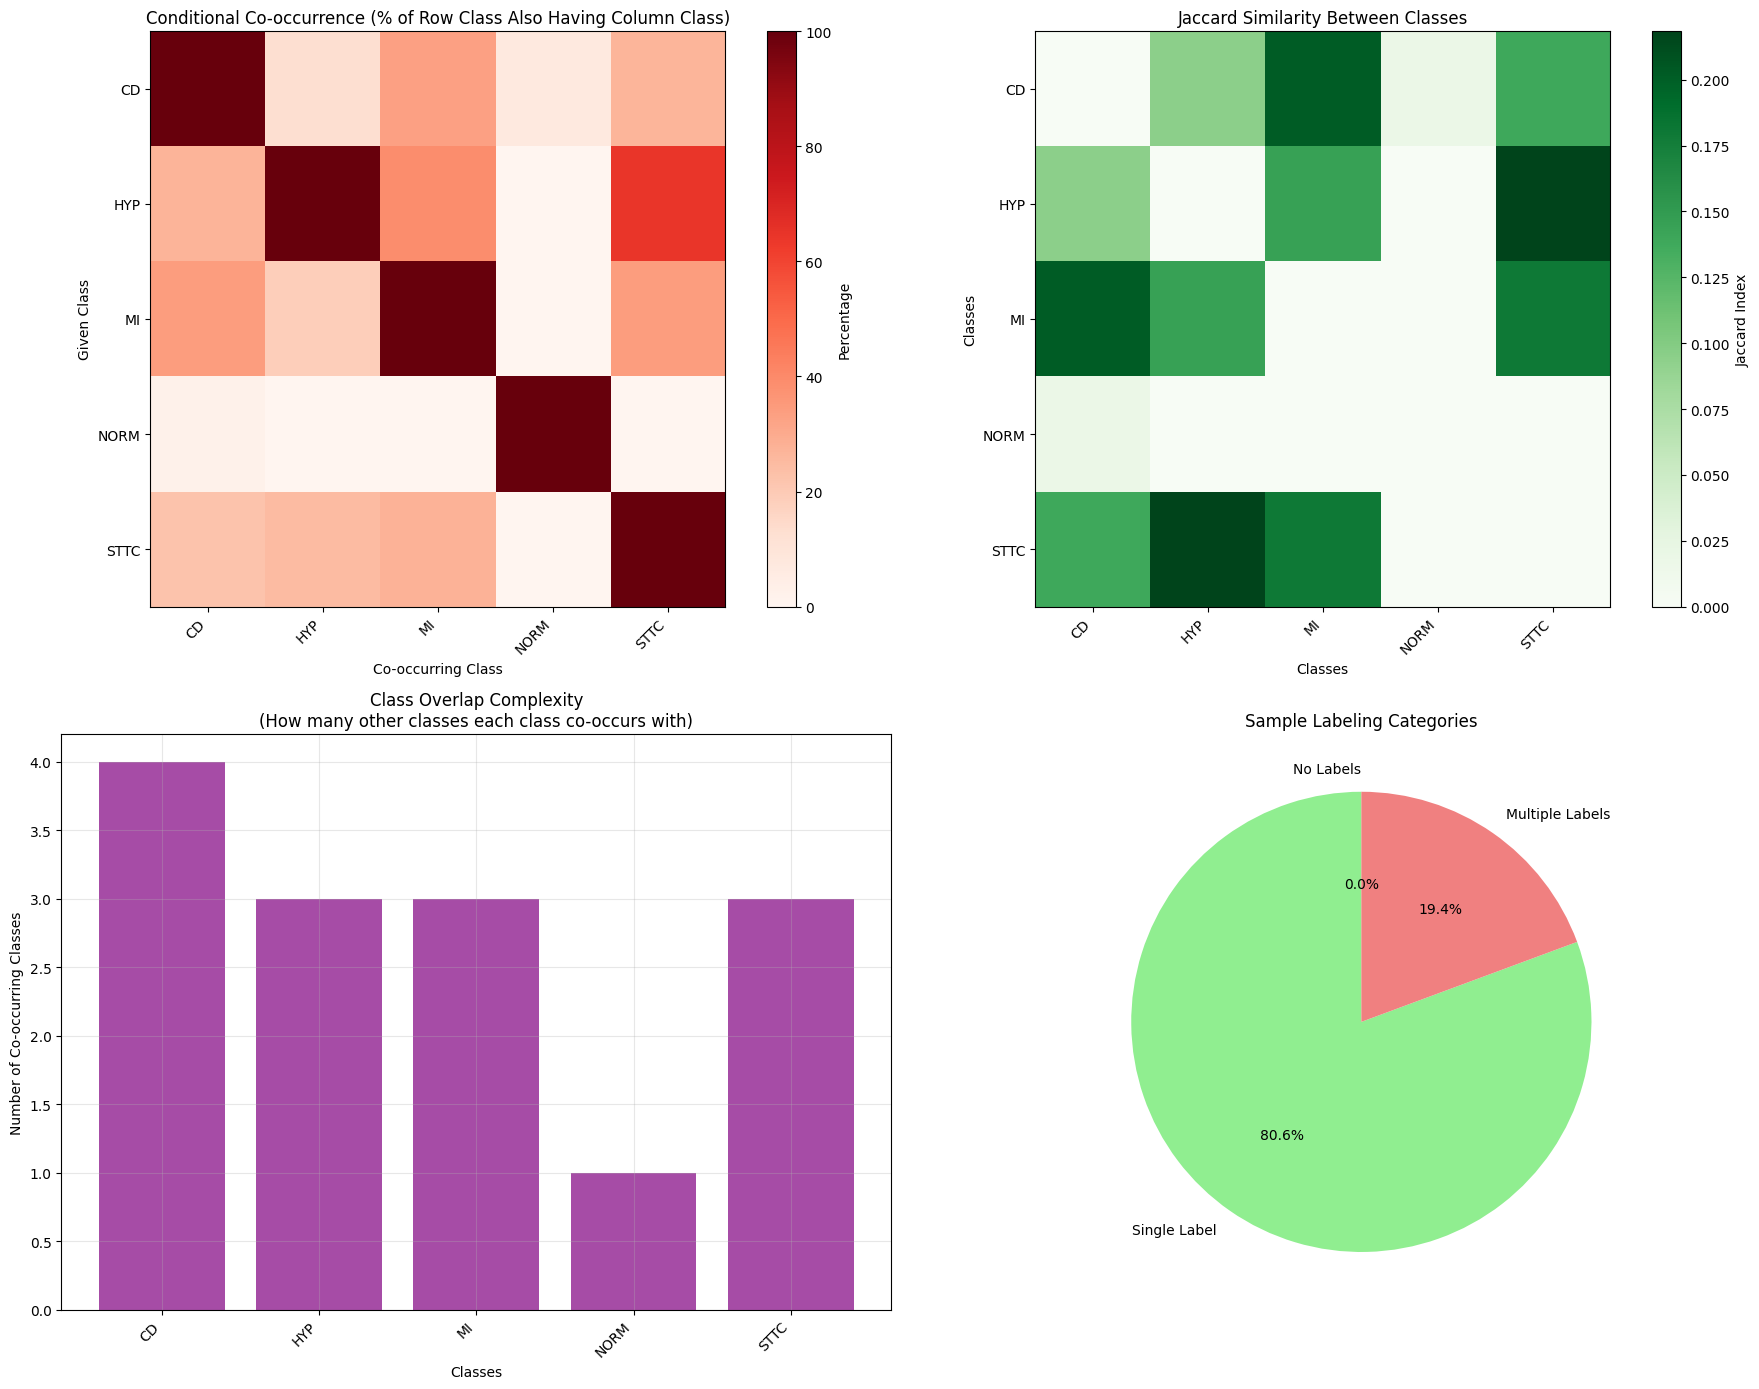


DETAILED CLASS RELATIONSHIP ANALYSIS
Samples with single label: 546 (80.6%)
Samples with multiple labels: 131 (19.4%)
Samples with no labels: 0 (0.0%)

Classes with highest overlap complexity:
  CD: co-occurs with 4 other classes
  HYP: co-occurs with 3 other classes
  MI: co-occurs with 3 other classes
  STTC: co-occurs with 3 other classes
  NORM: co-occurs with 1 other classes

Strongest conditional relationships (>20%):
  CD → MI: 33.1%
  CD → STTC: 26.8%
  HYP → CD: 27.1%
  HYP → MI: 39.0%
  HYP → STTC: 64.4%
  MI → CD: 34.1%
  MI → STTC: 34.1%
  STTC → CD: 22.2%
  STTC → HYP: 24.8%
  STTC → MI: 27.5%


In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

def plot_class_cooccurrence(y_labels, class_names):
    """
    Plot class co-occurrence matrix to visualize how classes overlap

    Parameters:
    y_labels: Binary matrix from MultiLabelBinarizer (samples x classes)
    class_names: List of class names
    """

    # Calculate co-occurrence matrix
    cooccurrence = np.dot(y_labels.T, y_labels)

    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(13, 13))

    # 1. Co-occurrence heatmap
    im1 = axes[0, 0].imshow(cooccurrence, cmap='Blues', interpolation='nearest')
    axes[0, 0].set_title('Class Co-occurrence Matrix\n(How often classes appear together)', fontsize=14, pad=20)
    axes[0, 0].set_xlabel('Classes')
    axes[0, 0].set_ylabel('Classes')
    axes[0, 0].set_xticks(range(len(class_names)))
    axes[0, 0].set_yticks(range(len(class_names)))
    axes[0, 0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[0, 0].set_yticklabels(class_names)
    plt.colorbar(im1, ax=axes[0, 0], shrink=0.8)

    # Add numbers to heatmap
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            axes[0, 0].text(j, i, f'{cooccurrence[i, j]}',
                           ha='center', va='center',
                           color='white' if cooccurrence[i, j] > np.max(cooccurrence)/2 else 'black')

    # 2. Co-occurrence network visualization data
    axes[0, 1].set_title('Class Co-occurrence Network\n(Node size = class frequency, Edge width = co-occurrence)', fontsize=14)

    # Prepare network data
    import networkx as nx

    G = nx.Graph()

    # Add nodes with sizes based on class frequency
    class_frequencies = np.sum(y_labels, axis=0)
    for i, class_name in enumerate(class_names):
        G.add_node(class_name, frequency=class_frequencies[i])

    # Add edges with weights based on co-occurrence
    for i in range(len(class_names)):
        for j in range(i+1, len(class_names)):  # Only upper triangle to avoid duplicates
            if cooccurrence[i, j] > 0:
                G.add_edge(class_names[i], class_names[j], weight=cooccurrence[i, j])

    # Draw network
    pos = nx.spring_layout(G, k=2, iterations=50)

    # Node sizes proportional to frequency
    node_sizes = [G.nodes[node]['frequency'] * 20 for node in G.nodes()]

    # Edge widths proportional to co-occurrence
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    edge_widths = [max(0.5, w / max(edge_weights) * 5) for w in edge_weights] if edge_weights else [1]

    nx.draw_networkx_nodes(G, pos, ax=axes[0, 1], node_size=node_sizes,
                          node_color='lightblue', alpha=0.7)
    nx.draw_networkx_edges(G, pos, ax=axes[0, 1], width=edge_widths,
                          edge_color='gray', alpha=0.6)
    nx.draw_networkx_labels(G, pos, ax=axes[0, 1], font_size=10)

    axes[0, 1].axis('off')

    # 3. Most common co-occurrence pairs
    cooc_pairs = []
    cooc_values = []

    for i in range(len(class_names)):
        for j in range(i+1, len(class_names)):
            if cooccurrence[i, j] > 0:
                cooc_pairs.append(f'{class_names[i]} + {class_names[j]}')
                cooc_values.append(cooccurrence[i, j])

    # Sort by co-occurrence value
    sorted_pairs = sorted(zip(cooc_pairs, cooc_values), key=lambda x: x[1], reverse=True)
    top_pairs = sorted_pairs[:10]  # Top 10 pairs

    if top_pairs:
        pairs, values = zip(*top_pairs)
        axes[1, 0].barh(range(len(pairs)), values, color='skyblue', alpha=0.7)
        axes[1, 0].set_yticks(range(len(pairs)))
        axes[1, 0].set_yticklabels(pairs)
        axes[1, 0].set_xlabel('Co-occurrence Count')
        axes[1, 0].set_title('Top 10 Class Co-occurrence Pairs', fontsize=14)
        axes[1, 0].grid(True, alpha=0.3)

        # Add value labels
        for i, v in enumerate(values):
            axes[1, 0].text(v + 0.5, i, str(v), va='center')

    # 4. Labels per sample distribution
    labels_per_sample = np.sum(y_labels, axis=1)

    axes[1, 1].hist(labels_per_sample, bins=np.arange(0.5, np.max(labels_per_sample) + 1.5, 1),
                   color='orange', alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Number of Labels per Sample')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Labels per ECG Sample', fontsize=14)
    axes[1, 1].grid(True, alpha=0.3)

    # Add statistics
    mean_labels = np.mean(labels_per_sample)
    axes[1, 1].axvline(mean_labels, color='red', linestyle='--',
                      label=f'Mean: {mean_labels:.2f}')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print("CLASS CO-OCCURRENCE ANALYSIS")
    print("="*50)
    print(f"Total samples: {y_labels.shape[0]}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Total labels: {np.sum(y_labels)}")
    print(f"Average labels per sample: {mean_labels:.2f}")

    print(f"\nClass frequencies:")
    for i, (class_name, freq) in enumerate(zip(class_names, class_frequencies)):
        percentage = (freq / y_labels.shape[0]) * 100
        print(f"  {class_name}: {freq} ({percentage:.1f}%)")

    print(f"\nMost common co-occurrence pairs:")
    for pair, count in sorted_pairs[:15]:
        print(f"  {pair}: {count}")

def plot_class_relationships_detailed(y_labels, class_names):
    """
    Detailed analysis of class relationships and overlaps
    """
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # 1. Co-occurrence as percentage of individual class frequencies
    cooccurrence = np.dot(y_labels.T, y_labels)
    class_frequencies = np.sum(y_labels, axis=0)

    # Normalize co-occurrence by row (what % of class i also has class j)
    cooc_percentage = np.zeros_like(cooccurrence, dtype=float)
    for i in range(len(class_names)):
        if class_frequencies[i] > 0:
            cooc_percentage[i, :] = (cooccurrence[i, :] / class_frequencies[i]) * 100

    im1 = axes[0, 0].imshow(cooc_percentage, cmap='Reds', interpolation='nearest')
    axes[0, 0].set_title('Conditional Co-occurrence (% of Row Class Also Having Column Class)', fontsize=12)
    axes[0, 0].set_xlabel('Co-occurring Class')
    axes[0, 0].set_ylabel('Given Class')
    axes[0, 0].set_xticks(range(len(class_names)))
    axes[0, 0].set_yticks(range(len(class_names)))
    axes[0, 0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[0, 0].set_yticklabels(class_names)
    plt.colorbar(im1, ax=axes[0, 0], label='Percentage')

    # 2. Jaccard similarity between classes
    jaccard_matrix = np.zeros_like(cooccurrence, dtype=float)
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j:
                intersection = cooccurrence[i, j]
                union = class_frequencies[i] + class_frequencies[j] - intersection
                if union > 0:
                    jaccard_matrix[i, j] = intersection / union

    im2 = axes[0, 1].imshow(jaccard_matrix, cmap='Greens', interpolation='nearest')
    axes[0, 1].set_title('Jaccard Similarity Between Classes', fontsize=12)
    axes[0, 1].set_xlabel('Classes')
    axes[0, 1].set_ylabel('Classes')
    axes[0, 1].set_xticks(range(len(class_names)))
    axes[0, 1].set_yticks(range(len(class_names)))
    axes[0, 1].set_xticklabels(class_names, rotation=45, ha='right')
    axes[0, 1].set_yticklabels(class_names)
    plt.colorbar(im2, ax=axes[0, 1], label='Jaccard Index')

    # 3. Class overlap complexity
    # Calculate how many other classes each class typically co-occurs with
    cooc_counts_per_class = []
    for i in range(len(class_names)):
        count = np.sum(cooccurrence[i, :] > 0) - 1  # Subtract 1 to exclude diagonal
        cooc_counts_per_class.append(count)

    axes[1, 0].bar(range(len(class_names)), cooc_counts_per_class, color='purple', alpha=0.7)
    axes[1, 0].set_xlabel('Classes')
    axes[1, 0].set_ylabel('Number of Co-occurring Classes')
    axes[1, 0].set_title('Class Overlap Complexity\n(How many other classes each class co-occurs with)', fontsize=12)
    axes[1, 0].set_xticks(range(len(class_names)))
    axes[1, 0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Sample overlap categories
    labels_per_sample = np.sum(y_labels, axis=1)
    single_label_samples = np.sum(labels_per_sample == 1)
    multi_label_samples = np.sum(labels_per_sample > 1)
    no_label_samples = np.sum(labels_per_sample == 0)

    categories = ['Single Label', 'Multiple Labels', 'No Labels']
    counts = [single_label_samples, multi_label_samples, no_label_samples]
    colors = ['lightgreen', 'lightcoral', 'lightgray']

    axes[1, 1].pie(counts, labels=categories, autopct='%1.1f%%', colors=colors, startangle=90)
    axes[1, 1].set_title('Sample Labeling Categories', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    print("\nDETAILED CLASS RELATIONSHIP ANALYSIS")
    print("="*50)
    print(f"Samples with single label: {single_label_samples} ({single_label_samples/y_labels.shape[0]*100:.1f}%)")
    print(f"Samples with multiple labels: {multi_label_samples} ({multi_label_samples/y_labels.shape[0]*100:.1f}%)")
    print(f"Samples with no labels: {no_label_samples} ({no_label_samples/y_labels.shape[0]*100:.1f}%)")

    print(f"\nClasses with highest overlap complexity:")
    sorted_complexity = sorted(zip(class_names, cooc_counts_per_class), key=lambda x: x[1], reverse=True)
    for class_name, complexity in sorted_complexity:
        print(f"  {class_name}: co-occurs with {complexity} other classes")

    print(f"\nStrongest conditional relationships (>20%):")
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cooc_percentage[i, j] > 20:
                print(f"  {class_names[i]} → {class_names[j]}: {cooc_percentage[i, j]:.1f}%")

# Usage example:
print("Plotting class co-occurrence and overlap analysis...")

# Assuming you have y_labels from MultiLabelBinarizer and class_names
if 'y_labels' in locals() and 'class_names' in locals():
    plot_class_cooccurrence(y_labels, class_names)
    plot_class_relationships_detailed(y_labels, class_names)
else:
    print("Please make sure y_labels and class_names are defined in your workspace")
    print("y_labels should be the binary matrix from MultiLabelBinarizer")
    print("class_names should be the list of class names from mlb.classes_")

In [101]:
class MultiLabelGraphECGNet(nn.Module):
    def __init__(self, num_features, hidden_dim=32, num_classes=5):
        super(MultiLabelGraphECGNet, self).__init__()
        self.num_classes = num_classes

        # Graph convolution layers
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim * 2)
        self.conv3 = GCNConv(hidden_dim * 2, hidden_dim)

        # Batch normalization for stability
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim * 2)
        self.bn3 = nn.BatchNorm1d(hidden_dim)

        # Global attention pooling instead of mean pooling
        self.attention_pool = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Linear(hidden_dim // 2, 1)
        )

        # Classification layers
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, num_classes)  # Multi-label output

        self.dropout = nn.Dropout(0.5)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = data.edge_attr if hasattr(data, 'edge_attr') and data.edge_attr is not None else None

        # Graph convolutions
        x = F.relu(self.bn1(self.conv1(x, edge_index, edge_weight=edge_attr)))
        x = F.dropout(x, training=self.training, p=0.3)

        x = F.relu(self.bn2(self.conv2(x, edge_index, edge_weight=edge_attr)))
        x = F.dropout(x, training=self.training, p=0.3)

        x = F.relu(self.bn3(self.conv3(x, edge_index, edge_weight=edge_attr)))
        x = F.dropout(x, training=self.training, p=0.3)

        # Attention-based global pooling
        batch_size = batch.max().item() + 1
        pooled_features = torch.zeros(batch_size, x.size(1)).to(x.device)

        for i in range(batch_size):
            mask = (batch == i)
            if mask.sum() > 0:
                node_features = x[mask]
                # Apply attention
                attention_scores = self.attention_pool(node_features)
                attention_weights = F.softmax(attention_scores, dim=0)
                pooled_features[i] = (node_features * attention_weights).sum(dim=0)

        # Classification layers
        x = F.relu(self.fc1(pooled_features))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # No activation here - will be applied in loss function

        return x  # Return raw logits for multi-label classification

In [102]:
def create_ecg_graph_multilabel(signal_data, multi_label, target_features=250):
    """
    Convert ECG signal to graph representation for multi-label classification
    """
    # Ensure correct shape [leads, time_points]
    if signal_data.shape[0] != 12:
        signal_data = signal_data.T

    num_leads, seq_len = signal_data.shape

    # Downsample to fixed number of features per node
    step = max(1, seq_len // target_features)
    downsampled_signals = signal_data[:, ::step][:, :target_features]
    downsampled_signals = signal_data

    # Node features
    x = torch.tensor(downsampled_signals, dtype=torch.float)

    # Create adjacency matrix with SMETS weights
    edge_index = []
    edge_weights = []

    lead_connections = [
        (0, 1), (1, 2), (2, 3), (3, 4), (4, 5),
        (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 6),
        (0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11)
    ]

    num_leads = x.shape[0]
    for i, j in lead_connections:
        if i < num_leads and j < num_leads:
            # Use downsampled signals for SMETS calculation
            lead_i_signal = downsampled_signals[i]  # Already numpy array
            lead_j_signal = downsampled_signals[j]  # Already numpy array

            smets_distance = calculate_smets_distance(lead_i_signal, lead_j_signal)
            similarity = np.exp(-smets_distance)
            edge_weight = max(0.1, similarity)

            edge_weights.extend([edge_weight, edge_weight])
            edge_index.append([i, j])
            edge_index.append([j, i])

    # Add self-loops
    for i in range(num_leads):
        edge_index.append([i, i])
        edge_weights.append(1.5)

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_weights, dtype=torch.float)

    # IMPORTANT: Store multi-label as float tensor with correct shape
    # Ensure multi_label is a 1D array/list before converting to tensor
    if isinstance(multi_label, np.ndarray):
        if len(multi_label.shape) > 1:
            multi_label = multi_label.flatten()  # Flatten if it's 2D
        y_multilabel = torch.tensor(multi_label, dtype=torch.float)
    else:
        y_multilabel = torch.tensor(multi_label, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y_multilabel)

# Updated data preparation for multi-label
def prepare_multilabel_data():
    """Prepare data correctly for multi-label classification"""

    graph_data_list = []

    # Process samples
    num_samples = min(200, len(X_selected))
    for i in tqdm(range(num_samples)):
        try:
            signal = X_selected[i]
            # Use multi-label directly - ensure it's the right shape
            multi_label = y_labels[i]  # This should be shape (num_classes,) e.g., [0, 1, 0, 1, 0]

            # Debug: Print shapes
            if i == 0:
                print(f"Sample {i} - Signal shape: {signal.shape}")
                print(f"Sample {i} - Multi-label shape: {multi_label.shape}")
                print(f"Sample {i} - Multi-label: {multi_label}")

            # Create graph with SMETS edge weights
            graph = create_ecg_graph_multilabel(signal, multi_label)
            graph_data_list.append(graph)
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            import traceback
            traceback.print_exc()
            continue

    return graph_data_list

# Prepare the dataset
graph_data_list = prepare_multilabel_data()

# Verify the data shapes before proceeding
if len(graph_data_list) > 0:
    sample_graph = graph_data_list[0]
    print(f"Sample graph - Features shape: {sample_graph.x.shape}")
    print(f"Sample graph - Target shape: {sample_graph.y.shape}")
    print(f"Sample target: {sample_graph.y}")
    print(f"Target type: {type(sample_graph.y)}")
else:
    print("No graphs were created successfully!")
    raise ValueError("Failed to create graph dataset")

100%|██████████| 200/200 [00:00<00:00, 2382.34it/s]

Sample 0 - Signal shape: (1000, 12)
Sample 0 - Multi-label shape: (5,)
Sample 0 - Multi-label: [0 0 0 1 0]
Sample graph - Features shape: torch.Size([12, 1000])
Sample graph - Target shape: torch.Size([5])
Sample target: tensor([0., 0., 0., 1., 0.])
Target type: <class 'torch.Tensor'>


In [103]:
# Calculate class weights for imbalanced multi-label data
def calculate_multilabel_class_weights(y_labels):
    """Calculate weights for each class in multi-label setting"""
    # For each class, calculate positive vs negative ratio
    class_weights = []
    for i in range(y_labels.shape[1]):
        pos_count = np.sum(y_labels[:, i])
        neg_count = len(y_labels) - pos_count
        if pos_count > 0:
            weight = neg_count / pos_count
            class_weights.append(min(float(weight), 10.0))  # Convert to float and cap extreme weights
        else:
            class_weights.append(1.0)
    return class_weights

# Calculate and convert class weights
class_weights_list = calculate_multilabel_class_weights(y_labels)
# Convert numpy types to regular Python floats
class_weights = [float(w) for w in class_weights_list]
print(f"Multi-label class weights: {class_weights}")

Multi-label class weights: [4.330708661417323, 10.0, 4.504065040650406, 0.781578947368421, 3.4248366013071894]


In [104]:
# Fix the MultiLabelFocalLoss class to handle the batched data properly
class MultiLabelFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(MultiLabelFocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        if alpha is not None:
            # Convert to regular Python floats to avoid numpy type issues
            if isinstance(alpha, (list, np.ndarray)):
                alpha = [float(a) for a in alpha]
            self.alpha = torch.tensor(alpha, dtype=torch.float)
        else:
            self.alpha = None

    def forward(self, inputs, targets):
        # Handle the case where targets might be flattened in batches
        if len(targets.shape) == 1 and len(inputs.shape) == 2:
            # Reshape targets to match inputs
            if targets.shape[0] == inputs.shape[0] * inputs.shape[1]:
                targets = targets.view(inputs.shape[0], inputs.shape[1])
            else:
                print(f"Cannot reshape - Inputs: {inputs.shape}, Targets: {targets.shape}")
                raise ValueError("Cannot reshape targets to match inputs")

        # Ensure targets are float
        if targets.dtype != torch.float:
            targets = targets.float()

        # Sigmoid activation for multi-label
        probs = torch.sigmoid(inputs)

        # Compute focal loss for each class
        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.where(targets == 1, probs, 1 - probs)

        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            # Apply class weights per sample
            alpha_weight = torch.where(targets == 1, self.alpha, torch.ones_like(self.alpha))
            focal_loss = alpha_weight * (1 - pt) ** self.gamma * ce_loss
        else:
            focal_loss = (1 - pt) ** self.gamma * ce_loss

        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

# Also fix the training and evaluation functions to handle reshaping
def train_epoch_multilabel():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)

        # Handle target reshaping
        targets = batch.y.float()
        if len(targets.shape) == 1 and len(out.shape) == 2:
            if targets.shape[0] == out.shape[0] * out.shape[1]:
                targets = targets.view(out.shape[0], out.shape[1])

        # Use multi-label loss
        loss = criterion(out, targets)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_model_multilabel(loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)

            # Handle target reshaping
            targets = batch.y.float()
            if len(targets.shape) == 1 and len(out.shape) == 2:
                if targets.shape[0] == out.shape[0] * out.shape[1]:
                    targets = targets.view(out.shape[0], out.shape[1])

            loss = criterion(out, targets)
            total_loss += loss.item()

            # Apply sigmoid for multi-label prediction
            pred_probs = torch.sigmoid(out)
            pred_binary = (pred_probs > 0.5).float()

            all_probs.extend(pred_probs.cpu().numpy())
            all_preds.extend(pred_binary.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    return total_loss / len(loader), np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Try training again
print("Attempting training with reshaping fix...")
try:
    train_loss = train_epoch_multilabel()
    print(f"Training successful! Loss: {train_loss}")
except Exception as e:
    print(f"Training still failing: {e}")
    import traceback
    traceback.print_exc()

Attempting training with reshaping fix...
Training still failing: mat1 and mat2 shapes cannot be multiplied (96x1000 and 250x32)


Traceback (most recent call last):
  File "/tmp/ipython-input-3738177920.py", line 106, in <cell line: 0>
    train_loss = train_epoch_multilabel()
                 ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3738177920.py", line 54, in train_epoch_multilabel
    out = model(batch)
          ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1347822951.py", line 40, in forward
    x = F.relu(self.bn1(self.conv1(x, edge_index, edge_weight=edge_attr)))
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _w

In [105]:
# Fix class weights to ensure they're regular Python floats
def calculate_multilabel_class_weights(y_labels):
    """Calculate weights for each class in multi-label setting"""
    class_weights = []
    for i in range(y_labels.shape[1]):
        pos_count = np.sum(y_labels[:, i])
        neg_count = len(y_labels) - pos_count
        if pos_count > 0:
            weight = neg_count / pos_count
            class_weights.append(min(float(weight), 10.0))  # Ensure float conversion
        else:
            class_weights.append(1.0)
    return class_weights

# Calculate class weights
class_weights = calculate_multilabel_class_weights(y_labels)
print(f"Multi-label class weights: {class_weights}")

# Initialize model and training components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if len(graph_data_list) > 0:
    num_features = graph_data_list[0].x.shape[1]
    num_classes = graph_data_list[0].y.shape[0]  # Get from actual data
else:
    num_features = 100
    num_classes = y_labels.shape[1]

print(f"Model parameters - Features: {num_features}, Classes: {num_classes}")

model = MultiLabelGraphECGNet(num_features=num_features,
                             num_classes=num_classes).to(device)

# Use multi-label focal loss with proper class weights
criterion = MultiLabelFocalLoss(alpha=class_weights, gamma=2.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

Multi-label class weights: [4.330708661417323, 10.0, 4.504065040650406, 0.781578947368421, 3.4248366013071894]
Model parameters - Features: 1000, Classes: 5


In [106]:
# Debug function to check graph data
def debug_graph_data(graph_data_list):
    """Debug function to check graph data structure"""
    if len(graph_data_list) > 0:
        sample = graph_data_list[0]
        print(f"Sample graph structure:")
        print(f"  x shape: {sample.x.shape}")
        print(f"  y shape: {sample.y.shape}")
        print(f"  y type: {type(sample.y)}")
        print(f"  y content: {sample.y}")
        print(f"  y dtype: {sample.y.dtype}")
        return sample
    return None

# Fix the graph creation function
def create_ecg_graph_multilabel(signal_data, multi_label, target_features=250):
    """
    Convert ECG signal to graph representation for multi-label classification
    """
    # Ensure correct shape [leads, time_points]
    if signal_data.shape[0] != 12:
        signal_data = signal_data.T

    num_leads, seq_len = signal_data.shape

    # Downsample to fixed number of features per node
    step = max(1, seq_len // target_features)
    downsampled_signals = signal_data[:, ::step][:, :target_features]
    downsampled_signals = signal_data

    # Node features
    x = torch.tensor(downsampled_signals, dtype=torch.float)

    # Create adjacency matrix with SMETS weights
    edge_index = []
    edge_weights = []

    lead_connections = [
        (0, 1), (1, 2), (2, 3), (3, 4), (4, 5),
        (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 6),
        (0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11)
    ]

    num_leads = x.shape[0]
    for i, j in lead_connections:
        if i < num_leads and j < num_leads:
            # Use downsampled signals for SMETS calculation
            lead_i_signal = downsampled_signals[i]  # Already numpy array
            lead_j_signal = downsampled_signals[j]  # Already numpy array

            smets_distance = calculate_smets_distance(lead_i_signal, lead_j_signal)
            similarity = np.exp(-smets_distance)
            edge_weight = max(0.1, similarity)

            edge_weights.extend([edge_weight, edge_weight])
            edge_index.append([i, j])
            edge_index.append([j, i])

    # Add self-loops
    for i in range(num_leads):
        edge_index.append([i, i])
        edge_weights.append(1.5)

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_weights, dtype=torch.float)

    # CRITICAL FIX: Ensure multi_label is properly formatted
    # Handle different input types for multi_label
    if isinstance(multi_label, (list, tuple)):
        y_multilabel = torch.tensor(multi_label, dtype=torch.float)
    elif isinstance(multi_label, np.ndarray):
        if len(multi_label.shape) > 1:
            # If it's 2D, flatten it
            multi_label = multi_label.flatten()
        y_multilabel = torch.tensor(multi_label, dtype=torch.float)
    elif torch.is_tensor(multi_label):
        y_multilabel = multi_label.float()
    else:
        # Convert to tensor
        y_multilabel = torch.tensor(multi_label, dtype=torch.float)

    #print(f"Debug - Multi-label shape: {y_multilabel.shape}, content: {y_multilabel}")

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y_multilabel)

# Recreate the dataset with proper debugging
def prepare_multilabel_dataset_debug():
    """Prepare the complete dataset with debugging"""
    graph_data_list = []

    # Process samples
    num_samples = min(TOTAL_SAMPLES, len(X_selected))
    print(f"Creating {num_samples} graph samples...")

    for i in tqdm(range(num_samples)):
        try:
            signal = X_selected[i]
            # Use the multi-label binary matrix directly
            multi_label = y_labels[i]  # This should be shape (num_classes,) e.g., [0, 1, 0, 1, 0]

            # Debug first few samples
            if i < 3:
                print(f"Sample {i} - Signal shape: {signal.shape}")
                print(f"Sample {i} - Multi-label type: {type(multi_label)}")
                print(f"Sample {i} - Multi-label shape: {multi_label.shape if hasattr(multi_label, 'shape') else 'no shape attr'}")
                print(f"Sample {i} - Multi-label content: {multi_label}")

            graph = create_ecg_graph_multilabel(signal, multi_label)

            # Verify the graph has correct target shape
            if i < 3:
                print(f"Sample {i} - Graph y shape: {graph.y.shape}")
                print(f"Sample {i} - Graph y content: {graph.y}")

            graph_data_list.append(graph)
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            import traceback
            traceback.print_exc()
            continue

    print(f"Successfully created {len(graph_data_list)} multi-label graph samples")
    return graph_data_list

# Recreate the dataset
print("Recreating dataset with debug information...")
graph_data_list = prepare_multilabel_dataset_debug()

# Debug the created graphs
debug_sample = debug_graph_data(graph_data_list)

# Verify all graphs have correct target shapes
print("\nVerifying all graph target shapes:")
correct_shapes = 0
incorrect_shapes = 0
for i, graph in enumerate(graph_data_list[:10]):  # Check first 10
    if len(graph.y.shape) == 1 and graph.y.shape[0] == y_labels.shape[1]:
        correct_shapes += 1
    else:
        incorrect_shapes += 1
        print(f"Graph {i} has incorrect y shape: {graph.y.shape}")

print(f"Correct shapes: {correct_shapes}, Incorrect shapes: {incorrect_shapes}")

# If shapes are still incorrect, fix the data loader
if incorrect_shapes > 0:
    print("Fixing graph data...")
    # Re-create graphs with explicit shape fixing
    fixed_graph_data_list = []
    for i, graph in enumerate(graph_data_list):
        try:
            # Ensure y has correct shape
            if len(graph.y.shape) == 0:  # Scalar
                # This shouldn't happen, but if it does, use the original y_labels
                multi_label = y_labels[i]
                graph.y = torch.tensor(multi_label, dtype=torch.float)
            elif len(graph.y.shape) == 1 and graph.y.shape[0] != y_labels.shape[1]:
                # Wrong number of classes, use original
                multi_label = y_labels[i]
                graph.y = torch.tensor(multi_label, dtype=torch.float)

            fixed_graph_data_list.append(graph)
        except Exception as e:
            print(f"Error fixing graph {i}: {e}")
            continue

    graph_data_list = fixed_graph_data_list

# Re-split data
from sklearn.model_selection import train_test_split
train_data, temp_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")

# Create data loaders
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

# Verify batch shapes
print("\nVerifying batch shapes:")
for batch in train_loader:
    print(f"Batch x shape: {batch.x.shape}")
    print(f"Batch y shape: {batch.y.shape}")
    print(f"Batch size: {batch.y.shape[0]}")
    print(f"Number of classes: {batch.y.shape[1] if len(batch.y.shape) > 1 else 'Single label'}")
    break

# Re-initialize model with correct parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if len(graph_data_list) > 0:
    num_features = graph_data_list[0].x.shape[1]
    # Get number of classes from the multi-label shape
    num_classes = graph_data_list[0].y.shape[0] if len(graph_data_list[0].y.shape) > 0 else y_labels.shape[1]
else:
    num_features = 1000
    num_classes = y_labels.shape[1]

print(f"Model parameters - Features: {num_features}, Classes: {num_classes}")

model = MultiLabelGraphECGNet(num_features=num_features,
                             num_classes=num_classes).to(device)

# Fix class weights
def calculate_multilabel_class_weights(y_labels):
    """Calculate weights for each class in multi-label setting"""
    class_weights = []
    for i in range(y_labels.shape[1]):
        pos_count = np.sum(y_labels[:, i])
        neg_count = len(y_labels) - pos_count
        if pos_count > 0:
            weight = neg_count / pos_count
            class_weights.append(min(float(weight), 10.0))  # Ensure float conversion
        else:
            class_weights.append(1.0)
    return class_weights


Recreating dataset with debug information...
Creating 677 graph samples...


 18%|█▊        | 122/677 [00:00<00:00, 1219.08it/s]

Sample 0 - Signal shape: (1000, 12)
Sample 0 - Multi-label type: <class 'numpy.ndarray'>
Sample 0 - Multi-label shape: (5,)
Sample 0 - Multi-label content: [0 0 0 1 0]
Sample 0 - Graph y shape: torch.Size([5])
Sample 0 - Graph y content: tensor([0., 0., 0., 1., 0.])
Sample 1 - Signal shape: (1000, 12)
Sample 1 - Multi-label type: <class 'numpy.ndarray'>
Sample 1 - Multi-label shape: (5,)
Sample 1 - Multi-label content: [0 0 0 1 0]
Sample 1 - Graph y shape: torch.Size([5])
Sample 1 - Graph y content: tensor([0., 0., 0., 1., 0.])
Sample 2 - Signal shape: (1000, 12)
Sample 2 - Multi-label type: <class 'numpy.ndarray'>
Sample 2 - Multi-label shape: (5,)
Sample 2 - Multi-label content: [0 0 0 1 0]
Sample 2 - Graph y shape: torch.Size([5])
Sample 2 - Graph y content: tensor([0., 0., 0., 1., 0.])


100%|██████████| 677/677 [00:00<00:00, 1100.06it/s]

Successfully created 677 multi-label graph samples
Sample graph structure:
  x shape: torch.Size([12, 1000])
  y shape: torch.Size([5])
  y type: <class 'torch.Tensor'>
  y content: tensor([0., 0., 0., 1., 0.])
  y dtype: torch.float32

Verifying all graph target shapes:
Correct shapes: 10, Incorrect shapes: 0
Train: 541, Validation: 68, Test: 68

Verifying batch shapes:
Batch x shape: torch.Size([96, 1000])
Batch y shape: torch.Size([40])
Batch size: 40
Number of classes: Single label
Model parameters - Features: 1000, Classes: 5


In [107]:
# Fix the evaluation function to properly handle reshaping
def evaluate_model_multilabel(loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)

            # Handle target reshaping properly
            targets = batch.y.float()
            if len(targets.shape) == 1 and len(out.shape) == 2:
                # Check if we can reshape properly
                if targets.shape[0] == out.shape[0] * out.shape[1]:
                    targets = targets.view(out.shape[0], out.shape[1])
                else:
                    print(f"Cannot reshape - Inputs: {out.shape}, Targets: {targets.shape}")
                    # If we can't reshape, we have a fundamental problem with the data
                    raise ValueError("Target and output shape mismatch")

            loss = criterion(out, targets)
            total_loss += loss.item()

            # Apply sigmoid for multi-label prediction
            pred_probs = torch.sigmoid(out)
            pred_binary = (pred_probs > 0.5).float()

            all_probs.extend(pred_probs.cpu().numpy())
            all_preds.extend(pred_binary.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    return total_loss / len(loader), np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Also fix the training function to be consistent
def train_epoch_multilabel():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)

        # Handle target reshaping properly
        targets = batch.y.float()
        if len(targets.shape) == 1 and len(out.shape) == 2:
            if targets.shape[0] == out.shape[0] * out.shape[1]:
                targets = targets.view(out.shape[0], out.shape[1])
            else:
                print(f"Cannot reshape - Inputs: {out.shape}, Targets: {targets.shape}")
                raise ValueError("Target and output shape mismatch")

        # Use multi-label loss
        loss = criterion(out, targets)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Fix the MultiLabelFocalLoss class to handle the shapes properly
class MultiLabelFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(MultiLabelFocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        if alpha is not None:
            # Convert to regular Python floats to avoid numpy type issues
            if isinstance(alpha, (list, np.ndarray)):
                alpha = [float(a) for a in alpha]
            self.alpha = torch.tensor(alpha, dtype=torch.float)
        else:
            self.alpha = None

    def forward(self, inputs, targets):
        # Handle the case where targets might be flattened in batches
        if len(targets.shape) == 1 and len(inputs.shape) == 2:
            # Reshape targets to match inputs
            if targets.shape[0] == inputs.shape[0] * inputs.shape[1]:
                targets = targets.view(inputs.shape[0], inputs.shape[1])
            else:
                print(f"Cannot reshape - Inputs: {inputs.shape}, Targets: {targets.shape}")
                raise ValueError("Cannot reshape targets to match inputs")

        # Ensure targets are float
        if targets.dtype != torch.float:
            targets = targets.float()

        # Sigmoid activation for multi-label
        probs = torch.sigmoid(inputs)

        # Compute focal loss for each class
        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.where(targets == 1, probs, 1 - probs)

        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            # Apply class weights per sample
            alpha_weight = torch.where(targets == 1, self.alpha, torch.ones_like(self.alpha))
            focal_loss = alpha_weight * (1 - pt) ** self.gamma * ce_loss
        else:
            focal_loss = (1 - pt) ** self.gamma * ce_loss

        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

# Test the functions individually to debug
print("Testing functions with a single batch...")

try:
    # Test with one batch from train loader
    for batch in train_loader:
        batch = batch.to(device)
        out = model(batch)
        targets = batch.y.float()

        print(f"Batch output shape: {out.shape}")
        print(f"Batch targets shape (before reshape): {targets.shape}")

        # Apply reshaping if needed
        if len(targets.shape) == 1 and len(out.shape) == 2:
            if targets.shape[0] == out.shape[0] * out.shape[1]:
                targets = targets.view(out.shape[0], out.shape[1])
                print(f"Batch targets shape (after reshape): {targets.shape}")
            else:
                print(f"Cannot reshape - Output: {out.shape}, Targets: {targets.shape}")

        loss = criterion(out, targets)
        print(f"Loss calculation successful: {loss.item()}")
        break

    # Test training function
    train_loss = train_epoch_multilabel()
    print(f"Training function works! Loss: {train_loss}")

    # Test evaluation function
    val_loss, val_preds, val_labels, val_probs = evaluate_model_multilabel(val_loader)
    print(f"Evaluation function works! Loss: {val_loss}")
    print(f"Validation predictions shape: {val_preds.shape}")
    print(f"Validation labels shape: {val_labels.shape}")

except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()

Testing functions with a single batch...
Batch output shape: torch.Size([8, 5])
Batch targets shape (before reshape): torch.Size([40])
Batch targets shape (after reshape): torch.Size([8, 5])
Loss calculation successful: 0.25447601079940796
Training function works! Loss: 0.26986686074558425
Evaluation function works! Loss: 0.2649682230419583
Validation predictions shape: (68, 5)
Validation labels shape: (68, 5)


In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Improved GNN model with better regularization to prevent overfitting
class MultiLabelGraphECGNet(nn.Module):
    def __init__(self, num_features, hidden_dim=32, num_classes=5, dropout_rate=0.7):
        super(MultiLabelGraphECGNet, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.bn1 = BatchNorm(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim * 2)
        self.bn2 = BatchNorm(hidden_dim * 2)
        self.conv3 = GCNConv(hidden_dim * 2, hidden_dim)
        self.bn3 = BatchNorm(hidden_dim)

        # Attention-based pooling
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Linear(hidden_dim // 2, 1)
        )

        # Classification layers with dropout
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, num_classes)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = data.edge_attr if hasattr(data, 'edge_attr') and data.edge_attr is not None else None

        # Graph convolutions with batch normalization and dropout
        x = F.relu(self.bn1(self.conv1(x, edge_index, edge_weight=edge_attr)))
        x = F.dropout(x, p=0.3, training=self.training)

        x = F.relu(self.bn2(self.conv2(x, edge_index, edge_weight=edge_attr)))
        x = F.dropout(x, p=0.3, training=self.training)

        x = F.relu(self.bn3(self.conv3(x, edge_index, edge_weight=edge_attr)))
        x = F.dropout(x, p=0.3, training=self.training)

        # Attention-based global pooling
        batch_size = batch.max().item() + 1
        pooled_features = torch.zeros(batch_size, x.size(1)).to(x.device)

        for i in range(batch_size):
            mask = (batch == i)
            if mask.sum() > 0:
                node_features = x[mask]
                attention_scores = self.attention(node_features)
                attention_weights = F.softmax(attention_scores, dim=0)
                pooled_features[i] = (node_features * attention_weights).sum(dim=0)

        # Classification layers
        x = F.relu(self.fc1(pooled_features))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Fix the MultiLabelFocalLoss to handle the reshaping properly
class MultiLabelFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(MultiLabelFocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        if alpha is not None:
            if isinstance(alpha, (list, np.ndarray)):
                alpha = [float(a) for a in alpha]
            self.alpha = torch.tensor(alpha, dtype=torch.float)
        else:
            self.alpha = None

    def forward(self, inputs, targets):
        # Handle the case where targets might be flattened in batches
        if len(targets.shape) == 1 and len(inputs.shape) == 2:
            # Reshape targets to match inputs
            if targets.shape[0] == inputs.shape[0] * inputs.shape[1]:
                targets = targets.view(inputs.shape[0], inputs.shape[1])
            else:
                raise ValueError(f"Cannot reshape targets: inputs {inputs.shape}, targets {targets.shape}")

        # Ensure targets are float
        if targets.dtype != torch.float:
            targets = targets.float()

        # Sigmoid activation for multi-label
        probs = torch.sigmoid(inputs)

        # Compute focal loss for each class
        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.where(targets == 1, probs, 1 - probs)

        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            # Apply class weights per sample
            alpha_weight = torch.where(targets == 1, self.alpha, torch.ones_like(self.alpha))
            focal_loss = alpha_weight * (1 - pt) ** self.gamma * ce_loss
        else:
            focal_loss = (1 - pt) ** self.gamma * ce_loss

        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

# Training function with proper reshaping
def train_epoch_multilabel():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)

        # Handle target reshaping
        targets = batch.y.float()
        if len(targets.shape) == 1 and len(out.shape) == 2:
            if targets.shape[0] == out.shape[0] * out.shape[1]:
                targets = targets.view(out.shape[0], out.shape[1])

        loss = criterion(out, targets)
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluation function with proper reshaping
def evaluate_model_multilabel(loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)

            # Handle target reshaping
            targets = batch.y.float()
            if len(targets.shape) == 1 and len(out.shape) == 2:
                if targets.shape[0] == out.shape[0] * out.shape[1]:
                    targets = targets.view(out.shape[0], out.shape[1])

            loss = criterion(out, targets)
            total_loss += loss.item()

            pred_probs = torch.sigmoid(out)
            pred_binary = (pred_probs > 0.5).float()

            all_probs.extend(pred_probs.cpu().numpy())
            all_preds.extend(pred_binary.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    return total_loss / len(loader), np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Multi-label metrics calculation
def calculate_multilabel_metrics(y_true, y_pred, class_names):
    exact_match = accuracy_score(y_true, y_pred)
    hamming = hamming_loss(y_true, y_pred)
    subset_acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    per_class_f1 = f1_score(y_true, y_pred, average=None, zero_division=0)

    print("Multi-Label Metrics:")
    print(f"  Exact Match Ratio: {exact_match:.4f}")
    print(f"  Hamming Loss: {hamming:.4f}")
    print(f"  Subset Accuracy: {subset_acc:.4f}")
    print(f"  F1-Macro: {f1_macro:.4f}")
    print(f"  F1-Micro: {f1_micro:.4f}")
    print(f"  F1-Weighted: {f1_weighted:.4f}")
    print("  Per-Class F1 Scores:")
    for i, (class_name, f1_score_val) in enumerate(zip(class_names, per_class_f1)):
        print(f"    {class_name}: {f1_score_val:.4f}")

    return {
        'exact_match': exact_match,
        'hamming_loss': hamming,
        'subset_accuracy': subset_acc,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'f1_weighted': f1_weighted,
        'per_class_f1': per_class_f1
    }

# Plot confusion matrices for multi-label classification
def plot_multilabel_confusion_matrices(y_true, y_pred, class_names):
    num_classes = len(class_names)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    for i in range(min(num_classes, 6)):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                   xticklabels=['Absent', 'Present'],
                   yticklabels=['Absent', 'Present'])
        axes[i].set_title(f'{class_names[i]} Confusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    # Hide unused subplots
    for i in range(num_classes, 6):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()



Training Multi-Label GraphECGNet with Overfitting Prevention...
Multi-Label Metrics:
  Exact Match Ratio: 0.0441
  Hamming Loss: 0.4912
  Subset Accuracy: 0.0441
  F1-Macro: 0.1987
  F1-Micro: 0.3128
  F1-Weighted: 0.2657
  Per-Class F1 Scores:
    CD: 0.3291
    HYP: 0.0000
    MI: 0.0000
    NORM: 0.3030
    STTC: 0.3614
Epoch 00, Train Loss: 0.2663, Val Loss: 0.2674
  F1-Macro: 0.1987, Subset Acc: 0.0441
  *** New best F1-macro: 0.1987 ***

Multi-Label Metrics:
  Exact Match Ratio: 0.0735
  Hamming Loss: 0.4941
  Subset Accuracy: 0.0735
  F1-Macro: 0.1736
  F1-Micro: 0.2881
  F1-Weighted: 0.1952
  Per-Class F1 Scores:
    CD: 0.3415
    HYP: 0.0000
    MI: 0.0000
    NORM: 0.1455
    STTC: 0.3810
Epoch 01, Train Loss: 0.2612, Val Loss: 0.2668
  F1-Macro: 0.1736, Subset Acc: 0.0735

Multi-Label Metrics:
  Exact Match Ratio: 0.0588
  Hamming Loss: 0.4912
  Subset Accuracy: 0.0588
  F1-Macro: 0.1675
  F1-Micro: 0.2771
  F1-Weighted: 0.1916
  Per-Class F1 Scores:
    CD: 0.3250
    HYP:

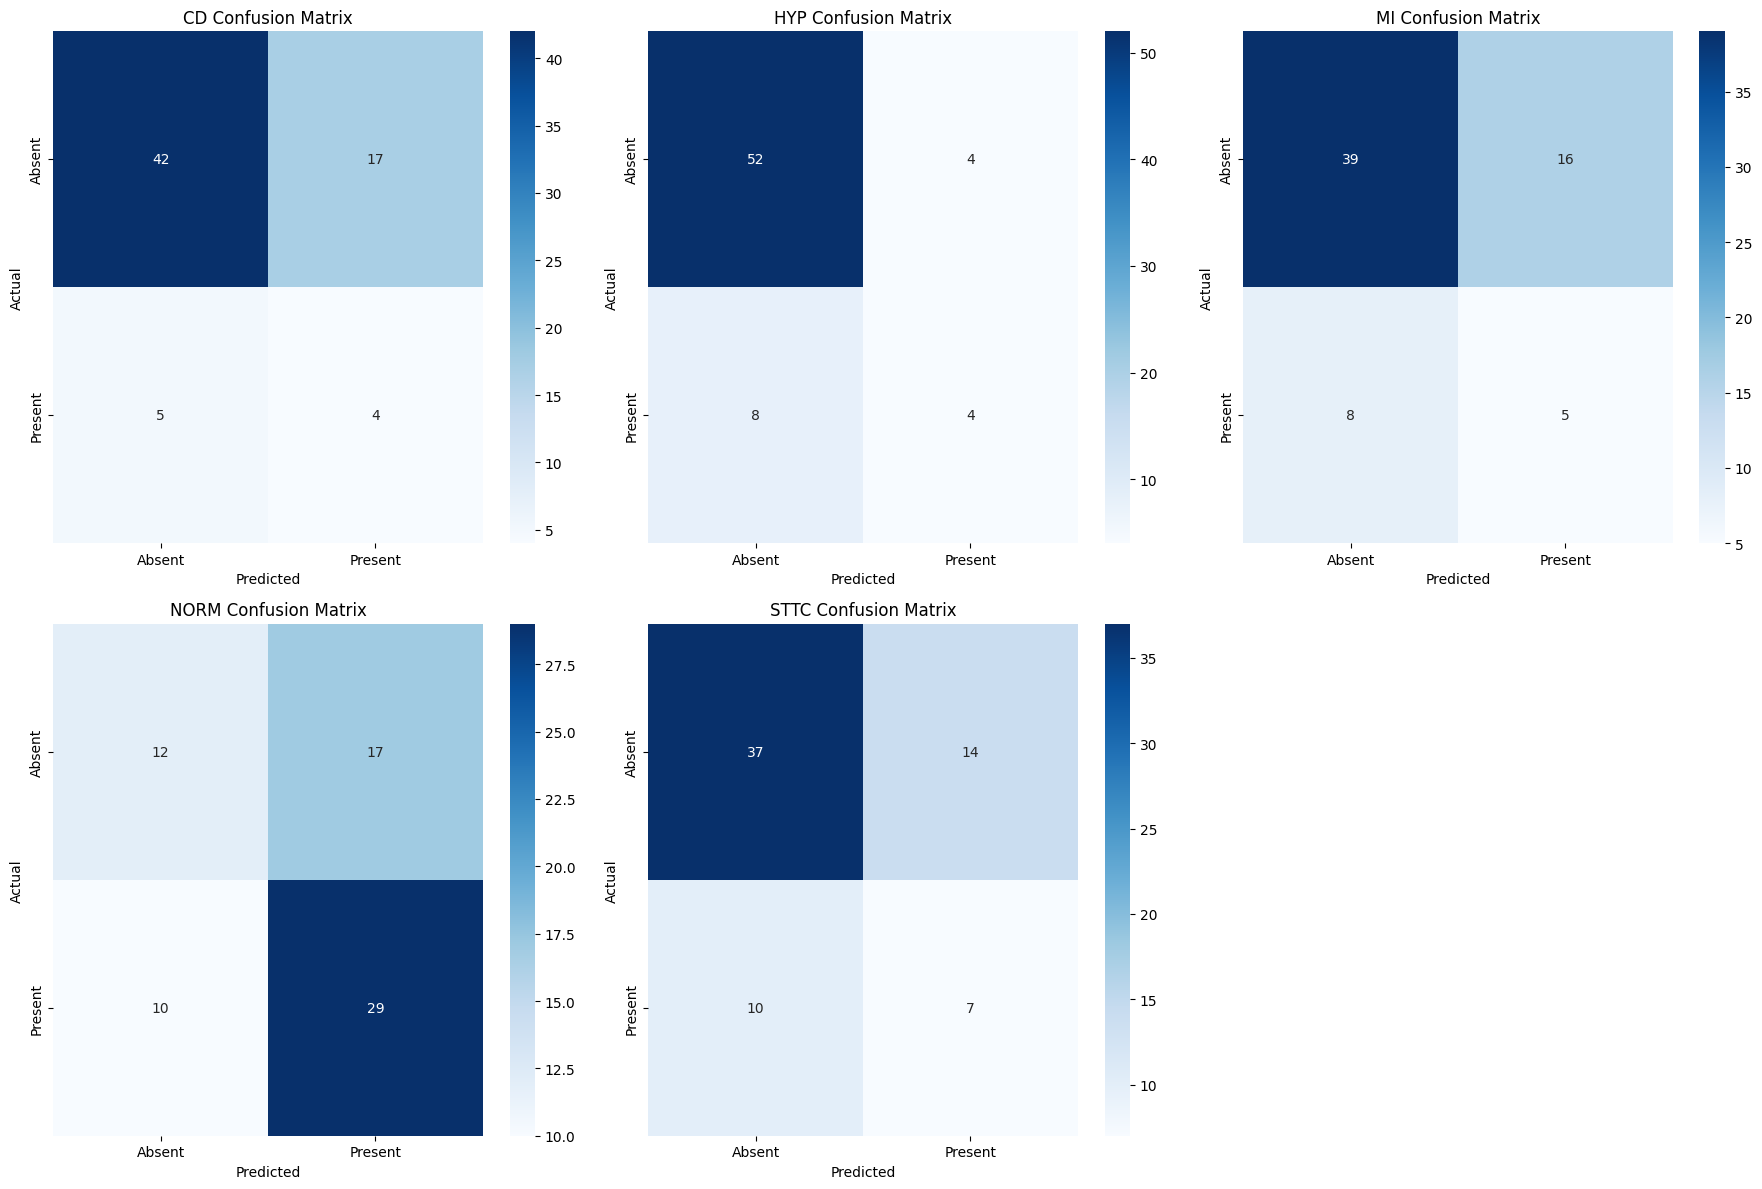

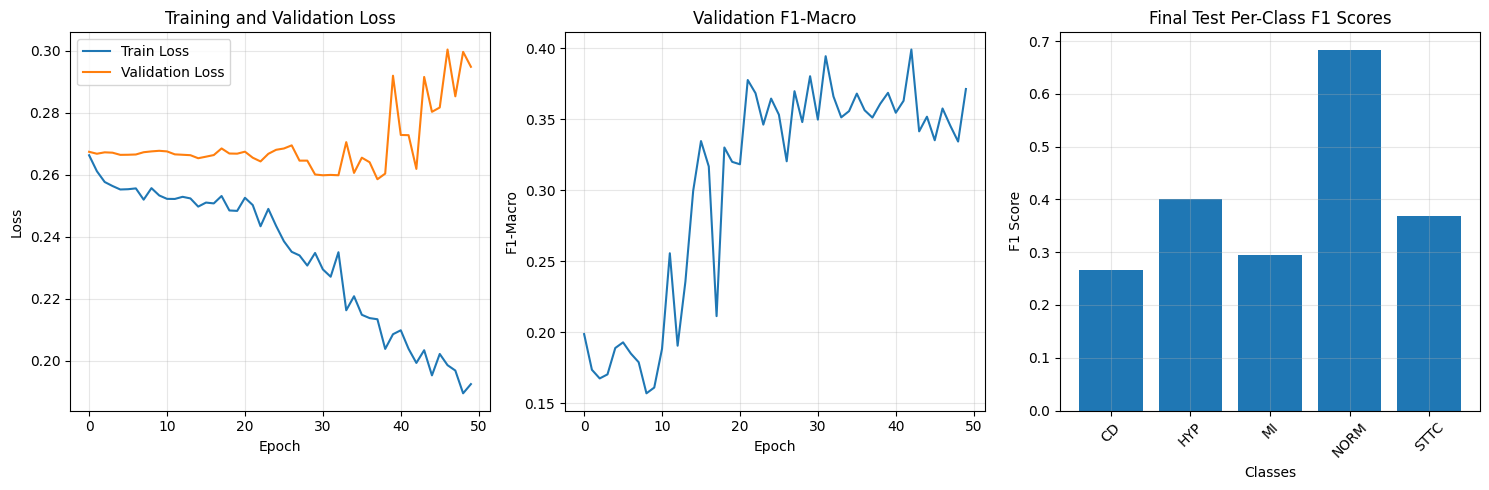


Training completed!
Best validation F1-macro: 0.3993
Final test F1-macro: 0.4023
Final test subset accuracy: 0.4412


In [110]:
# Main training loop with overfitting prevention
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model with better regularization
model = MultiLabelGraphECGNet(num_features=1000, num_classes=5, dropout_rate=0.7).to(device)

# Use the class weights you calculated
class_weights = [4.33, 10.0, 4.50, 0.78, 3.42]
criterion = MultiLabelFocalLoss(alpha=class_weights, gamma=2.0)

# Use AdamW with weight decay for better regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

best_f1_macro = 0
patience_counter = 0
patience = 25  # Reduced patience for faster training

print("Training Multi-Label GraphECGNet with Overfitting Prevention...")
train_losses = []
val_losses = []
val_f1_macros = []

for epoch in range(50):  # Reduced epochs to prevent overfitting
    try:
        train_loss = train_epoch_multilabel()
        val_loss, val_preds, val_labels, val_probs = evaluate_model_multilabel(val_loader)

        metrics = calculate_multilabel_metrics(val_labels, val_preds, class_names)
        val_f1_macro = metrics['f1_macro']

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_f1_macros.append(val_f1_macro)

        print(f'Epoch {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        print(f'  F1-Macro: {val_f1_macro:.4f}, Subset Acc: {metrics["subset_accuracy"]:.4f}')

        # Early stopping based on validation F1-macro
        if val_f1_macro > best_f1_macro:
            best_f1_macro = val_f1_macro
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f'  *** New best F1-macro: {best_f1_macro:.4f} ***')
        else:
            patience_counter += 1

        # Update learning rate scheduler
        scheduler.step(val_f1_macro)

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        print()

    except Exception as e:
        print(f"Error in epoch {epoch}: {e}")
        break

# Load best model and evaluate on test set
if 'best_model_state' in locals():
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with F1-macro: {best_f1_macro:.4f}")

print("\n" + "="*50)
print("FINAL EVALUATION ON TEST SET")
print("="*50)

test_loss, test_preds, test_labels, test_probs = evaluate_model_multilabel(test_loader)
final_metrics = calculate_multilabel_metrics(test_labels, test_preds, class_names)

# Plot confusion matrices
plot_multilabel_confusion_matrices(test_labels, test_preds, class_names)

# Training curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(val_f1_macros)
plt.title('Validation F1-Macro')
plt.xlabel('Epoch')
plt.ylabel('F1-Macro')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
final_f1_scores = f1_score(test_labels, test_preds, average=None, zero_division=0)
plt.bar(range(len(class_names)), final_f1_scores)
plt.title('Final Test Per-Class F1 Scores')
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTraining completed!")
print(f"Best validation F1-macro: {best_f1_macro:.4f}")
print(f"Final test F1-macro: {final_metrics['f1_macro']:.4f}")
print(f"Final test subset accuracy: {final_metrics['subset_accuracy']:.4f}")